In [20]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

# Parameters Config

In [6]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [7]:
DATA_SIZE = 100000
TRAINING_SIZE = 30000
TESTING_SIZE = 50000
DIGITS = 3
EPOCHS = 1
REVERSE = False
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

trainingOutputPath = 'd' + str(DIGITS) + 'e' + str(EPOCHS) + 's' + str((TRAINING_SIZE - TRAINING_SIZE/10)/1000)+'.csv' 

In [8]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)

In [9]:
ctable = CharacterTable(chars)

In [10]:
ctable.indices_char

{0: ' ',
 1: '-',
 2: '0',
 3: '1',
 4: '2',
 5: '3',
 6: '4',
 7: '5',
 8: '6',
 9: '7',
 10: '8',
 11: '9'}

# Data Generation

In [11]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < DATA_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789')) for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    q = '{}-{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a - b)
    ans += ' ' * (DIGITS + 1 - len(ans))
    if REVERSE:
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 100000


In [12]:
print(questions[:5], expected[:5])

['1-21   ', '22-286 ', '538-385', '23-6   ', '432-94 '] ['-20 ', '-264', '153 ', '17  ', '338 ']


# Processing

In [13]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [14]:
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

# train_test_split
train_x = x[:TRAINING_SIZE]
train_y = y[:TRAINING_SIZE]
test_x = x[-TESTING_SIZE:]
test_y = y[-TESTING_SIZE:]

split_at = len(train_x) - len(train_x) // 10
(x_train, x_val) = train_x[:split_at], train_x[split_at:]
(y_train, y_val) = train_y[:split_at], train_y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(27000, 7, 12)
(27000, 4, 12)
Validation Data:
(3000, 7, 12)
(3000, 4, 12)
Testing Data:
(50000, 7, 12)
(50000, 4, 12)


In [15]:
# print("input: ", x_train[:3], '\n\n', "label: ", y_train[:3])

# Build Model

In [16]:
print('Build model...')
model = Sequential()
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
model.add(layers.RepeatVector(DIGITS + 1))
for _ in range(LAYERS):
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))

model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation(''))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_1 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


# Training

In [17]:
training_log = list()
with open(trainingOutputPath, 'w') as output:
    output.write('loss,acc,val_loss,val_acc\n')
    for iteration in range(1):
        print()
        print('-' * 50)
        print('Iteration', iteration)
        history_callback = model.fit(x_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=10,
                  validation_data=(x_val, y_val))
        training_log.append(history_callback.history)

        output.write(str(history_callback.history['loss'][0]) + ',')
        output.write(str(history_callback.history['acc'][0]) + ',')
        output.write(str(history_callback.history['val_loss'][0]) + ',')
        output.write(str(history_callback.history['val_acc'][0]) + '\n')


--------------------------------------------------
Iteration 0
Train on 27000 samples, validate on 3000 samples
Epoch 1/10
27000/27000 [==============================] - 33s - loss: 2.0490 - acc: 0.2878 - val_loss: 1.7717 - val_acc: 0.3435
Epoch 2/10
27000/27000 [==============================] - 31s - loss: 1.7181 - acc: 0.3653 - val_loss: 1.6632 - val_acc: 0.3791
Epoch 3/10
27000/27000 [==============================] - 31s - loss: 1.6379 - acc: 0.3953 - val_loss: 1.6104 - val_acc: 0.3988
Epoch 4/10
27000/27000 [==============================] - 35s - loss: 1.5760 - acc: 0.4214 - val_loss: 1.5489 - val_acc: 0.4356
Epoch 5/10
27000/27000 [==============================] - 33s - loss: 1.5123 - acc: 0.4451 - val_loss: 1.4852 - val_acc: 0.4546
Epoch 6/10
27000/27000 [==============================] - 35s - loss: 1.4625 - acc: 0.4641 - val_loss: 1.4422 - val_acc: 0.4710
Epoch 7/10
27000/27000 [==============================] - 36s - loss: 1.4218 - acc: 0.4814 - val_loss: 1.3942 - val_acc

# TESTING

In [18]:
right = 0
preds = model.predict_classes(test_x, verbose=0)
for i in range(len(preds)):
    q = ctable.decode(test_x[i])
    correct = ctable.decode(test_y[i])
    guess = ctable.decode(preds[i], calc_argmax=False)
    print('Q', q[::-1] if REVERSE else q, end=' ')
    print('T', correct, end=' ')
    if correct == guess:
        right += 1
print("MSG : Accuracy is {}".format(right / len(preds)))

Q 93-327  T -234 ☒ -224
Q 653-138 T 515  ☒ 518 
Q 844-17  T 827  ☒ 855 
Q 91-11   T 80   ☒ 86  
Q 866-45  T 821  ☒ 825 
Q 703-375 T 328  ☒ 350 
Q 976-48  T 928  ☒ 818 
Q 17-682  T -665 ☒ -661
Q 91-781  T -690 ☒ -700
Q 960-776 T 184  ☒ 200 
Q 203-149 T 54   ☒ 11  
Q 824-22  T 802  ☒ 700 
Q 772-940 T -168 ☒ -11 
Q 844-71  T 773  ☒ 855 
Q 932-189 T 743  ☒ 718 
Q 742-84  T 658  ☑ 658 
Q 613-869 T -256 ☒ -255
Q 16-902  T -886 ☒ -800
Q 744-43  T 701  ☒ 620 
Q 267-583 T -316 ☒ -204
Q 976-7   T 969  ☒ 888 
Q 128-87  T 41   ☒ 11  
Q 830-763 T 67   ☒ 15  
Q 6-448   T -442 ☒ -450
Q 86-55   T 31   ☒ 22  
Q 61-868  T -807 ☒ -811
Q 449-46  T 403  ☒ 498 
Q 677-57  T 620  ☒ 618 
Q 46-154  T -108 ☒ -100
Q 223-981 T -758 ☒ -763
Q 296-384 T -88  ☒ -10 
Q 800-357 T 443  ☒ 458 
Q 21-463  T -442 ☒ -421
Q 854-871 T -17  ☒ -1  
Q 596-787 T -191 ☒ -119
Q 879-93  T 786  ☒ 800 
Q 424-391 T 33   ☒ 11  
Q 899-96  T 803  ☒ 808 
Q 30-182  T -152 ☒ -100
Q 426-457 T -31  ☒ -1  
Q 73-885  T -812 ☒ -811
Q 790-271 T 519 

Q 54-721  T -667 ☒ -666
Q 58-797  T -739 ☒ -738
Q 753-458 T 295  ☒ 450 
Q 262-7   T 255  ☒ 211 
Q 7-902   T -895 ☒ -911
Q 701-21  T 680  ☒ 780 
Q 735-76  T 659  ☒ 658 
Q 126-69  T 57   ☒ 10  
Q 945-245 T 700  ☒ 515 
Q 171-828 T -657 ☒ -600
Q 463-6   T 457  ☒ 558 
Q 13-733  T -720 ☒ -700
Q 920-173 T 747  ☒ 718 
Q 366-812 T -446 ☒ -475
Q 400-159 T 241  ☒ 285 
Q 24-413  T -389 ☒ -301
Q 39-198  T -159 ☒ -100
Q 21-81   T -60  ☒ -78 
Q 59-180  T -121 ☒ -100
Q 575-59  T 516  ☒ 588 
Q 989-270 T 719  ☒ 618 
Q 136-607 T -471 ☒ -400
Q 957-88  T 869  ☒ 855 
Q 255-202 T 53   ☒ 10  
Q 572-453 T 119  ☒ 13  
Q 97-912  T -815 ☒ -833
Q 195-538 T -343 ☒ -301
Q 316-283 T 33   ☒ 11  
Q 581-131 T 450  ☒ 458 
Q 577-125 T 452  ☒ 415 
Q 502-341 T 161  ☒ 130 
Q 75-105  T -30  ☒ -10 
Q 884-38  T 846  ☒ 805 
Q 255-873 T -618 ☒ -520
Q 869-1   T 868  ☒ 885 
Q 70-952  T -882 ☒ -800
Q 204-705 T -501 ☒ -400
Q 204-52  T 152  ☒ 100 
Q 92-220  T -128 ☒ -122
Q 291-37  T 254  ☒ 257 
Q 929-303 T 626  ☒ 658 
Q 135-586 T -451

Q 146-583 T -437 ☒ -400
Q 670-211 T 459  ☒ 555 
Q 37-260  T -223 ☒ -208
Q 81-87   T -6   ☒ -10 
Q 103-79  T 24   ☒ 10  
Q 62-33   T 29   ☒ 28  
Q 116-64  T 52   ☒ 10  
Q 784-573 T 211  ☒ 200 
Q 967-5   T 962  ☒ 885 
Q 411-657 T -246 ☒ -260
Q 948-57  T 891  ☒ 858 
Q 851-34  T 817  ☒ 825 
Q 118-257 T -139 ☒ -101
Q 692-508 T 184  ☒ 130 
Q 45-301  T -256 ☒ -200
Q 55-444  T -389 ☒ -308
Q 419-45  T 374  ☒ 388 
Q 671-986 T -315 ☒ -225
Q 285-41  T 244  ☒ 247 
Q 197-71  T 126  ☒ 112 
Q 784-66  T 718  ☑ 718 
Q 234-36  T 198  ☒ 201 
Q 654-499 T 155  ☒ 15  
Q 12-61   T -49  ☒ -10 
Q 410-657 T -247 ☒ -260
Q 6-311   T -305 ☒ -301
Q 674-271 T 403  ☒ 451 
Q 428-506 T -78  ☒ -10 
Q 1-381   T -380 ☒ -378
Q 777-71  T 706  ☒ 710 
Q 69-907  T -838 ☒ -800
Q 188-37  T 151  ☒ 109 
Q 425-80  T 345  ☒ 350 
Q 243-337 T -94  ☒ -10 
Q 17-419  T -402 ☒ -411
Q 61-6    T 55   ☒ 53  
Q 94-81   T 13   ☒ 10  
Q 898-15  T 883  ☒ 805 
Q 282-24  T 258  ☒ 257 
Q 91-166  T -75  ☒ -12 
Q 144-257 T -113 ☒ -10 
Q 676-339 T 337 

Q 90-301  T -211 ☒ -222
Q 813-454 T 359  ☒ 455 
Q 518-501 T 17   ☒ 11  
Q 430-655 T -225 ☒ -200
Q 443-5   T 438  ☒ 430 
Q 75-255  T -180 ☒ -166
Q 102-47  T 55   ☒ 10  
Q 378-455 T -77  ☒ -10 
Q 878-15  T 863  ☒ 800 
Q 449-50  T 399  ☒ 488 
Q 472-601 T -129 ☒ -13 
Q 34-244  T -210 ☒ -200
Q 2-667   T -665 ☒ -662
Q 22-171  T -149 ☒ -110
Q 94-518  T -424 ☒ -432
Q 333-65  T 268  ☒ 290 
Q 699-127 T 572  ☒ 558 
Q 211-116 T 95   ☒ 10  
Q 64-913  T -849 ☒ -805
Q 231-179 T 52   ☒ 15  
Q 334-96  T 238  ☒ 250 
Q 285-737 T -452 ☒ -461
Q 238-83  T 155  ☒ 121 
Q 66-858  T -792 ☒ -718
Q 476-50  T 426  ☒ 488 
Q 6-830   T -824 ☒ -811
Q 467-471 T -4   ☒ -1  
Q 664-172 T 492  ☒ 518 
Q 204-378 T -174 ☒ -166
Q 333-366 T -33  ☒ -1  
Q 405-85  T 320  ☒ 380 
Q 77-951  T -874 ☒ -800
Q 348-92  T 256  ☒ 350 
Q 0-106   T -106 ☒ -110
Q 29-395  T -366 ☒ -356
Q 736-75  T 661  ☒ 618 
Q 416-18  T 398  ☒ 408 
Q 417-508 T -91  ☒ -10 
Q 37-883  T -846 ☒ -858
Q 667-185 T 482  ☒ 518 
Q 19-66   T -47  ☒ -10 
Q 22-813  T -791

Q 2-960   T -958 ☒ -950
Q 60-101  T -41  ☒ -10 
Q 596-6   T 590  ☒ 555 
Q 168-3   T 165  ☒ 108 
Q 21-323  T -302 ☒ -311
Q 15-586  T -571 ☒ -554
Q 936-42  T 894  ☒ 825 
Q 77-55   T 22   ☑ 22  
Q 60-947  T -887 ☒ -800
Q 485-66  T 419  ☒ 488 
Q 41-528  T -487 ☒ -401
Q 237-587 T -350 ☒ -325
Q 47-139  T -92  ☒ -10 
Q 146-58  T 88   ☒ 10  
Q 849-867 T -18  ☒ -1  
Q 140-808 T -668 ☒ -600
Q 351-42  T 309  ☒ 388 
Q 36-835  T -799 ☒ -708
Q 797-956 T -159 ☒ -11 
Q 389-17  T 372  ☒ 488 
Q 353-87  T 266  ☒ 350 
Q 81-995  T -914 ☒ -900
Q 198-22  T 176  ☒ 159 
Q 707-583 T 124  ☒ 10  
Q 118-767 T -649 ☒ -660
Q 902-34  T 868  ☒ 820 
Q 998-8   T 990  ☒ 888 
Q 264-145 T 119  ☒ 100 
Q 884-143 T 741  ☒ 755 
Q 422-877 T -455 ☒ -406
Q 608-737 T -129 ☒ -10 
Q 940-193 T 747  ☒ 638 
Q 8-618   T -610 ☑ -610
Q 663-3   T 660  ☒ 655 
Q 420-758 T -338 ☒ -375
Q 953-4   T 949  ☒ 855 
Q 11-21   T -10  ☒ -   
Q 743-555 T 188  ☒ 150 
Q 242-269 T -27  ☒ -1  
Q 354-82  T 272  ☒ 380 
Q 575-68  T 507  ☒ 588 
Q 884-35  T 849 

Q 79-950  T -871 ☒ -805
Q 484-275 T 209  ☒ 230 
Q 22-229  T -207 ☒ -200
Q 237-609 T -372 ☒ -363
Q 39-354  T -315 ☒ -308
Q 664-687 T -23  ☒ -1  
Q 46-167  T -121 ☒ -100
Q 625-185 T 440  ☒ 488 
Q 19-289  T -270 ☒ -289
Q 307-24  T 283  ☒ 288 
Q 49-53   T -4   ☒ -   
Q 595-807 T -212 ☒ -215
Q 325-854 T -529 ☒ -500
Q 86-204  T -118 ☒ -124
Q 638-71  T 567  ☒ 618 
Q 227-13  T 214  ☒ 201 
Q 921-95  T 826  ☒ 831 
Q 9-392   T -383 ☒ -389
Q 2-961   T -959 ☒ -954
Q 53-941  T -888 ☒ -805
Q 917-40  T 877  ☒ 800 
Q 402-59  T 343  ☒ 388 
Q 540-398 T 142  ☒ 150 
Q 613-8   T 605  ☒ 688 
Q 390-16  T 374  ☒ 388 
Q 563-909 T -346 ☒ -345
Q 985-413 T 572  ☒ 835 
Q 166-85  T 81   ☒ 11  
Q 49-17   T 32   ☒ 30  
Q 571-508 T 63   ☒ 11  
Q 912-532 T 380  ☒ 453 
Q 894-34  T 860  ☒ 825 
Q 614-133 T 481  ☒ 408 
Q 97-127  T -30  ☒ -12 
Q 93-577  T -484 ☒ -561
Q 848-72  T 776  ☒ 700 
Q 75-417  T -342 ☒ -376
Q 30-538  T -508 ☒ -500
Q 674-7   T 667  ☒ 658 
Q 369-180 T 189  ☒ 230 
Q 33-149  T -116 ☒ -100
Q 489-295 T 194 

Q 161-47  T 114  ☒ 104 
Q 884-431 T 453  ☒ 455 
Q 57-521  T -464 ☒ -466
Q 94-303  T -209 ☒ -254
Q 78-71   T 7    ☒ 1   
Q 742-553 T 189  ☒ 150 
Q 63-217  T -154 ☒ -100
Q 68-758  T -690 ☒ -618
Q 467-34  T 433  ☒ 428 
Q 77-833  T -756 ☒ -703
Q 73-346  T -273 ☒ -286
Q 357-776 T -419 ☒ -421
Q 816-845 T -29  ☒ -1  
Q 15-876  T -861 ☒ -850
Q 560-195 T 365  ☒ 488 
Q 328-207 T 121  ☒ 140 
Q 361-22  T 339  ☒ 388 
Q 196-51  T 145  ☒ 122 
Q 568-414 T 154  ☒ 130 
Q 80-625  T -545 ☒ -542
Q 491-595 T -104 ☒ -13 
Q 251-687 T -436 ☒ -445
Q 648-470 T 178  ☒ 230 
Q 334-926 T -592 ☒ -583
Q 248-89  T 159  ☒ 241 
Q 9-579   T -570 ☒ -580
Q 68-723  T -655 ☒ -664
Q 932-481 T 451  ☒ 455 
Q 37-601  T -564 ☒ -553
Q 352-42  T 310  ☒ 398 
Q 498-655 T -157 ☒ -115
Q 34-293  T -259 ☒ -250
Q 482-545 T -63  ☒ -10 
Q 345-591 T -246 ☒ -200
Q 576-59  T 517  ☒ 518 
Q 454-325 T 129  ☒ 100 
Q 477-24  T 453  ☒ 538 
Q 616-38  T 578  ☒ 518 
Q 62-311  T -249 ☒ -264
Q 29-409  T -380 ☒ -301
Q 21-527  T -506 ☒ -511
Q 2-423   T -421

Q 604-550 T 54   ☒ 11  
Q 384-827 T -443 ☒ -476
Q 660-252 T 408  ☒ 455 
Q 62-632  T -570 ☒ -556
Q 584-6   T 578  ☒ 554 
Q 65-696  T -631 ☒ -628
Q 14-370  T -356 ☒ -360
Q 984-177 T 807  ☒ 818 
Q 70-487  T -417 ☒ -416
Q 8-963   T -955 ☒ -954
Q 513-105 T 408  ☒ 308 
Q 696-306 T 390  ☒ 458 
Q 777-152 T 625  ☒ 611 
Q 10-65   T -55  ☒ -58 
Q 88-382  T -294 ☒ -211
Q 626-44  T 582  ☒ 518 
Q 47-367  T -320 ☒ -301
Q 55-7    T 48   ☒ 33  
Q 7-236   T -229 ☒ -208
Q 0-433   T -433 ☒ -411
Q 81-652  T -571 ☒ -561
Q 82-160  T -78  ☒ -12 
Q 144-629 T -485 ☒ -500
Q 34-16   T 18   ☒ 2   
Q 763-89  T 674  ☒ 658 
Q 58-296  T -238 ☒ -208
Q 57-319  T -262 ☒ -286
Q 2-574   T -572 ☒ -552
Q 574-169 T 405  ☒ 418 
Q 797-762 T 35   ☒ 11  
Q 236-74  T 162  ☒ 241 
Q 21-40   T -19  ☒ -1  
Q 973-5   T 968  ☒ 885 
Q 922-25  T 897  ☒ 800 
Q 73-288  T -215 ☒ -208
Q 174-728 T -554 ☒ -500
Q 956-96  T 860  ☒ 855 
Q 82-271  T -189 ☒ -224
Q 38-8    T 30   ☒ 43  
Q 239-932 T -693 ☒ -703
Q 853-90  T 763  ☒ 855 
Q 474-625 T -151

Q 859-966 T -107 ☒ -10 
Q 287-83  T 204  ☒ 111 
Q 130-85  T 45   ☒ 10  
Q 83-927  T -844 ☒ -803
Q 954-320 T 634  ☒ 535 
Q 89-894  T -805 ☒ -801
Q 25-769  T -744 ☒ -752
Q 388-25  T 363  ☒ 488 
Q 292-45  T 247  ☒ 257 
Q 116-369 T -253 ☒ -260
Q 45-199  T -154 ☒ -240
Q 876-851 T 25   ☒ 11  
Q 185-469 T -284 ☒ -201
Q 94-530  T -436 ☒ -446
Q 961-463 T 498  ☒ 555 
Q 920-41  T 879  ☒ 800 
Q 96-879  T -783 ☒ -800
Q 39-5    T 34   ☒ 33  
Q 157-536 T -379 ☒ -400
Q 22-886  T -864 ☒ -850
Q 6-430   T -424 ☒ -400
Q 40-574  T -534 ☒ -521
Q 6-911   T -905 ☒ -911
Q 563-597 T -34  ☒ -1  
Q 831-429 T 402  ☒ 555 
Q 73-54   T 19   ☒ 22  
Q 91-571  T -480 ☒ -521
Q 5-950   T -945 ☒ -954
Q 311-16  T 295  ☒ 200 
Q 294-827 T -533 ☒ -503
Q 5-210   T -205 ☒ -200
Q 692-58  T 634  ☒ 618 
Q 820-237 T 583  ☒ 658 
Q 558-469 T 89   ☒ 11  
Q 89-826  T -737 ☒ -730
Q 382-53  T 329  ☒ 288 
Q 94-558  T -464 ☒ -466
Q 873-321 T 552  ☒ 655 
Q 887-526 T 361  ☒ 200 
Q 566-30  T 536  ☒ 518 
Q 32-425  T -393 ☒ -301
Q 80-82   T -2  

Q 617-54  T 563  ☒ 518 
Q 647-753 T -106 ☒ -10 
Q 462-32  T 430  ☒ 408 
Q 13-704  T -691 ☒ -600
Q 328-214 T 114  ☒ 100 
Q 359-87  T 272  ☒ 350 
Q 902-61  T 841  ☒ 800 
Q 914-464 T 450  ☒ 455 
Q 52-732  T -680 ☒ -660
Q 563-606 T -43  ☒ -1  
Q 83-452  T -369 ☒ -366
Q 141-591 T -450 ☒ -400
Q 582-10  T 572  ☒ 625 
Q 99-325  T -226 ☒ -222
Q 891-494 T 397  ☒ 350 
Q 936-740 T 196  ☒ 253 
Q 261-765 T -504 ☒ -406
Q 643-89  T 554  ☒ 555 
Q 693-94  T 599  ☒ 658 
Q 519-46  T 473  ☒ 488 
Q 40-744  T -704 ☒ -700
Q 114-73  T 41   ☒ 10  
Q 774-70  T 704  ☒ 710 
Q 364-17  T 347  ☒ 408 
Q 489-90  T 399  ☒ 430 
Q 556-23  T 533  ☒ 510 
Q 5-708   T -703 ☒ -751
Q 51-975  T -924 ☒ -930
Q 223-24  T 199  ☒ 211 
Q 548-659 T -111 ☒ -11 
Q 974-62  T 912  ☒ 825 
Q 98-545  T -447 ☒ -432
Q 518-627 T -109 ☒ -10 
Q 616-29  T 587  ☒ 618 
Q 263-6   T 257  ☒ 208 
Q 995-997 T -2   ☒ -1  
Q 435-959 T -524 ☒ -500
Q 444-92  T 352  ☒ 450 
Q 31-345  T -314 ☒ -311
Q 51-682  T -631 ☒ -621
Q 22-479  T -457 ☒ -466
Q 226-664 T -438

Q 300-500 T -200 ☒ -144
Q 61-976  T -915 ☒ -920
Q 365-327 T 38   ☒ 10  
Q 812-70  T 742  ☒ 700 
Q 8-845   T -837 ☒ -851
Q 46-322  T -276 ☒ -208
Q 62-766  T -704 ☒ -600
Q 109-156 T -47  ☒ -1  
Q 37-796  T -759 ☒ -750
Q 834-519 T 315  ☒ 455 
Q 76-461  T -385 ☒ -376
Q 627-460 T 167  ☒ 131 
Q 18-603  T -585 ☒ -510
Q 502-819 T -317 ☒ -265
Q 9-320   T -311 ☒ -332
Q 937-341 T 596  ☒ 518 
Q 500-49  T 451  ☒ 488 
Q 1-586   T -585 ☒ -578
Q 187-152 T 35   ☒ 11  
Q 82-288  T -206 ☒ -212
Q 46-536  T -490 ☒ -509
Q 224-88  T 136  ☒ 151 
Q 316-76  T 240  ☒ 251 
Q 287-54  T 233  ☒ 247 
Q 95-551  T -456 ☒ -466
Q 64-967  T -903 ☒ -910
Q 38-176  T -138 ☒ -100
Q 587-839 T -252 ☒ -215
Q 2-577   T -575 ☒ -577
Q 48-619  T -571 ☒ -566
Q 607-656 T -49  ☒ -1  
Q 802-386 T 416  ☒ 558 
Q 747-983 T -236 ☒ -250
Q 91-467  T -376 ☒ -302
Q 547-46  T 501  ☒ 418 
Q 83-571  T -488 ☒ -566
Q 507-79  T 428  ☒ 488 
Q 356-350 T 6    ☒ 11  
Q 49-30   T 19   ☒ 2   
Q 217-567 T -350 ☒ -366
Q 89-985  T -896 ☒ -800
Q 670-894 T -224

Q 62-4    T 58   ☒ 39  
Q 470-673 T -203 ☒ -250
Q 800-146 T 654  ☒ 658 
Q 710-785 T -75  ☒ -1  
Q 10-234  T -224 ☒ -211
Q 797-938 T -141 ☒ -11 
Q 10-469  T -459 ☒ -470
Q 712-8   T 704  ☒ 700 
Q 965-941 T 24   ☒ 11  
Q 168-42  T 126  ☒ 145 
Q 90-90   T 0    ☒ -1  
Q 933-26  T 907  ☒ 820 
Q 213-549 T -336 ☒ -300
Q 61-962  T -901 ☒ -800
Q 375-853 T -478 ☒ -486
Q 84-567  T -483 ☒ -466
Q 1-970   T -969 ☒ -960
Q 711-48  T 663  ☒ 718 
Q 306-997 T -691 ☒ -623
Q 512-884 T -372 ☒ -345
Q 305-768 T -463 ☒ -420
Q 89-450  T -361 ☒ -342
Q 691-838 T -147 ☒ -111
Q 921-483 T 438  ☒ 455 
Q 779-76  T 703  ☒ 618 
Q 914-978 T -64  ☒ -1  
Q 213-0   T 213  ☒ 111 
Q 318-579 T -261 ☒ -266
Q 63-89   T -26  ☒ -22 
Q 316-60  T 256  ☒ 288 
Q 930-7   T 923  ☒ 898 
Q 85-110  T -25  ☒ -4  
Q 549-468 T 81   ☒ 11  
Q 64-17   T 47   ☒ 33  
Q 90-588  T -498 ☒ -511
Q 33-605  T -572 ☒ -500
Q 36-777  T -741 ☒ -722
Q 34-775  T -741 ☒ -732
Q 263-172 T 91   ☒ 10  
Q 640-902 T -262 ☒ -255
Q 799-272 T 527  ☒ 510 
Q 37-882  T -845

Q 700-25  T 675  ☒ 688 
Q 701-643 T 58   ☒ 12  
Q 577-30  T 547  ☒ 528 
Q 125-579 T -454 ☒ -446
Q 361-6   T 355  ☒ 308 
Q 954-77  T 877  ☒ 855 
Q 637-152 T 485  ☒ 518 
Q 698-343 T 355  ☒ 435 
Q 53-42   T 11   ☒ 2   
Q 38-83   T -45  ☒ -28 
Q 467-71  T 396  ☒ 480 
Q 82-535  T -453 ☒ -462
Q 854-441 T 413  ☒ 455 
Q 872-30  T 842  ☒ 800 
Q 258-240 T 18   ☒ 11  
Q 154-62  T 92   ☒ 10  
Q 25-526  T -501 ☒ -511
Q 443-632 T -189 ☒ -280
Q 713-576 T 137  ☒ 151 
Q 21-104  T -83  ☒ -10 
Q 382-50  T 332  ☒ 388 
Q 306-64  T 242  ☒ 288 
Q 114-51  T 63   ☒ 10  
Q 376-932 T -556 ☒ -583
Q 685-22  T 663  ☒ 655 
Q 24-476  T -452 ☒ -434
Q 981-389 T 592  ☒ 758 
Q 920-726 T 194  ☒ 153 
Q 6-98    T -92  ☒ -68 
Q 49-328  T -279 ☒ -208
Q 355-771 T -416 ☒ -411
Q 97-149  T -52  ☒ -12 
Q 476-94  T 382  ☒ 380 
Q 526-358 T 168  ☒ 100 
Q 569-612 T -43  ☒ -1  
Q 89-898  T -809 ☒ -801
Q 167-171 T -4   ☒ 11  
Q 424-702 T -278 ☒ -273
Q 831-74  T 757  ☒ 700 
Q 173-988 T -815 ☒ -823
Q 85-694  T -609 ☒ -666
Q 7-961   T -954

Q 8-78    T -70  ☒ -68 
Q 356-14  T 342  ☒ 408 
Q 4-31    T -27  ☒ -10 
Q 592-646 T -54  ☒ -1  
Q 564-996 T -432 ☒ -408
Q 173-7   T 166  ☒ 119 
Q 984-61  T 923  ☒ 835 
Q 782-36  T 746  ☒ 718 
Q 15-359  T -344 ☒ -322
Q 376-519 T -143 ☒ -100
Q 15-137  T -122 ☒ -130
Q 925-707 T 218  ☒ 253 
Q 92-880  T -788 ☒ -800
Q 546-775 T -229 ☒ -210
Q 61-623  T -562 ☒ -553
Q 66-906  T -840 ☒ -805
Q 79-481  T -402 ☒ -401
Q 642-40  T 602  ☒ 518 
Q 468-287 T 181  ☒ 200 
Q 394-979 T -585 ☒ -583
Q 77-283  T -206 ☒ -204
Q 918-12  T 906  ☒ 800 
Q 399-777 T -378 ☒ -383
Q 36-261  T -225 ☒ -208
Q 46-620  T -574 ☒ -566
Q 930-913 T 17   ☒ 12  
Q 731-767 T -36  ☒ -1  
Q 984-219 T 765  ☒ 835 
Q 20-26   T -6   ☒ -   
Q 935-38  T 897  ☒ 858 
Q 20-642  T -622 ☒ -610
Q 10-158  T -148 ☒ -110
Q 970-16  T 954  ☒ 800 
Q 336-703 T -367 ☒ -363
Q 95-66   T 29   ☒ 19  
Q 519-398 T 121  ☒ 153 
Q 874-44  T 830  ☒ 825 
Q 231-37  T 194  ☒ 211 
Q 431-414 T 17   ☒ 10  
Q 946-481 T 465  ☒ 458 
Q 759-581 T 178  ☒ 10  
Q 981-83  T 898 

Q 567-39  T 528  ☒ 518 
Q 111-51  T 60   ☒ 10  
Q 886-271 T 615  ☒ 650 
Q 63-503  T -440 ☒ -466
Q 788-144 T 644  ☒ 655 
Q 818-96  T 722  ☒ 711 
Q 58-646  T -588 ☒ -509
Q 34-141  T -107 ☒ -100
Q 748-972 T -224 ☒ -251
Q 366-294 T 72   ☒ 10  
Q 30-16   T 14   ☒ 1   
Q 963-49  T 914  ☒ 855 
Q 79-409  T -330 ☒ -342
Q 415-912 T -497 ☒ -583
Q 517-29  T 488  ☒ 588 
Q 383-14  T 369  ☒ 388 
Q 833-0   T 833  ☒ 880 
Q 66-38   T 28   ☒ 2   
Q 754-754 T 0    ☒ 11  
Q 815-977 T -162 ☒ -13 
Q 380-368 T 12   ☒ 11  
Q 746-57  T 689  ☒ 618 
Q 700-78  T 622  ☒ 618 
Q 359-697 T -338 ☒ -320
Q 700-748 T -48  ☒ -1  
Q 623-855 T -232 ☒ -255
Q 67-840  T -773 ☒ -700
Q 144-227 T -83  ☒ -10 
Q 152-227 T -75  ☒ -10 
Q 619-44  T 575  ☒ 528 
Q 530-92  T 438  ☒ 450 
Q 120-713 T -593 ☒ -600
Q 671-39  T 632  ☒ 618 
Q 13-64   T -51  ☒ -36 
Q 0-615   T -615 ☒ -610
Q 910-54  T 856  ☒ 800 
Q 222-151 T 71   ☒ 11  
Q 67-81   T -14  ☒ -1  
Q 303-648 T -345 ☒ -303
Q 232-594 T -362 ☒ -365
Q 137-359 T -222 ☒ -200
Q 143-541 T -398

Q 67-173  T -106 ☒ -140
Q 525-268 T 257  ☒ 250 
Q 11-689  T -678 ☒ -668
Q 42-24   T 18   ☒ 2   
Q 761-714 T 47   ☒ 11  
Q 346-716 T -370 ☒ -376
Q 704-269 T 435  ☒ 458 
Q 601-35  T 566  ☒ 588 
Q 138-18  T 120  ☒ 101 
Q 56-837  T -781 ☒ -700
Q 617-167 T 450  ☒ 488 
Q 158-343 T -185 ☒ -200
Q 239-10  T 229  ☒ 208 
Q 566-229 T 337  ☒ 410 
Q 303-32  T 271  ☒ 288 
Q 396-58  T 338  ☒ 388 
Q 111-449 T -338 ☒ -300
Q 15-563  T -548 ☒ -541
Q 954-742 T 212  ☒ 353 
Q 810-782 T 28   ☒ 11  
Q 941-68  T 873  ☒ 858 
Q 20-580  T -560 ☒ -540
Q 667-363 T 304  ☒ 211 
Q 19-136  T -117 ☒ -100
Q 548-600 T -52  ☒ -13 
Q 640-85  T 555  ☒ 558 
Q 450-146 T 304  ☒ 308 
Q 8-134   T -126 ☑ -126
Q 660-38  T 622  ☒ 618 
Q 12-339  T -327 ☒ -311
Q 94-345  T -251 ☒ -264
Q 388-35  T 353  ☒ 388 
Q 75-718  T -643 ☒ -656
Q 38-854  T -816 ☒ -822
Q 57-782  T -725 ☒ -721
Q 292-495 T -203 ☒ -201
Q 72-507  T -435 ☒ -461
Q 462-77  T 385  ☒ 380 
Q 14-813  T -799 ☒ -800
Q 778-252 T 526  ☒ 555 
Q 380-506 T -126 ☒ -13 
Q 521-35  T 486 

Q 72-591  T -519 ☒ -553
Q 406-874 T -468 ☒ -485
Q 375-20  T 355  ☒ 488 
Q 51-740  T -689 ☒ -760
Q 62-680  T -618 ☒ -606
Q 779-672 T 107  ☒ 11  
Q 568-699 T -131 ☒ -110
Q 576-873 T -297 ☒ -285
Q 87-317  T -230 ☒ -224
Q 59-201  T -142 ☒ -156
Q 62-526  T -464 ☒ -461
Q 44-222  T -178 ☒ -100
Q 851-188 T 663  ☒ 758 
Q 68-714  T -646 ☒ -653
Q 245-967 T -722 ☒ -723
Q 563-99  T 464  ☒ 455 
Q 90-101  T -11  ☒ -42 
Q 3-962   T -959 ☒ -954
Q 47-719  T -672 ☒ -603
Q 95-424  T -329 ☒ -344
Q 996-49  T 947  ☒ 828 
Q 925-520 T 405  ☒ 455 
Q 335-78  T 257  ☒ 250 
Q 182-91  T 91   ☒ 11  
Q 357-237 T 120  ☒ 100 
Q 878-878 T 0    ☒ 11  
Q 15-29   T -14  ☒ -   
Q 84-878  T -794 ☒ -800
Q 847-466 T 381  ☒ 458 
Q 924-469 T 455  ☒ 458 
Q 76-396  T -320 ☒ -308
Q 242-79  T 163  ☒ 251 
Q 766-757 T 9    ☒ 11  
Q 18-397  T -379 ☒ -360
Q 3-517   T -514 ☒ -500
Q 793-32  T 761  ☒ 725 
Q 289-832 T -543 ☒ -503
Q 362-640 T -278 ☒ -270
Q 444-46  T 398  ☒ 498 
Q 663-88  T 575  ☒ 555 
Q 84-523  T -439 ☒ -446
Q 980-263 T 717 

Q 96-597  T -501 ☒ -509
Q 285-56  T 229  ☒ 247 
Q 784-489 T 295  ☒ 250 
Q 716-438 T 278  ☒ 250 
Q 789-560 T 229  ☒ 200 
Q 58-957  T -899 ☒ -818
Q 556-129 T 427  ☒ 418 
Q 46-934  T -888 ☒ -805
Q 630-16  T 614  ☒ 610 
Q 435-87  T 348  ☒ 350 
Q 699-74  T 625  ☒ 618 
Q 23-423  T -400 ☒ -301
Q 73-713  T -640 ☒ -653
Q 31-766  T -735 ☑ -735
Q 77-676  T -599 ☒ -600
Q 46-1    T 45   ☒ 39  
Q 291-30  T 261  ☒ 268 
Q 940-48  T 892  ☒ 858 
Q 226-877 T -651 ☒ -623
Q 722-316 T 406  ☒ 550 
Q 7-286   T -279 ☒ -289
Q 396-337 T 59   ☒ 10  
Q 580-7   T 573  ☒ 558 
Q 375-456 T -81  ☒ -10 
Q 90-147  T -57  ☒ -12 
Q 964-715 T 249  ☒ 350 
Q 644-134 T 510  ☒ 410 
Q 809-634 T 175  ☒ 200 
Q 444-56  T 388  ☒ 498 
Q 60-895  T -835 ☒ -828
Q 74-214  T -140 ☑ -140
Q 29-264  T -235 ☒ -208
Q 828-87  T 741  ☒ 700 
Q 15-440  T -425 ☒ -401
Q 453-17  T 436  ☒ 400 
Q 781-679 T 102  ☒ 11  
Q 914-532 T 382  ☒ 455 
Q 80-927  T -847 ☒ -801
Q 54-77   T -23  ☑ -23 
Q 48-810  T -762 ☒ -764
Q 725-98  T 627  ☒ 651 
Q 355-229 T 126 

Q 918-877 T 41   ☒ 11  
Q 328-128 T 200  ☑ 200 
Q 723-812 T -89  ☒ -1  
Q 689-52  T 637  ☒ 625 
Q 37-499  T -462 ☒ -454
Q 168-50  T 118  ☒ 145 
Q 429-379 T 50   ☒ 10  
Q 758-271 T 487  ☒ 550 
Q 889-277 T 612  ☒ 618 
Q 306-153 T 153  ☒ 100 
Q 536-83  T 453  ☒ 488 
Q 209-404 T -195 ☒ -201
Q 924-340 T 584  ☒ 558 
Q 591-66  T 525  ☒ 518 
Q 474-903 T -429 ☒ -445
Q 15-812  T -797 ☒ -801
Q 161-784 T -623 ☒ -520
Q 719-326 T 393  ☒ 458 
Q 565-381 T 184  ☒ 100 
Q 780-50  T 730  ☒ 708 
Q 579-179 T 400  ☒ 488 
Q 54-37   T 17   ☒ 2   
Q 977-38  T 939  ☒ 810 
Q 923-592 T 331  ☒ 353 
Q 92-146  T -54  ☒ -12 
Q 394-43  T 351  ☒ 338 
Q 78-148  T -70  ☒ -14 
Q 128-88  T 40   ☒ 11  
Q 585-832 T -247 ☒ -245
Q 6-165   T -159 ☒ -110
Q 75-824  T -749 ☒ -765
Q 890-371 T 519  ☒ 658 
Q 373-89  T 284  ☒ 250 
Q 545-272 T 273  ☒ 200 
Q 626-34  T 592  ☒ 518 
Q 384-181 T 203  ☒ 240 
Q 576-6   T 570  ☒ 655 
Q 937-501 T 436  ☒ 450 
Q 603-931 T -328 ☒ -245
Q 386-530 T -144 ☒ -150
Q 929-229 T 700  ☒ 658 
Q 23-243  T -220

Q 184-32  T 152  ☒ 147 
Q 368-18  T 350  ☒ 488 
Q 755-40  T 715  ☒ 725 
Q 660-690 T -30  ☒ -1  
Q 695-162 T 533  ☒ 518 
Q 954-502 T 452  ☒ 455 
Q 726-642 T 84   ☒ 11  
Q 679-349 T 330  ☒ 210 
Q 93-816  T -723 ☒ -733
Q 90-457  T -367 ☒ -342
Q 61-590  T -529 ☒ -500
Q 15-175  T -160 ☒ -130
Q 776-60  T 716  ☒ 718 
Q 408-533 T -125 ☒ -14 
Q 225-40  T 185  ☒ 201 
Q 121-627 T -506 ☒ -500
Q 522-268 T 254  ☒ 250 
Q 334-515 T -181 ☒ -200
Q 480-841 T -361 ☒ -365
Q 74-816  T -742 ☒ -760
Q 604-93  T 511  ☒ 458 
Q 700-512 T 188  ☒ 153 
Q 302-94  T 208  ☒ 241 
Q 347-440 T -93  ☒ -10 
Q 638-8   T 630  ☒ 658 
Q 872-82  T 790  ☒ 700 
Q 274-585 T -311 ☒ -200
Q 55-890  T -835 ☒ -828
Q 411-0   T 411  ☒ 300 
Q 79-291  T -212 ☑ -212
Q 928-200 T 728  ☒ 658 
Q 817-679 T 138  ☒ 111 
Q 980-273 T 707  ☒ 758 
Q 69-175  T -106 ☒ -10 
Q 907-18  T 889  ☒ 800 
Q 170-47  T 123  ☒ 113 
Q 872-24  T 848  ☒ 820 
Q 386-228 T 158  ☒ 230 
Q 62-14   T 48   ☒ 28  
Q 215-73  T 142  ☒ 11  
Q 99-44   T 55   ☒ 34  
Q 974-52  T 922 

Q 281-442 T -161 ☒ -144
Q 202-34  T 168  ☒ 101 
Q 839-914 T -75  ☒ -1  
Q 50-694  T -644 ☒ -638
Q 344-545 T -201 ☒ -200
Q 91-226  T -135 ☒ -122
Q 441-94  T 347  ☒ 350 
Q 41-22   T 19   ☒ 1   
Q 708-99  T 609  ☒ 631 
Q 851-62  T 789  ☒ 855 
Q 14-164  T -150 ☒ -130
Q 109-607 T -498 ☒ -500
Q 12-77   T -65  ☒ -68 
Q 515-66  T 449  ☒ 488 
Q 73-841  T -768 ☒ -765
Q 565-75  T 490  ☒ 488 
Q 172-3   T 169  ☒ 110 
Q 558-5   T 553  ☒ 555 
Q 870-65  T 805  ☒ 708 
Q 62-166  T -104 ☒ -10 
Q 77-356  T -279 ☒ -206
Q 163-564 T -401 ☒ -303
Q 650-121 T 529  ☒ 518 
Q 50-20   T 30   ☒ 28  
Q 10-425  T -415 ☒ -411
Q 570-523 T 47   ☒ 11  
Q 372-288 T 84   ☒ 10  
Q 650-73  T 577  ☒ 518 
Q 67-403  T -336 ☒ -366
Q 394-650 T -256 ☒ -284
Q 505-629 T -124 ☒ -115
Q 98-110  T -12  ☒ -42 
Q 62-995  T -933 ☒ -930
Q 877-68  T 809  ☒ 708 
Q 826-79  T 747  ☒ 718 
Q 693-529 T 164  ☒ 130 
Q 24-297  T -273 ☒ -256
Q 10-713  T -703 ☒ -700
Q 469-298 T 171  ☒ 230 
Q 43-622  T -579 ☒ -506
Q 92-578  T -486 ☒ -511
Q 593-89  T 504 

Q 658-594 T 64   ☒ 11  
Q 887-344 T 543  ☒ 655 
Q 252-5   T 247  ☒ 201 
Q 58-458  T -400 ☒ -408
Q 89-84   T 5    ☒ 1   
Q 36-667  T -631 ☑ -631
Q 29-533  T -504 ☒ -501
Q 63-996  T -933 ☒ -930
Q 96-682  T -586 ☒ -660
Q 875-238 T 637  ☒ 655 
Q 55-151  T -96  ☒ -10 
Q 57-763  T -706 ☒ -718
Q 86-342  T -256 ☒ -264
Q 605-792 T -187 ☒ -155
Q 84-31   T 53   ☒ 34  
Q 6-677   T -671 ☒ -660
Q 98-120  T -22  ☒ -12 
Q 308-78  T 230  ☒ 241 
Q 78-381  T -303 ☒ -301
Q 690-318 T 372  ☒ 455 
Q 65-928  T -863 ☒ -805
Q 212-458 T -246 ☒ -266
Q 39-576  T -537 ☒ -529
Q 896-431 T 465  ☒ 455 
Q 56-289  T -233 ☒ -202
Q 911-9   T 902  ☒ 800 
Q 795-769 T 26   ☒ 11  
Q 550-74  T 476  ☒ 488 
Q 125-732 T -607 ☒ -600
Q 633-56  T 577  ☒ 518 
Q 695-532 T 163  ☒ 130 
Q 45-360  T -315 ☒ -308
Q 541-92  T 449  ☒ 455 
Q 95-520  T -425 ☒ -442
Q 449-446 T 3    ☒ 11  
Q 51-179  T -128 ☒ -130
Q 700-298 T 402  ☒ 458 
Q 600-86  T 514  ☒ 558 
Q 289-23  T 266  ☒ 267 
Q 691-626 T 65   ☒ 11  
Q 886-4   T 882  ☒ 885 
Q 859-463 T 396 

Q 89-613  T -524 ☒ -532
Q 35-126  T -91  ☒ -10 
Q 873-60  T 813  ☒ 800 
Q 602-736 T -134 ☒ -10 
Q 754-863 T -109 ☒ -10 
Q 10-869  T -859 ☒ -850
Q 440-68  T 372  ☒ 388 
Q 415-320 T 95   ☒ 10  
Q 34-14   T 20   ☑ 20  
Q 4-362   T -358 ☒ -354
Q 168-400 T -232 ☒ -201
Q 62-911  T -849 ☒ -805
Q 937-178 T 759  ☒ 618 
Q 2-757   T -755 ☒ -762
Q 86-771  T -685 ☒ -600
Q 676-76  T 600  ☒ 618 
Q 30-289  T -259 ☒ -256
Q 33-910  T -877 ☒ -800
Q 187-98  T 89   ☒ 11  
Q 589-699 T -110 ☒ -10 
Q 51-72   T -21  ☒ -12 
Q 38-737  T -699 ☒ -713
Q 762-44  T 718  ☑ 718 
Q 74-913  T -839 ☒ -805
Q 120-595 T -475 ☒ -460
Q 837-824 T 13   ☒ 11  
Q 73-135  T -62  ☒ -10 
Q 522-213 T 309  ☒ 300 
Q 99-633  T -534 ☒ -532
Q 654-439 T 215  ☒ 210 
Q 148-826 T -678 ☒ -700
Q 3-641   T -638 ☒ -623
Q 19-400  T -381 ☒ -301
Q 374-280 T 94   ☒ 10  
Q 865-520 T 345  ☒ 455 
Q 792-612 T 180  ☒ 100 
Q 346-834 T -488 ☒ -470
Q 97-953  T -856 ☒ -800
Q 551-77  T 474  ☒ 458 
Q 88-567  T -479 ☒ -409
Q 290-672 T -382 ☒ -303
Q 520-22  T 498 

Q 842-24  T 818  ☒ 820 
Q 56-144  T -88  ☒ -10 
Q 1-909   T -908 ☒ -990
Q 885-709 T 176  ☒ 100 
Q 235-83  T 152  ☒ 140 
Q 709-46  T 663  ☒ 618 
Q 132-763 T -631 ☒ -653
Q 247-794 T -547 ☒ -533
Q 989-553 T 436  ☒ 450 
Q 174-70  T 104  ☒ 112 
Q 341-738 T -397 ☒ -376
Q 562-478 T 84   ☒ 11  
Q 216-510 T -294 ☒ -300
Q 245-48  T 197  ☒ 288 
Q 55-247  T -192 ☒ -100
Q 283-350 T -67  ☒ -10 
Q 393-675 T -282 ☒ -200
Q 667-604 T 63   ☒ 11  
Q 43-412  T -369 ☒ -376
Q 951-993 T -42  ☒ -1  
Q 17-560  T -543 ☒ -520
Q 1-852   T -851 ☒ -850
Q 847-999 T -152 ☒ -131
Q 27-210  T -183 ☒ -100
Q 601-67  T 534  ☒ 518 
Q 349-2   T 347  ☒ 338 
Q 803-7   T 796  ☒ 888 
Q 681-32  T 649  ☒ 655 
Q 20-608  T -588 ☒ -510
Q 729-65  T 664  ☒ 618 
Q 73-43   T 30   ☒ 20  
Q 670-24  T 646  ☒ 615 
Q 59-72   T -13  ☒ -12 
Q 448-978 T -530 ☑ -530
Q 294-149 T 145  ☒ 257 
Q 269-327 T -58  ☒ -10 
Q 774-650 T 124  ☒ 10  
Q 487-33  T 454  ☒ 438 
Q 35-989  T -954 ☑ -954
Q 710-760 T -50  ☒ -1  
Q 26-796  T -770 ☒ -760
Q 1-67    T -66 

Q 82-485  T -403 ☒ -411
Q 254-617 T -363 ☒ -370
Q 27-565  T -538 ☒ -521
Q 86-944  T -858 ☒ -805
Q 707-824 T -117 ☒ -10 
Q 839-16  T 823  ☒ 880 
Q 9-836   T -827 ☒ -911
Q 14-720  T -706 ☒ -700
Q 699-506 T 193  ☒ 230 
Q 362-9   T 353  ☒ 308 
Q 529-223 T 306  ☒ 280 
Q 61-428  T -367 ☒ -301
Q 336-32  T 304  ☒ 308 
Q 887-88  T 799  ☒ 700 
Q 688-752 T -64  ☒ -1  
Q 520-84  T 436  ☒ 480 
Q 954-20  T 934  ☒ 855 
Q 317-360 T -43  ☒ -1  
Q 0-949   T -949 ☒ -950
Q 856-369 T 487  ☒ 558 
Q 520-85  T 435  ☒ 450 
Q 258-36  T 222  ☒ 288 
Q 44-327  T -283 ☒ -208
Q 45-527  T -482 ☒ -406
Q 61-4    T 57   ☒ 38  
Q 3-886   T -883 ☒ -868
Q 1-260   T -259 ☒ -222
Q 56-804  T -748 ☒ -766
Q 971-381 T 590  ☒ 658 
Q 24-973  T -949 ☒ -950
Q 936-73  T 863  ☒ 818 
Q 331-384 T -53  ☒ -1  
Q 501-35  T 466  ☒ 488 
Q 181-30  T 151  ☒ 101 
Q 469-949 T -480 ☑ -480
Q 5-906   T -901 ☒ -900
Q 2-173   T -171 ☒ -163
Q 896-372 T 524  ☒ 658 
Q 553-327 T 226  ☒ 200 
Q 329-63  T 266  ☒ 298 
Q 261-105 T 156  ☒ 151 
Q 114-76  T 38  

Q 50-463  T -413 ☒ -406
Q 30-383  T -353 ☒ -356
Q 693-200 T 493  ☒ 458 
Q 13-95   T -82  ☒ -48 
Q 975-28  T 947  ☒ 855 
Q 598-461 T 137  ☒ 13  
Q 297-86  T 211  ☒ 111 
Q 75-919  T -844 ☒ -805
Q 878-73  T 805  ☒ 710 
Q 11-320  T -309 ☒ -301
Q 225-10  T 215  ☒ 201 
Q 73-939  T -866 ☒ -805
Q 31-889  T -858 ☒ -850
Q 727-26  T 701  ☒ 618 
Q 31-90   T -59  ☒ -78 
Q 50-483  T -433 ☒ -406
Q 42-85   T -43  ☒ -44 
Q 434-528 T -94  ☒ -10 
Q 216-36  T 180  ☒ 101 
Q 774-397 T 377  ☒ 450 
Q 20-63   T -43  ☒ -26 
Q 955-48  T 907  ☒ 855 
Q 272-36  T 236  ☒ 288 
Q 926-40  T 886  ☒ 820 
Q 105-465 T -360 ☒ -300
Q 65-984  T -919 ☒ -928
Q 361-68  T 293  ☒ 288 
Q 628-650 T -22  ☒ -1  
Q 379-34  T 345  ☒ 388 
Q 155-40  T 115  ☒ 105 
Q 995-894 T 101  ☒ 12  
Q 174-14  T 160  ☒ 107 
Q 328-13  T 315  ☒ 308 
Q 3-453   T -450 ☒ -444
Q 316-825 T -509 ☒ -503
Q 380-80  T 300  ☒ 240 
Q 679-878 T -199 ☒ -211
Q 755-216 T 539  ☒ 511 
Q 45-38   T 7    ☒ 2   
Q 188-27  T 161  ☒ 109 
Q 90-310  T -220 ☒ -222
Q 195-297 T -102

Q 6-231   T -225 ☒ -208
Q 1-512   T -511 ☑ -511
Q 29-58   T -29  ☒ -20 
Q 61-800  T -739 ☒ -763
Q 615-20  T 595  ☒ 618 
Q 43-121  T -78  ☒ -10 
Q 639-67  T 572  ☒ 518 
Q 894-21  T 873  ☒ 825 
Q 71-372  T -301 ☒ -201
Q 552-979 T -427 ☒ -488
Q 6-580   T -574 ☒ -570
Q 6-113   T -107 ☒ -100
Q 16-765  T -749 ☒ -752
Q 593-698 T -105 ☒ -10 
Q 3-415   T -412 ☒ -400
Q 1-505   T -504 ☒ -501
Q 882-535 T 347  ☒ 350 
Q 488-129 T 359  ☒ 455 
Q 290-335 T -45  ☒ -10 
Q 796-33  T 763  ☒ 725 
Q 851-43  T 808  ☒ 835 
Q 905-324 T 581  ☒ 555 
Q 324-415 T -91  ☒ -10 
Q 98-16   T 82   ☒ 86  
Q 794-69  T 725  ☒ 818 
Q 62-720  T -658 ☒ -653
Q 18-384  T -366 ☒ -311
Q 37-334  T -297 ☒ -208
Q 161-769 T -608 ☒ -520
Q 474-541 T -67  ☒ -10 
Q 86-70   T 16   ☒ 1   
Q 33-224  T -191 ☒ -100
Q 398-950 T -552 ☒ -583
Q 77-110  T -33  ☒ -4  
Q 918-31  T 887  ☒ 800 
Q 97-184  T -87  ☒ -12 
Q 84-202  T -118 ☒ -124
Q 419-251 T 168  ☒ 100 
Q 522-75  T 447  ☒ 480 
Q 84-105  T -21  ☒ -40 
Q 717-74  T 643  ☒ 610 
Q 40-230  T -190

Q 84-86   T -2   ☒ -1  
Q 119-51  T 68   ☒ 10  
Q 890-308 T 582  ☒ 758 
Q 901-388 T 513  ☒ 558 
Q 784-870 T -86  ☒ -10 
Q 2-268   T -266 ☒ -222
Q 92-694  T -602 ☒ -633
Q 929-555 T 374  ☒ 458 
Q 476-65  T 411  ☒ 488 
Q 29-947  T -918 ☒ -920
Q 688-281 T 407  ☒ 455 
Q 343-364 T -21  ☒ -1  
Q 984-704 T 280  ☒ 250 
Q 912-587 T 325  ☒ 253 
Q 81-49   T 32   ☒ 1   
Q 211-944 T -733 ☒ -780
Q 80-96   T -16  ☒ -12 
Q 693-484 T 209  ☒ 230 
Q 258-727 T -469 ☒ -486
Q 932-900 T 32   ☒ 12  
Q 662-14  T 648  ☒ 610 
Q 768-366 T 402  ☒ 411 
Q 536-633 T -97  ☒ -10 
Q 18-179  T -161 ☒ -119
Q 408-884 T -476 ☒ -485
Q 703-69  T 634  ☒ 618 
Q 941-772 T 169  ☒ 153 
Q 531-56  T 475  ☒ 488 
Q 692-282 T 410  ☒ 455 
Q 530-26  T 504  ☒ 518 
Q 844-83  T 761  ☒ 855 
Q 740-42  T 698  ☒ 620 
Q 342-4   T 338  ☒ 300 
Q 126-906 T -780 ☒ -700
Q 7-106   T -99  ☒ -100
Q 60-72   T -12  ☑ -12 
Q 25-963  T -938 ☒ -950
Q 289-254 T 35   ☒ 11  
Q 161-82  T 79   ☒ 11  
Q 283-973 T -690 ☒ -703
Q 347-781 T -434 ☒ -405
Q 366-70  T 296 

Q 268-343 T -75  ☒ -10 
Q 50-674  T -624 ☒ -621
Q 356-37  T 319  ☒ 398 
Q 820-693 T 127  ☒ 15  
Q 307-188 T 119  ☒ 140 
Q 139-86  T 53   ☒ 11  
Q 774-17  T 757  ☒ 710 
Q 852-7   T 845  ☒ 880 
Q 25-518  T -493 ☒ -501
Q 271-544 T -273 ☒ -263
Q 529-16  T 513  ☒ 518 
Q 75-866  T -791 ☒ -700
Q 629-171 T 458  ☒ 488 
Q 849-80  T 769  ☒ 858 
Q 27-863  T -836 ☒ -832
Q 655-921 T -266 ☒ -255
Q 825-624 T 201  ☒ 250 
Q 348-742 T -394 ☒ -376
Q 162-40  T 122  ☒ 101 
Q 961-767 T 194  ☒ 200 
Q 5-115   T -110 ☒ -100
Q 829-353 T 476  ☒ 558 
Q 804-80  T 724  ☒ 700 
Q 944-497 T 447  ☒ 458 
Q 501-787 T -286 ☒ -255
Q 588-70  T 518  ☑ 518 
Q 12-181  T -169 ☒ -110
Q 41-976  T -935 ☒ -950
Q 141-395 T -254 ☒ -200
Q 840-1   T 839  ☒ 880 
Q 128-850 T -722 ☒ -700
Q 348-726 T -378 ☒ -376
Q 884-757 T 127  ☒ 100 
Q 285-982 T -697 ☒ -703
Q 145-454 T -309 ☒ -300
Q 676-72  T 604  ☒ 611 
Q 943-97  T 846  ☒ 855 
Q 524-11  T 513  ☒ 520 
Q 946-475 T 471  ☒ 458 
Q 163-381 T -218 ☒ -200
Q 132-14  T 118  ☒ 101 
Q 160-308 T -148

Q 29-380  T -351 ☒ -301
Q 971-4   T 967  ☒ 880 
Q 981-500 T 481  ☒ 750 
Q 44-255  T -211 ☒ -200
Q 472-214 T 258  ☒ 200 
Q 383-4   T 379  ☒ 388 
Q 92-332  T -240 ☒ -224
Q 64-963  T -899 ☒ -800
Q 10-163  T -153 ☒ -110
Q 645-657 T -12  ☒ -1  
Q 805-564 T 241  ☒ 255 
Q 30-621  T -591 ☒ -500
Q 62-3    T 59   ☒ 29  
Q 10-936  T -926 ☒ -920
Q 438-98  T 340  ☒ 350 
Q 140-69  T 71   ☒ 10  
Q 552-521 T 31   ☒ 11  
Q 241-924 T -683 ☒ -783
Q 631-5   T 626  ☒ 658 
Q 49-264  T -215 ☒ -208
Q 596-23  T 573  ☒ 525 
Q 824-849 T -25  ☒ -1  
Q 87-9    T 78   ☒ 19  
Q 363-84  T 279  ☒ 380 
Q 248-67  T 181  ☒ 281 
Q 55-0    T 55   ☒ 39  
Q 506-55  T 451  ☒ 418 
Q 675-198 T 477  ☒ 588 
Q 527-702 T -175 ☒ -150
Q 598-747 T -149 ☒ -11 
Q 55-176  T -121 ☒ -100
Q 184-762 T -578 ☒ -500
Q 3-224   T -221 ☒ -222
Q 436-66  T 370  ☒ 398 
Q 669-157 T 512  ☒ 518 
Q 516-32  T 484  ☒ 408 
Q 625-210 T 415  ☒ 408 
Q 561-8   T 553  ☒ 558 
Q 92-465  T -373 ☒ -342
Q 442-802 T -360 ☒ -375
Q 678-45  T 633  ☒ 618 
Q 146-805 T -659

Q 165-70  T 95   ☒ 10  
Q 18-744  T -726 ☒ -721
Q 85-532  T -447 ☒ -466
Q 42-964  T -922 ☒ -930
Q 450-922 T -472 ☒ -475
Q 62-583  T -521 ☒ -516
Q 4-900   T -896 ☒ -900
Q 821-623 T 198  ☒ 153 
Q 9-239   T -230 ☒ -202
Q 680-881 T -201 ☒ -111
Q 601-256 T 345  ☒ 255 
Q 58-849  T -791 ☒ -808
Q 461-96  T 365  ☒ 450 
Q 238-71  T 167  ☒ 241 
Q 704-556 T 148  ☒ 135 
Q 956-144 T 812  ☒ 825 
Q 977-25  T 952  ☒ 825 
Q 7-822   T -815 ☒ -811
Q 0-163   T -163 ☒ -130
Q 741-548 T 193  ☒ 253 
Q 1-327   T -326 ☒ -321
Q 772-256 T 516  ☒ 511 
Q 998-27  T 971  ☒ 820 
Q 764-410 T 354  ☒ 450 
Q 22-691  T -669 ☒ -656
Q 182-88  T 94   ☒ 11  
Q 971-250 T 721  ☒ 758 
Q 87-384  T -297 ☒ -201
Q 680-978 T -298 ☒ -221
Q 787-799 T -12  ☒ -1  
Q 942-7   T 935  ☒ 898 
Q 334-93  T 241  ☒ 350 
Q 213-774 T -561 ☒ -553
Q 278-26  T 252  ☒ 258 
Q 79-67   T 12   ☒ 1   
Q 76-208  T -132 ☒ -146
Q 349-167 T 182  ☒ 200 
Q 76-579  T -503 ☒ -509
Q 629-39  T 590  ☒ 618 
Q 126-12  T 114  ☒ 101 
Q 33-905  T -872 ☒ -800
Q 642-190 T 452 

Q 60-42   T 18   ☒ 2   
Q 469-306 T 163  ☒ 230 
Q 590-33  T 557  ☒ 538 
Q 852-959 T -107 ☒ -13 
Q 47-329  T -282 ☒ -208
Q 507-56  T 451  ☒ 488 
Q 544-942 T -398 ☒ -444
Q 127-933 T -806 ☒ -800
Q 38-556  T -518 ☒ -521
Q 880-683 T 197  ☒ 100 
Q 59-710  T -651 ☒ -653
Q 37-379  T -342 ☒ -351
Q 805-385 T 420  ☒ 458 
Q 324-44  T 280  ☒ 298 
Q 376-460 T -84  ☒ -10 
Q 830-368 T 462  ☒ 558 
Q 6-29    T -23  ☒ -12 
Q 40-787  T -747 ☒ -752
Q 379-78  T 301  ☒ 280 
Q 424-32  T 392  ☒ 300 
Q 677-382 T 295  ☒ 200 
Q 453-705 T -252 ☒ -280
Q 889-54  T 835  ☒ 824 
Q 598-10  T 588  ☒ 655 
Q 925-99  T 826  ☒ 851 
Q 567-29  T 538  ☒ 518 
Q 77-611  T -534 ☒ -543
Q 926-7   T 919  ☒ 888 
Q 88-296  T -208 ☒ -212
Q 65-137  T -72  ☒ -10 
Q 419-92  T 327  ☒ 332 
Q 429-35  T 394  ☒ 388 
Q 22-747  T -725 ☒ -724
Q 9-150   T -141 ☒ -100
Q 658-448 T 210  ☑ 210 
Q 841-980 T -139 ☒ -13 
Q 345-35  T 310  ☒ 398 
Q 98-925  T -827 ☒ -803
Q 14-449  T -435 ☒ -440
Q 31-715  T -684 ☒ -600
Q 784-13  T 771  ☒ 855 
Q 572-641 T -69 

Q 436-51  T 385  ☒ 498 
Q 301-612 T -311 ☒ -203
Q 0-887   T -887 ☒ -888
Q 485-76  T 409  ☒ 488 
Q 51-157  T -106 ☒ -10 
Q 2-816   T -814 ☒ -811
Q 949-806 T 143  ☒ 13  
Q 851-528 T 323  ☒ 455 
Q 799-305 T 494  ☒ 558 
Q 693-443 T 250  ☒ 330 
Q 212-5   T 207  ☒ 111 
Q 15-625  T -610 ☒ -611
Q 80-439  T -359 ☒ -342
Q 12-598  T -586 ☒ -570
Q 22-44   T -22  ☒ -10 
Q 995-17  T 978  ☒ 880 
Q 647-458 T 189  ☒ 210 
Q 913-925 T -12  ☒ 11  
Q 740-581 T 159  ☒ 15  
Q 118-91  T 27   ☒ 81  
Q 0-400   T -400 ☒ -300
Q 755-889 T -134 ☒ -111
Q 852-33  T 819  ☒ 825 
Q 64-845  T -781 ☒ -706
Q 210-225 T -15  ☒ -10 
Q 199-477 T -278 ☒ -221
Q 243-91  T 152  ☒ 131 
Q 521-272 T 249  ☒ 253 
Q 766-838 T -72  ☒ -10 
Q 139-672 T -533 ☒ -500
Q 596-92  T 504  ☒ 458 
Q 431-92  T 339  ☒ 330 
Q 499-304 T 195  ☒ 235 
Q 615-662 T -47  ☒ -1  
Q 56-275  T -219 ☒ -208
Q 690-16  T 674  ☒ 755 
Q 89-277  T -188 ☒ -119
Q 7-364   T -357 ☒ -360
Q 80-544  T -464 ☒ -462
Q 789-207 T 582  ☒ 658 
Q 55-958  T -903 ☒ -810
Q 500-904 T -404

Q 92-851  T -759 ☒ -833
Q 77-847  T -770 ☒ -700
Q 83-621  T -538 ☒ -543
Q 47-115  T -68  ☒ -10 
Q 585-313 T 272  ☒ 335 
Q 935-764 T 171  ☒ 253 
Q 271-598 T -327 ☒ -365
Q 232-61  T 171  ☒ 111 
Q 677-502 T 175  ☒ 130 
Q 79-128  T -49  ☒ -12 
Q 94-687  T -593 ☒ -600
Q 99-635  T -536 ☒ -532
Q 594-892 T -298 ☒ -245
Q 299-81  T 218  ☒ 122 
Q 89-191  T -102 ☒ -121
Q 99-851  T -752 ☒ -833
Q 878-48  T 830  ☒ 708 
Q 77-642  T -565 ☒ -556
Q 8-605   T -597 ☒ -610
Q 32-12   T 20   ☒ 10  
Q 779-340 T 439  ☒ 450 
Q 0-347   T -347 ☒ -350
Q 29-824  T -795 ☒ -801
Q 13-29   T -16  ☒ -   
Q 744-918 T -174 ☒ -11 
Q 991-29  T 962  ☒ 800 
Q 61-901  T -840 ☒ -805
Q 18-434  T -416 ☒ -411
Q 85-20   T 65   ☒ 56  
Q 767-6   T 761  ☒ 768 
Q 281-716 T -435 ☒ -403
Q 42-43   T -1   ☒ -   
Q 419-982 T -563 ☒ -583
Q 681-561 T 120  ☒ 13  
Q 148-86  T 62   ☒ 11  
Q 19-679  T -660 ☑ -660
Q 733-6   T 727  ☒ 658 
Q 48-830  T -782 ☒ -705
Q 10-741  T -731 ☒ -711
Q 590-401 T 189  ☒ 133 
Q 288-439 T -151 ☒ -164
Q 721-61  T 660 

Q 572-70  T 502  ☒ 588 
Q 43-518  T -475 ☒ -406
Q 79-779  T -700 ☑ -700
Q 585-51  T 534  ☒ 528 
Q 985-42  T 943  ☒ 835 
Q 87-509  T -422 ☒ -442
Q 496-84  T 412  ☒ 488 
Q 367-545 T -178 ☒ -100
Q 18-623  T -605 ☒ -610
Q 916-934 T -18  ☒ -1  
Q 190-19  T 171  ☒ 109 
Q 87-367  T -280 ☒ -204
Q 394-17  T 377  ☒ 488 
Q 50-142  T -92  ☒ -10 
Q 75-741  T -666 ☑ -666
Q 891-816 T 75   ☒ 12  
Q 745-554 T 191  ☒ 130 
Q 914-44  T 870  ☒ 830 
Q 295-71  T 224  ☒ 121 
Q 78-937  T -859 ☒ -800
Q 0-871   T -871 ☒ -862
Q 365-520 T -155 ☒ -100
Q 547-61  T 486  ☒ 518 
Q 41-235  T -194 ☒ -200
Q 62-89   T -27  ☒ -28 
Q 818-319 T 499  ☒ 658 
Q 126-235 T -109 ☒ -100
Q 70-966  T -896 ☒ -800
Q 488-41  T 447  ☒ 444 
Q 75-444  T -369 ☒ -376
Q 674-513 T 161  ☒ 230 
Q 144-182 T -38  ☒ -1  
Q 258-63  T 195  ☒ 200 
Q 968-602 T 366  ☒ 250 
Q 748-799 T -51  ☒ -10 
Q 434-451 T -17  ☒ -1  
Q 761-570 T 191  ☒ 150 
Q 867-2   T 865  ☒ 765 
Q 15-545  T -530 ☒ -541
Q 133-533 T -400 ☑ -400
Q 912-52  T 860  ☒ 800 
Q 643-822 T -179

Q 164-75  T 89   ☒ 10  
Q 926-9   T 917  ☒ 898 
Q 707-32  T 675  ☒ 658 
Q 870-455 T 415  ☒ 450 
Q 140-237 T -97  ☒ -10 
Q 64-589  T -525 ☒ -521
Q 191-183 T 8    ☒ 11  
Q 922-225 T 697  ☒ 758 
Q 107-20  T 87   ☒ 101 
Q 540-4   T 536  ☒ 530 
Q 231-15  T 216  ☒ 201 
Q 27-596  T -569 ☒ -556
Q 495-87  T 408  ☒ 488 
Q 555-180 T 375  ☒ 488 
Q 96-386  T -290 ☒ -204
Q 497-61  T 436  ☒ 438 
Q 628-26  T 602  ☒ 618 
Q 780-944 T -164 ☒ -11 
Q 80-64   T 16   ☒ 1   
Q 27-615  T -588 ☒ -500
Q 667-630 T 37   ☒ 11  
Q 90-480  T -390 ☒ -432
Q 53-60   T -7   ☒ -   
Q 589-96  T 493  ☒ 458 
Q 861-505 T 356  ☒ 455 
Q 501-868 T -367 ☒ -345
Q 421-40  T 381  ☒ 308 
Q 693-63  T 630  ☒ 618 
Q 660-85  T 575  ☒ 558 
Q 473-782 T -309 ☒ -275
Q 756-5   T 751  ☒ 755 
Q 926-988 T -62  ☒ -1  
Q 998-110 T 888  ☒ 835 
Q 70-44   T 26   ☒ 22  
Q 631-915 T -284 ☒ -255
Q 406-358 T 48   ☒ 10  
Q 51-504  T -453 ☒ -461
Q 13-115  T -102 ☒ -10 
Q 404-18  T 386  ☒ 408 
Q 240-222 T 18   ☒ 10  
Q 5-550   T -545 ☒ -550
Q 966-44  T 922 

Q 475-21  T 454  ☒ 525 
Q 37-763  T -726 ☒ -721
Q 900-58  T 842  ☒ 808 
Q 563-685 T -122 ☒ -10 
Q 651-695 T -44  ☒ -10 
Q 652-981 T -329 ☒ -355
Q 51-116  T -65  ☒ -10 
Q 925-763 T 162  ☒ 100 
Q 268-756 T -488 ☒ -401
Q 883-317 T 566  ☒ 750 
Q 620-93  T 527  ☒ 538 
Q 24-213  T -189 ☒ -200
Q 412-519 T -107 ☒ -10 
Q 417-5   T 412  ☒ 438 
Q 99-142  T -43  ☒ -12 
Q 527-897 T -370 ☒ -385
Q 36-55   T -19  ☒ -22 
Q 95-793  T -698 ☒ -800
Q 474-278 T 196  ☒ 230 
Q 6-778   T -772 ☒ -761
Q 833-823 T 10   ☒ 12  
Q 65-244  T -179 ☒ -166
Q 541-72  T 469  ☒ 488 
Q 744-9   T 735  ☒ 758 
Q 417-6   T 411  ☒ 358 
Q 516-25  T 491  ☒ 508 
Q 87-462  T -375 ☒ -342
Q 890-330 T 560  ☒ 655 
Q 328-380 T -52  ☒ -1  
Q 924-698 T 226  ☒ 253 
Q 21-130  T -109 ☒ -100
Q 49-572  T -523 ☒ -509
Q 893-77  T 816  ☒ 808 
Q 38-82   T -44  ☒ -18 
Q 367-548 T -181 ☒ -100
Q 408-915 T -507 ☒ -463
Q 33-772  T -739 ☒ -725
Q 123-18  T 105  ☒ 101 
Q 923-156 T 767  ☒ 718 
Q 711-94  T 617  ☒ 733 
Q 852-93  T 759  ☒ 855 
Q 68-385  T -317

Q 678-454 T 224  ☒ 230 
Q 541-542 T -1   ☒ 11  
Q 972-936 T 36   ☒ 12  
Q 68-263  T -195 ☒ -266
Q 635-974 T -339 ☒ -385
Q 639-550 T 89   ☒ 11  
Q 3-740   T -737 ☒ -724
Q 714-725 T -11  ☒ 11  
Q 13-928  T -915 ☒ -900
Q 663-911 T -248 ☒ -250
Q 700-5   T 695  ☒ 788 
Q 447-759 T -312 ☒ -311
Q 39-56   T -17  ☒ -22 
Q 782-475 T 307  ☒ 250 
Q 953-71  T 882  ☒ 855 
Q 416-173 T 243  ☒ 250 
Q 120-9   T 111  ☑ 111 
Q 963-559 T 404  ☒ 458 
Q 527-28  T 499  ☒ 518 
Q 37-680  T -643 ☒ -626
Q 915-38  T 877  ☒ 800 
Q 38-550  T -512 ☒ -516
Q 692-17  T 675  ☒ 718 
Q 146-163 T -17  ☒ -1  
Q 365-52  T 313  ☒ 398 
Q 587-17  T 570  ☒ 625 
Q 981-207 T 774  ☒ 750 
Q 444-1   T 443  ☒ 430 
Q 58-760  T -702 ☒ -718
Q 33-512  T -479 ☒ -401
Q 677-377 T 300  ☒ 201 
Q 253-913 T -660 ☒ -683
Q 74-46   T 28   ☒ 20  
Q 361-35  T 326  ☒ 388 
Q 476-968 T -492 ☒ -488
Q 624-15  T 609  ☒ 610 
Q 851-684 T 167  ☒ 153 
Q 102-64  T 38   ☒ 10  
Q 60-869  T -809 ☒ -811
Q 71-6    T 65   ☒ 16  
Q 705-48  T 657  ☒ 618 
Q 68-735  T -667

Q 512-54  T 458  ☒ 488 
Q 620-73  T 547  ☒ 518 
Q 224-890 T -666 ☒ -663
Q 961-323 T 638  ☒ 655 
Q 665-176 T 489  ☒ 518 
Q 875-339 T 536  ☒ 615 
Q 36-191  T -155 ☒ -200
Q 83-938  T -855 ☒ -800
Q 26-957  T -931 ☒ -950
Q 954-226 T 728  ☒ 735 
Q 893-346 T 547  ☒ 655 
Q 72-390  T -318 ☒ -301
Q 50-16   T 34   ☒ 20  
Q 272-394 T -122 ☒ -10 
Q 0-410   T -410 ☒ -411
Q 89-285  T -196 ☒ -212
Q 10-845  T -835 ☒ -831
Q 833-761 T 72   ☒ 15  
Q 704-983 T -279 ☒ -221
Q 62-602  T -540 ☒ -553
Q 962-97  T 865  ☒ 855 
Q 32-954  T -922 ☒ -920
Q 10-873  T -863 ☒ -850
Q 107-5   T 102  ☒ 119 
Q 4-9     T -5   ☒ -   
Q 479-310 T 169  ☒ 230 
Q 294-179 T 115  ☒ 140 
Q 106-36  T 70   ☒ 10  
Q 702-3   T 699  ☒ 788 
Q 853-998 T -145 ☒ -13 
Q 230-24  T 206  ☒ 201 
Q 417-9   T 408  ☒ 303 
Q 27-666  T -639 ☒ -621
Q 467-147 T 320  ☒ 398 
Q 747-458 T 289  ☒ 350 
Q 91-670  T -579 ☒ -631
Q 567-62  T 505  ☒ 518 
Q 205-141 T 64   ☒ 10  
Q 691-8   T 683  ☒ 788 
Q 45-492  T -447 ☒ -440
Q 192-11  T 181  ☒ 100 
Q 261-449 T -188

Q 77-363  T -286 ☒ -204
Q 90-32   T 58   ☒ 56  
Q 897-5   T 892  ☒ 889 
Q 48-719  T -671 ☒ -600
Q 57-499  T -442 ☒ -444
Q 292-556 T -264 ☒ -261
Q 26-39   T -13  ☒ -1  
Q 714-36  T 678  ☒ 618 
Q 76-197  T -121 ☒ -110
Q 72-947  T -875 ☒ -800
Q 779-261 T 518  ☒ 511 
Q 33-802  T -769 ☒ -700
Q 274-618 T -344 ☒ -363
Q 279-603 T -324 ☒ -203
Q 995-94  T 901  ☒ 838 
Q 95-204  T -109 ☒ -124
Q 495-729 T -234 ☒ -255
Q 830-238 T 592  ☒ 658 
Q 31-463  T -432 ☒ -430
Q 462-756 T -294 ☒ -210
Q 782-81  T 701  ☒ 700 
Q 84-782  T -698 ☒ -700
Q 67-72   T -5   ☒ -1  
Q 238-754 T -516 ☒ -503
Q 37-1    T 36   ☒ 39  
Q 9-406   T -397 ☒ -402
Q 947-63  T 884  ☒ 828 
Q 62-191  T -129 ☒ -106
Q 888-94  T 794  ☒ 800 
Q 341-208 T 133  ☒ 200 
Q 960-71  T 889  ☒ 800 
Q 676-687 T -11  ☒ -1  
Q 236-323 T -87  ☒ -10 
Q 12-865  T -853 ☒ -850
Q 943-94  T 849  ☒ 855 
Q 825-323 T 502  ☒ 555 
Q 510-41  T 469  ☒ 488 
Q 148-96  T 52   ☒ 11  
Q 87-558  T -471 ☒ -466
Q 73-5    T 68   ☒ 39  
Q 44-506  T -462 ☒ -406
Q 160-192 T -32 

Q 942-96  T 846  ☒ 855 
Q 799-58  T 741  ☒ 818 
Q 916-6   T 910  ☒ 888 
Q 34-803  T -769 ☒ -700
Q 45-113  T -68  ☒ -10 
Q 19-938  T -919 ☒ -900
Q 423-71  T 352  ☒ 380 
Q 26-459  T -433 ☒ -421
Q 18-126  T -108 ☒ -100
Q 984-29  T 955  ☒ 855 
Q 836-117 T 719  ☒ 618 
Q 130-657 T -527 ☒ -550
Q 420-609 T -189 ☒ -140
Q 32-979  T -947 ☒ -950
Q 238-27  T 211  ☒ 288 
Q 942-29  T 913  ☒ 850 
Q 487-768 T -281 ☒ -201
Q 15-470  T -455 ☒ -440
Q 340-979 T -639 ☒ -533
Q 479-97  T 382  ☒ 350 
Q 331-936 T -605 ☒ -583
Q 87-27   T 60   ☒ 16  
Q 57-26   T 31   ☒ 20  
Q 641-290 T 351  ☒ 355 
Q 60-471  T -411 ☒ -406
Q 82-64   T 18   ☒ 1   
Q 563-53  T 510  ☒ 518 
Q 60-4    T 56   ☒ 38  
Q 46-186  T -140 ☒ -130
Q 58-176  T -118 ☒ -100
Q 927-3   T 924  ☒ 880 
Q 791-69  T 722  ☒ 718 
Q 171-173 T -2   ☒ 11  
Q 13-118  T -105 ☒ -10 
Q 78-992  T -914 ☒ -910
Q 299-782 T -483 ☒ -500
Q 533-22  T 511  ☒ 510 
Q 58-569  T -511 ☒ -529
Q 49-271  T -222 ☒ -208
Q 40-232  T -192 ☒ -200
Q 98-377  T -279 ☒ -202
Q 720-298 T 422 

Q 98-860  T -762 ☒ -730
Q 866-406 T 460  ☒ 558 
Q 45-36   T 9    ☒ 2   
Q 137-56  T 81   ☒ 10  
Q 919-270 T 649  ☒ 658 
Q 32-970  T -938 ☒ -930
Q 93-991  T -898 ☒ -900
Q 719-135 T 584  ☒ 658 
Q 209-817 T -608 ☒ -600
Q 59-65   T -6   ☒ -1  
Q 899-468 T 431  ☒ 458 
Q 465-296 T 169  ☒ 100 
Q 64-143  T -79  ☒ -10 
Q 28-65   T -37  ☒ -24 
Q 460-651 T -191 ☒ -150
Q 5-801   T -796 ☒ -801
Q 269-335 T -66  ☒ -10 
Q 97-515  T -418 ☒ -432
Q 43-4    T 39   ☒ 30  
Q 389-73  T 316  ☒ 200 
Q 210-68  T 142  ☒ 115 
Q 87-410  T -323 ☒ -342
Q 70-568  T -498 ☒ -516
Q 398-521 T -123 ☒ -13 
Q 744-3   T 741  ☒ 755 
Q 714-33  T 681  ☒ 610 
Q 10-900  T -890 ☒ -800
Q 489-74  T 415  ☒ 488 
Q 749-545 T 204  ☒ 230 
Q 82-993  T -911 ☒ -900
Q 66-818  T -752 ☒ -700
Q 8-609   T -601 ☒ -690
Q 195-625 T -430 ☒ -400
Q 543-69  T 474  ☒ 455 
Q 427-533 T -106 ☒ -10 
Q 108-13  T 95   ☒ 101 
Q 93-512  T -419 ☒ -432
Q 30-997  T -967 ☒ -954
Q 797-24  T 773  ☒ 755 
Q 6-316   T -310 ☒ -300
Q 540-484 T 56   ☒ 11  
Q 916-910 T 6   

Q 164-25  T 139  ☒ 107 
Q 863-543 T 320  ☒ 450 
Q 14-969  T -955 ☒ -950
Q 87-669  T -582 ☒ -580
Q 677-93  T 584  ☒ 658 
Q 316-3   T 313  ☒ 308 
Q 294-51  T 243  ☒ 238 
Q 282-34  T 248  ☒ 257 
Q 38-426  T -388 ☒ -301
Q 101-865 T -764 ☒ -760
Q 573-999 T -426 ☒ -488
Q 72-370  T -298 ☒ -201
Q 583-55  T 528  ☒ 518 
Q 899-511 T 388  ☒ 350 
Q 475-498 T -23  ☒ -1  
Q 923-23  T 900  ☒ 820 
Q 288-2   T 286  ☒ 288 
Q 973-96  T 877  ☒ 858 
Q 876-42  T 834  ☒ 725 
Q 197-562 T -365 ☒ -303
Q 933-943 T -10  ☒ 12  
Q 838-695 T 143  ☒ 151 
Q 503-367 T 136  ☒ 130 
Q 941-464 T 477  ☒ 455 
Q 11-145  T -134 ☒ -130
Q 20-721  T -701 ☒ -700
Q 715-107 T 608  ☒ 558 
Q 64-601  T -537 ☒ -566
Q 1-988   T -987 ☒ -988
Q 224-35  T 189  ☒ 211 
Q 206-856 T -650 ☒ -623
Q 476-61  T 415  ☒ 488 
Q 138-3   T 135  ☒ 101 
Q 79-784  T -705 ☒ -700
Q 836-694 T 142  ☒ 15  
Q 69-763  T -694 ☒ -600
Q 361-744 T -383 ☒ -373
Q 61-45   T 16   ☒ 1   
Q 92-902  T -810 ☒ -802
Q 875-177 T 698  ☒ 718 
Q 459-340 T 119  ☒ 130 
Q 83-919  T -836

Q 18-814  T -796 ☒ -801
Q 52-194  T -142 ☒ -100
Q 6-809   T -803 ☒ -858
Q 310-318 T -8   ☒ -1  
Q 129-440 T -311 ☒ -300
Q 479-546 T -67  ☒ -10 
Q 601-84  T 517  ☒ 538 
Q 527-457 T 70   ☒ 11  
Q 172-550 T -378 ☒ -303
Q 712-85  T 627  ☒ 731 
Q 308-888 T -580 ☒ -533
Q 427-99  T 328  ☒ 250 
Q 245-68  T 177  ☒ 255 
Q 935-707 T 228  ☒ 353 
Q 903-31  T 872  ☒ 820 
Q 567-6   T 561  ☒ 555 
Q 204-501 T -297 ☒ -203
Q 677-613 T 64   ☒ 11  
Q 24-347  T -323 ☒ -321
Q 712-673 T 39   ☒ 11  
Q 951-865 T 86   ☒ 12  
Q 16-981  T -965 ☒ -950
Q 261-37  T 224  ☒ 288 
Q 225-990 T -765 ☒ -733
Q 607-60  T 547  ☒ 618 
Q 55-30   T 25   ☒ 20  
Q 269-477 T -208 ☒ -200
Q 66-207  T -141 ☒ -166
Q 512-14  T 498  ☒ 500 
Q 452-4   T 448  ☒ 430 
Q 40-317  T -277 ☒ -200
Q 54-477  T -423 ☒ -430
Q 516-125 T 391  ☒ 408 
Q 508-95  T 413  ☒ 458 
Q 200-259 T -59  ☒ -10 
Q 327-546 T -219 ☒ -200
Q 29-651  T -622 ☒ -610
Q 33-832  T -799 ☒ -800
Q 484-64  T 420  ☒ 488 
Q 3-88    T -85  ☒ -68 
Q 439-579 T -140 ☒ -130
Q 833-53  T 780 

Q 583-31  T 552  ☒ 520 
Q 3-195   T -192 ☒ -180
Q 47-340  T -293 ☒ -208
Q 58-457  T -399 ☒ -408
Q 75-527  T -452 ☒ -466
Q 47-612  T -565 ☒ -556
Q 4-838   T -834 ☒ -851
Q 481-989 T -508 ☒ -483
Q 272-95  T 177  ☒ 121 
Q 497-687 T -190 ☒ -110
Q 379-29  T 350  ☒ 388 
Q 957-941 T 16   ☒ -1  
Q 10-828  T -818 ☒ -811
Q 403-465 T -62  ☒ -10 
Q 86-661  T -575 ☒ -566
Q 838-892 T -54  ☒ -10 
Q 92-938  T -846 ☒ -800
Q 816-558 T 258  ☒ 255 
Q 794-440 T 354  ☒ 450 
Q 185-645 T -460 ☒ -400
Q 618-255 T 363  ☒ 255 
Q 112-28  T 84   ☒ 10  
Q 735-141 T 594  ☒ 518 
Q 165-98  T 67   ☒ 11  
Q 256-202 T 54   ☒ 10  
Q 836-303 T 533  ☒ 558 
Q 926-709 T 217  ☒ 253 
Q 753-58  T 695  ☒ 658 
Q 712-371 T 341  ☒ 253 
Q 805-24  T 781  ☒ 855 
Q 30-455  T -425 ☒ -421
Q 20-162  T -142 ☒ -100
Q 5-286   T -281 ☒ -252
Q 398-59  T 339  ☒ 288 
Q 278-463 T -185 ☒ -106
Q 331-969 T -638 ☒ -503
Q 782-870 T -88  ☒ -1  
Q 656-828 T -172 ☒ -115
Q 150-76  T 74   ☒ 10  
Q 458-434 T 24   ☒ 11  
Q 866-59  T 807  ☒ 858 
Q 75-422  T -347

Q 72-850  T -778 ☒ -700
Q 41-139  T -98  ☒ -100
Q 295-19  T 276  ☒ 288 
Q 581-23  T 558  ☒ 528 
Q 445-93  T 352  ☒ 450 
Q 34-350  T -316 ☒ -300
Q 39-543  T -504 ☒ -509
Q 7-331   T -324 ☒ -301
Q 153-58  T 95   ☒ 10  
Q 23-671  T -648 ☒ -633
Q 350-25  T 325  ☒ 388 
Q 408-374 T 34   ☒ 10  
Q 74-827  T -753 ☒ -700
Q 616-70  T 546  ☒ 618 
Q 50-116  T -66  ☒ -10 
Q 34-926  T -892 ☒ -800
Q 12-86   T -74  ☒ -68 
Q 941-86  T 855  ☑ 855 
Q 8-941   T -933 ☒ -931
Q 510-97  T 413  ☒ 453 
Q 744-65  T 679  ☒ 658 
Q 936-760 T 176  ☒ 253 
Q 496-7   T 489  ☒ 558 
Q 223-128 T 95   ☒ 10  
Q 843-5   T 838  ☒ 855 
Q 83-690  T -607 ☒ -663
Q 13-358  T -345 ☒ -352
Q 14-26   T -12  ☒ -1  
Q 71-700  T -629 ☒ -643
Q 826-194 T 632  ☒ 658 
Q 647-834 T -187 ☒ -110
Q 106-493 T -387 ☒ -300
Q 335-13  T 322  ☒ 300 
Q 198-666 T -468 ☒ -400
Q 762-760 T 2    ☒ 11  
Q 819-817 T 2    ☒ 12  
Q 63-839  T -776 ☒ -705
Q 344-48  T 296  ☒ 398 
Q 574-1   T 573  ☒ 650 
Q 47-650  T -603 ☒ -609
Q 827-61  T 766  ☒ 700 
Q 951-587 T 364 

Q 993-113 T 880  ☒ 835 
Q 31-755  T -724 ☒ -721
Q 208-850 T -642 ☒ -680
Q 996-12  T 984  ☒ 825 
Q 68-89   T -21  ☒ -28 
Q 18-594  T -576 ☒ -541
Q 844-93  T 751  ☒ 855 
Q 274-67  T 207  ☒ 281 
Q 150-127 T 23   ☒ 11  
Q 2-838   T -836 ☒ -850
Q 71-624  T -553 ☒ -543
Q 58-86   T -28  ☒ -22 
Q 849-17  T 832  ☒ 820 
Q 664-223 T 441  ☒ 511 
Q 724-171 T 553  ☒ 518 
Q 903-48  T 855  ☒ 808 
Q 691-967 T -276 ☒ -221
Q 264-95  T 169  ☒ 250 
Q 813-87  T 726  ☒ 711 
Q 49-86   T -37  ☒ -28 
Q 421-9   T 412  ☒ 303 
Q 250-60  T 190  ☒ 241 
Q 872-525 T 347  ☒ 650 
Q 771-675 T 96   ☒ 11  
Q 473-646 T -173 ☒ -100
Q 6-313   T -307 ☒ -301
Q 575-112 T 463  ☒ 415 
Q 418-61  T 357  ☒ 338 
Q 918-66  T 852  ☒ 808 
Q 244-644 T -400 ☑ -400
Q 990-14  T 976  ☒ 880 
Q 910-948 T -38  ☒ -1  
Q 560-81  T 479  ☒ 488 
Q 763-31  T 732  ☒ 620 
Q 379-395 T -16  ☒ -1  
Q 598-23  T 575  ☒ 525 
Q 15-409  T -394 ☒ -301
Q 976-46  T 930  ☒ 825 
Q 282-408 T -126 ☒ -10 
Q 187-273 T -86  ☒ -10 
Q 722-761 T -39  ☒ -1  
Q 47-138  T -91 

Q 873-95  T 778  ☒ 858 
Q 80-185  T -105 ☒ -10 
Q 25-514  T -489 ☒ -501
Q 3-696   T -693 ☒ -669
Q 654-326 T 328  ☒ 410 
Q 64-177  T -113 ☒ -100
Q 297-558 T -261 ☒ -201
Q 913-9   T 904  ☒ 898 
Q 132-322 T -190 ☒ -201
Q 677-80  T 597  ☒ 600 
Q 785-31  T 754  ☒ 725 
Q 327-46  T 281  ☒ 288 
Q 244-190 T 54   ☒ 10  
Q 912-133 T 779  ☒ 710 
Q 561-45  T 516  ☒ 518 
Q 814-10  T 804  ☒ 800 
Q 270-946 T -676 ☒ -683
Q 806-44  T 762  ☒ 858 
Q 989-797 T 192  ☒ 101 
Q 40-797  T -757 ☒ -755
Q 35-968  T -933 ☒ -950
Q 38-662  T -624 ☒ -621
Q 126-0   T 126  ☒ 111 
Q 683-520 T 163  ☒ 135 
Q 88-150  T -62  ☒ -12 
Q 231-767 T -536 ☒ -553
Q 35-113  T -78  ☒ -10 
Q 308-981 T -673 ☒ -683
Q 353-583 T -230 ☒ -200
Q 743-50  T 693  ☒ 618 
Q 9-116   T -107 ☒ -110
Q 898-996 T -98  ☒ -10 
Q 81-755  T -674 ☒ -660
Q 847-749 T 98   ☒ 10  
Q 715-70  T 645  ☒ 710 
Q 578-412 T 166  ☒ 230 
Q 289-299 T -10  ☒ -1  
Q 737-459 T 278  ☒ 250 
Q 985-690 T 295  ☒ 250 
Q 281-301 T -20  ☒ -1  
Q 437-60  T 377  ☒ 388 
Q 94-195  T -101

Q 192-9   T 183  ☒ 119 
Q 10-783  T -773 ☒ -750
Q 821-169 T 652  ☒ 658 
Q 542-745 T -203 ☒ -110
Q 13-129  T -116 ☒ -100
Q 815-18  T 797  ☒ 800 
Q 53-658  T -605 ☒ -521
Q 69-315  T -246 ☒ -264
Q 965-31  T 934  ☒ 855 
Q 69-64   T 5    ☒ -   
Q 475-4   T 471  ☒ 553 
Q 365-249 T 116  ☒ 10  
Q 948-40  T 908  ☒ 835 
Q 627-12  T 615  ☒ 610 
Q 197-925 T -728 ☒ -700
Q 639-53  T 586  ☒ 518 
Q 959-8   T 951  ☒ 898 
Q 271-89  T 182  ☒ 111 
Q 503-358 T 145  ☒ 100 
Q 756-6   T 750  ☒ 755 
Q 150-27  T 123  ☒ 101 
Q 590-603 T -13  ☒ -1  
Q 77-442  T -365 ☒ -366
Q 92-788  T -696 ☒ -700
Q 30-923  T -893 ☒ -800
Q 79-343  T -264 ☑ -264
Q 574-78  T 496  ☒ 558 
Q 657-958 T -301 ☒ -285
Q 154-54  T 100  ☒ 10  
Q 826-542 T 284  ☒ 255 
Q 723-683 T 40   ☒ 11  
Q 973-274 T 699  ☒ 718 
Q 38-371  T -333 ☒ -311
Q 764-47  T 717  ☒ 618 
Q 533-971 T -438 ☒ -445
Q 460-44  T 416  ☒ 438 
Q 344-76  T 268  ☒ 390 
Q 58-74   T -16  ☒ -22 
Q 320-598 T -278 ☒ -256
Q 309-4   T 305  ☒ 388 
Q 173-63  T 110  ☒ 102 
Q 61-634  T -573

Q 925-687 T 238  ☒ 253 
Q 324-15  T 309  ☒ 300 
Q 756-7   T 749  ☒ 758 
Q 11-74   T -63  ☒ -68 
Q 469-779 T -310 ☒ -311
Q 518-270 T 248  ☒ 250 
Q 539-382 T 157  ☒ 130 
Q 615-521 T 94   ☒ 12  
Q 39-478  T -439 ☒ -450
Q 157-635 T -478 ☒ -400
Q 550-71  T 479  ☒ 488 
Q 186-916 T -730 ☒ -700
Q 21-518  T -497 ☒ -401
Q 342-279 T 63   ☒ 10  
Q 48-577  T -529 ☒ -521
Q 777-382 T 395  ☒ 500 
Q 80-694  T -614 ☒ -603
Q 524-61  T 463  ☒ 418 
Q 11-770  T -759 ☒ -760
Q 786-61  T 725  ☒ 710 
Q 907-37  T 870  ☒ 888 
Q 826-479 T 347  ☒ 455 
Q 13-160  T -147 ☒ -100
Q 75-624  T -549 ☒ -566
Q 601-70  T 531  ☒ 538 
Q 214-521 T -307 ☒ -300
Q 98-957  T -859 ☒ -800
Q 432-182 T 250  ☑ 250 
Q 306-278 T 28   ☒ 10  
Q 150-257 T -107 ☒ -10 
Q 63-453  T -390 ☒ -306
Q 63-654  T -591 ☒ -586
Q 222-250 T -28  ☒ -1  
Q 958-71  T 887  ☒ 800 
Q 721-398 T 323  ☒ 253 
Q 200-372 T -172 ☒ -146
Q 571-213 T 358  ☒ 455 
Q 684-356 T 328  ☒ 410 
Q 19-617  T -598 ☒ -600
Q 473-513 T -40  ☒ -1  
Q 586-11  T 575  ☒ 625 
Q 289-585 T -296

Q 61-577  T -516 ☒ -519
Q 427-336 T 91   ☒ 10  
Q 887-847 T 40   ☒ 11  
Q 662-289 T 373  ☒ 350 
Q 38-177  T -139 ☒ -110
Q 14-44   T -30  ☒ -10 
Q 0-741   T -741 ☒ -824
Q 17-735  T -718 ☒ -721
Q 769-63  T 706  ☒ 618 
Q 552-632 T -80  ☒ -10 
Q 59-18   T 41   ☒ 40  
Q 330-367 T -37  ☒ -1  
Q 22-160  T -138 ☒ -100
Q 141-65  T 76   ☒ 10  
Q 633-151 T 482  ☒ 408 
Q 942-37  T 905  ☒ 850 
Q 62-86   T -24  ☒ -22 
Q 276-609 T -333 ☒ -203
Q 302-747 T -445 ☒ -403
Q 49-758  T -709 ☒ -728
Q 543-87  T 456  ☒ 455 
Q 711-462 T 249  ☒ 253 
Q 6-156   T -150 ☒ -130
Q 812-987 T -175 ☒ -121
Q 31-277  T -246 ☒ -223
Q 28-885  T -857 ☒ -852
Q 71-449  T -378 ☒ -301
Q 372-41  T 331  ☒ 388 
Q 660-3   T 657  ☒ 655 
Q 73-3    T 70   ☒ 39  
Q 817-950 T -133 ☒ -11 
Q 1-821   T -820 ☒ -811
Q 71-46   T 25   ☒ 1   
Q 1-274   T -273 ☒ -262
Q 67-367  T -300 ☒ -208
Q 973-270 T 703  ☒ 618 
Q 671-17  T 654  ☒ 618 
Q 94-686  T -592 ☒ -600
Q 412-78  T 334  ☒ 250 
Q 38-849  T -811 ☒ -824
Q 675-952 T -277 ☒ -255
Q 7-782   T -775

Q 59-523  T -464 ☒ -466
Q 494-51  T 443  ☒ 438 
Q 5-658   T -653 ☒ -650
Q 73-150  T -77  ☒ -10 
Q 214-706 T -492 ☒ -500
Q 324-751 T -427 ☒ -473
Q 6-225   T -219 ☒ -218
Q 55-456  T -401 ☒ -400
Q 182-659 T -477 ☒ -400
Q 547-67  T 480  ☒ 488 
Q 676-34  T 642  ☒ 615 
Q 6-892   T -886 ☒ -968
Q 319-65  T 254  ☒ 241 
Q 595-49  T 546  ☒ 528 
Q 131-817 T -686 ☒ -700
Q 940-813 T 127  ☒ 13  
Q 21-549  T -528 ☒ -521
Q 306-79  T 227  ☒ 251 
Q 21-306  T -285 ☒ -200
Q 239-30  T 209  ☒ 288 
Q 38-573  T -535 ☒ -521
Q 907-5   T 902  ☒ 888 
Q 2-793   T -791 ☒ -768
Q 629-92  T 537  ☒ 538 
Q 420-200 T 220  ☒ 253 
Q 13-802  T -789 ☒ -800
Q 111-96  T 15   ☒ 80  
Q 88-103  T -15  ☒ -12 
Q 358-111 T 247  ☒ 280 
Q 20-655  T -635 ☒ -631
Q 672-85  T 587  ☒ 658 
Q 132-498 T -366 ☑ -366
Q 693-15  T 678  ☒ 725 
Q 845-877 T -32  ☒ -1  
Q 684-457 T 227  ☒ 200 
Q 529-24  T 505  ☒ 528 
Q 123-9   T 114  ☒ 111 
Q 322-64  T 258  ☒ 291 
Q 28-224  T -196 ☒ -200
Q 320-327 T -7   ☒ 11  
Q 384-90  T 294  ☒ 330 
Q 33-92   T -59 

Q 46-685  T -639 ☒ -632
Q 28-46   T -18  ☒ -10 
Q 786-147 T 639  ☒ 618 
Q 705-9   T 696  ☒ 788 
Q 574-50  T 524  ☒ 518 
Q 793-368 T 425  ☒ 558 
Q 612-342 T 270  ☒ 253 
Q 11-379  T -368 ☒ -376
Q 82-612  T -530 ☒ -542
Q 7-244   T -237 ☒ -218
Q 25-552  T -527 ☒ -521
Q 668-74  T 594  ☒ 618 
Q 71-934  T -863 ☒ -802
Q 218-873 T -655 ☒ -723
Q 476-468 T 8    ☒ 11  
Q 566-8   T 558  ☒ 555 
Q 434-472 T -38  ☒ -10 
Q 59-76   T -17  ☒ -22 
Q 896-52  T 844  ☒ 825 
Q 870-259 T 611  ☒ 658 
Q 439-69  T 370  ☒ 398 
Q 74-23   T 51   ☒ 26  
Q 50-722  T -672 ☒ -664
Q 206-131 T 75   ☒ 10  
Q 34-465  T -431 ☑ -431
Q 679-33  T 646  ☒ 625 
Q 427-88  T 339  ☒ 350 
Q 187-829 T -642 ☒ -600
Q 802-221 T 581  ☒ 650 
Q 620-0   T 620  ☒ 688 
Q 226-96  T 130  ☒ 111 
Q 536-330 T 206  ☒ 200 
Q 692-305 T 387  ☒ 455 
Q 41-63   T -22  ☒ -10 
Q 119-84  T 35   ☒ 10  
Q 915-506 T 409  ☒ 455 
Q 84-170  T -86  ☒ -14 
Q 856-79  T 777  ☒ 758 
Q 62-511  T -449 ☒ -461
Q 188-936 T -748 ☒ -700
Q 918-57  T 861  ☒ 808 
Q 84-168  T -84 

Q 303-147 T 156  ☒ 100 
Q 299-243 T 56   ☒ 12  
Q 69-973  T -904 ☒ -900
Q 30-716  T -686 ☒ -600
Q 957-975 T -18  ☒ -1  
Q 710-83  T 627  ☒ 730 
Q 75-625  T -550 ☒ -566
Q 980-282 T 698  ☒ 758 
Q 57-751  T -694 ☒ -608
Q 541-86  T 455  ☑ 455 
Q 529-667 T -138 ☒ -100
Q 72-192  T -120 ☒ -146
Q 293-207 T 86   ☒ 14  
Q 2-738   T -736 ☒ -752
Q 601-652 T -51  ☒ -1  
Q 554-48  T 506  ☒ 458 
Q 35-482  T -447 ☒ -444
Q 882-64  T 818  ☒ 800 
Q 423-16  T 407  ☒ 300 
Q 511-251 T 260  ☒ 253 
Q 883-59  T 824  ☒ 808 
Q 254-651 T -397 ☒ -400
Q 285-27  T 258  ☒ 288 
Q 30-878  T -848 ☒ -858
Q 643-897 T -254 ☒ -255
Q 949-54  T 895  ☒ 835 
Q 444-39  T 405  ☒ 490 
Q 48-29   T 19   ☒ 2   
Q 616-66  T 550  ☒ 518 
Q 665-893 T -228 ☒ -255
Q 265-56  T 209  ☒ 288 
Q 81-34   T 47   ☒ 66  
Q 186-41  T 145  ☑ 145 
Q 30-941  T -911 ☒ -900
Q 894-708 T 186  ☒ 200 
Q 77-232  T -155 ☒ -164
Q 606-87  T 519  ☒ 558 
Q 745-50  T 695  ☒ 618 
Q 7-450   T -443 ☒ -460
Q 80-656  T -576 ☒ -562
Q 243-28  T 215  ☒ 201 
Q 444-43  T 401 

Q 959-2   T 957  ☒ 955 
Q 286-947 T -661 ☒ -680
Q 88-266  T -178 ☒ -116
Q 55-58   T -3   ☒ -   
Q 724-50  T 674  ☒ 618 
Q 606-15  T 591  ☒ 618 
Q 763-34  T 729  ☒ 610 
Q 586-322 T 264  ☒ 235 
Q 22-406  T -384 ☒ -311
Q 783-57  T 726  ☒ 718 
Q 860-917 T -57  ☒ -1  
Q 914-32  T 882  ☒ 800 
Q 316-12  T 304  ☒ 208 
Q 367-688 T -321 ☒ -221
Q 484-16  T 468  ☒ 538 
Q 411-2   T 409  ☒ 300 
Q 959-27  T 932  ☒ 825 
Q 99-645  T -546 ☒ -532
Q 88-235  T -147 ☒ -124
Q 521-25  T 496  ☒ 400 
Q 828-829 T -1   ☒ 11  
Q 2-31    T -29  ☒ -10 
Q 49-363  T -314 ☒ -308
Q 19-616  T -597 ☒ -600
Q 807-669 T 138  ☒ 101 
Q 700-8   T 692  ☒ 788 
Q 20-311  T -291 ☒ -200
Q 29-867  T -838 ☒ -850
Q 210-150 T 60   ☒ 11  
Q 969-53  T 916  ☒ 825 
Q 271-659 T -388 ☒ -301
Q 772-5   T 767  ☒ 788 
Q 674-130 T 544  ☒ 518 
Q 103-93  T 10   ☒ -1  
Q 866-22  T 844  ☒ 755 
Q 50-205  T -155 ☒ -100
Q 619-121 T 498  ☒ 558 
Q 645-13  T 632  ☒ 520 
Q 1-201   T -200 ☒ -210
Q 697-569 T 128  ☒ 11  
Q 557-603 T -46  ☒ -1  
Q 535-736 T -201

Q 990-3   T 987  ☒ 999 
Q 888-926 T -38  ☒ -1  
Q 7-382   T -375 ☒ -360
Q 412-72  T 340  ☒ 230 
Q 51-534  T -483 ☒ -401
Q 15-819  T -804 ☒ -801
Q 398-62  T 336  ☒ 248 
Q 64-452  T -388 ☒ -306
Q 9-475   T -466 ☒ -460
Q 283-566 T -283 ☒ -204
Q 360-80  T 280  ☒ 380 
Q 909-443 T 466  ☒ 455 
Q 455-235 T 220  ☒ 200 
Q 630-31  T 599  ☒ 510 
Q 84-393  T -309 ☒ -376
Q 168-78  T 90   ☒ 11  
Q 376-75  T 301  ☒ 280 
Q 70-903  T -833 ☒ -803
Q 597-483 T 114  ☒ 13  
Q 454-41  T 413  ☒ 420 
Q 15-104  T -89  ☒ -10 
Q 635-889 T -254 ☒ -255
Q 48-528  T -480 ☒ -406
Q 46-370  T -324 ☒ -308
Q 627-65  T 562  ☒ 518 
Q 698-84  T 614  ☒ 618 
Q 46-770  T -724 ☒ -728
Q 65-879  T -814 ☒ -828
Q 20-88   T -68  ☑ -68 
Q 433-32  T 401  ☒ 300 
Q 29-536  T -507 ☒ -591
Q 569-941 T -372 ☒ -345
Q 127-785 T -658 ☒ -666
Q 583-319 T 264  ☒ 350 
Q 68-854  T -786 ☒ -700
Q 469-313 T 156  ☒ 230 
Q 76-682  T -606 ☑ -606
Q 7-600   T -593 ☒ -610
Q 539-687 T -148 ☒ -130
Q 411-477 T -66  ☒ -1  
Q 164-215 T -51  ☒ -10 
Q 503-15  T 488 

Q 604-22  T 582  ☒ 520 
Q 12-278  T -266 ☑ -266
Q 238-35  T 203  ☒ 288 
Q 490-198 T 292  ☒ 358 
Q 66-688  T -622 ☒ -620
Q 62-39   T 23   ☒ 2   
Q 641-529 T 112  ☒ 13  
Q 14-549  T -535 ☒ -541
Q 213-953 T -740 ☒ -703
Q 61-440  T -379 ☒ -301
Q 600-55  T 545  ☒ 518 
Q 79-219  T -140 ☒ -124
Q 36-707  T -671 ☒ -600
Q 489-817 T -328 ☒ -344
Q 565-895 T -330 ☒ -311
Q 55-963  T -908 ☒ -900
Q 855-438 T 417  ☒ 455 
Q 134-444 T -310 ☒ -300
Q 94-33   T 61   ☒ 34  
Q 479-52  T 427  ☒ 438 
Q 98-3    T 95   ☒ 19  
Q 808-215 T 593  ☒ 658 
Q 189-73  T 116  ☒ 112 
Q 20-870  T -850 ☑ -850
Q 36-723  T -687 ☒ -600
Q 706-667 T 39   ☒ 11  
Q 6-307   T -301 ☒ -200
Q 83-221  T -138 ☒ -144
Q 745-657 T 88   ☒ 11  
Q 628-842 T -214 ☒ -255
Q 890-48  T 842  ☒ 800 
Q 793-24  T 769  ☒ 725 
Q 584-911 T -327 ☒ -345
Q 451-51  T 400  ☒ 408 
Q 821-836 T -15  ☒ 11  
Q 971-36  T 935  ☒ 820 
Q 70-677  T -607 ☒ -600
Q 473-714 T -241 ☒ -256
Q 55-797  T -742 ☒ -732
Q 393-774 T -381 ☒ -373
Q 390-322 T 68   ☒ 10  
Q 31-688  T -657

Q 1-257   T -256 ☒ -222
Q 722-487 T 235  ☒ 253 
Q 4-122   T -118 ☒ -100
Q 13-170  T -157 ☒ -100
Q 624-35  T 589  ☒ 518 
Q 78-105  T -27  ☒ -12 
Q 0-916   T -916 ☒ -901
Q 384-456 T -72  ☒ -10 
Q 25-170  T -145 ☒ -100
Q 46-635  T -589 ☒ -599
Q 7-115   T -108 ☒ -110
Q 39-676  T -637 ☒ -630
Q 968-198 T 770  ☒ 718 
Q 685-48  T 637  ☒ 618 
Q 641-940 T -299 ☒ -245
Q 998-854 T 144  ☒ 10  
Q 31-635  T -604 ☒ -600
Q 907-273 T 634  ☒ 658 
Q 821-84  T 737  ☒ 700 
Q 349-3   T 346  ☒ 333 
Q 595-65  T 530  ☒ 518 
Q 54-655  T -601 ☒ -511
Q 4-854   T -850 ☒ -854
Q 720-260 T 460  ☒ 558 
Q 42-972  T -930 ☑ -930
Q 347-476 T -129 ☒ -10 
Q 102-163 T -61  ☒ -10 
Q 722-30  T 692  ☒ 610 
Q 203-47  T 156  ☒ 261 
Q 607-1   T 606  ☒ 665 
Q 282-342 T -60  ☒ -10 
Q 538-2   T 536  ☒ 550 
Q 482-514 T -32  ☒ -1  
Q 43-895  T -852 ☒ -930
Q 220-60  T 160  ☒ 111 
Q 76-587  T -511 ☒ -519
Q 55-156  T -101 ☒ -10 
Q 406-887 T -481 ☒ -415
Q 223-292 T -69  ☒ -10 
Q 970-951 T 19   ☒ 11  
Q 629-18  T 611  ☒ 618 
Q 247-67  T 180 

Q 7-573   T -566 ☒ -670
Q 52-694  T -642 ☒ -628
Q 75-395  T -320 ☒ -308
Q 983-282 T 701  ☒ 758 
Q 143-31  T 112  ☒ 100 
Q 537-70  T 467  ☒ 488 
Q 906-95  T 811  ☒ 808 
Q 93-516  T -423 ☒ -432
Q 87-515  T -428 ☒ -442
Q 804-160 T 644  ☒ 658 
Q 499-637 T -138 ☒ -130
Q 344-3   T 341  ☒ 330 
Q 44-694  T -650 ☒ -730
Q 78-628  T -550 ☒ -566
Q 958-39  T 919  ☒ 855 
Q 52-746  T -694 ☒ -600
Q 927-826 T 101  ☒ 12  
Q 763-6   T 757  ☒ 758 
Q 875-332 T 543  ☒ 655 
Q 124-738 T -614 ☒ -620
Q 361-590 T -229 ☒ -250
Q 349-53  T 296  ☒ 398 
Q 83-737  T -654 ☒ -653
Q 972-692 T 280  ☒ 150 
Q 422-91  T 331  ☒ 330 
Q 197-106 T 91   ☒ 10  
Q 77-828  T -751 ☒ -700
Q 833-27  T 806  ☒ 710 
Q 245-636 T -391 ☒ -400
Q 588-852 T -264 ☒ -245
Q 200-111 T 89   ☒ 10  
Q 853-271 T 582  ☒ 558 
Q 775-60  T 715  ☒ 718 
Q 862-22  T 840  ☒ 825 
Q 522-506 T 16   ☒ 11  
Q 89-269  T -180 ☒ -116
Q 249-555 T -306 ☒ -300
Q 22-108  T -86  ☒ -10 
Q 736-709 T 27   ☒ 11  
Q 737-86  T 651  ☒ 658 
Q 666-489 T 177  ☒ 15  
Q 207-295 T -88 

Q 84-90   T -6   ☒ -1  
Q 185-671 T -486 ☒ -400
Q 541-706 T -165 ☒ -13 
Q 3-809   T -806 ☒ -750
Q 7-26    T -19  ☒ -10 
Q 356-234 T 122  ☒ 10  
Q 99-175  T -76  ☒ -12 
Q 823-27  T 796  ☒ 700 
Q 878-4   T 874  ☒ 885 
Q 856-948 T -92  ☒ -10 
Q 65-114  T -49  ☒ -9  
Q 809-659 T 150  ☒ 100 
Q 191-3   T 188  ☒ 109 
Q 182-538 T -356 ☒ -301
Q 945-69  T 876  ☒ 855 
Q 346-79  T 267  ☒ 250 
Q 830-653 T 177  ☒ 253 
Q 85-690  T -605 ☒ -660
Q 827-434 T 393  ☒ 450 
Q 723-81  T 642  ☒ 610 
Q 700-711 T -11  ☒ 11  
Q 773-14  T 759  ☒ 720 
Q 149-52  T 97   ☒ 102 
Q 444-30  T 414  ☒ 400 
Q 83-735  T -652 ☒ -653
Q 296-897 T -601 ☒ -600
Q 965-38  T 927  ☒ 855 
Q 783-69  T 714  ☒ 708 
Q 2-660   T -658 ☒ -660
Q 456-306 T 150  ☒ 100 
Q 277-92  T 185  ☒ 111 
Q 180-375 T -195 ☒ -101
Q 3-6     T -3   ☒ -   
Q 73-381  T -308 ☒ -301
Q 659-40  T 619  ☒ 528 
Q 93-91   T 2    ☒ 11  
Q 135-4   T 131  ☒ 100 
Q 911-79  T 832  ☒ 811 
Q 86-226  T -140 ☒ -144
Q 116-43  T 73   ☒ 10  
Q 237-71  T 166  ☒ 241 
Q 962-288 T 674 

Q 714-744 T -30  ☒ -1  
Q 683-13  T 670  ☒ 725 
Q 31-981  T -950 ☑ -950
Q 959-254 T 705  ☒ 515 
Q 865-746 T 119  ☒ 10  
Q 152-768 T -616 ☒ -553
Q 574-71  T 503  ☒ 518 
Q 2-382   T -380 ☒ -378
Q 912-62  T 850  ☒ 800 
Q 602-387 T 215  ☒ 253 
Q 941-839 T 102  ☒ 13  
Q 602-96  T 506  ☒ 558 
Q 598-382 T 216  ☒ 230 
Q 67-465  T -398 ☒ -308
Q 41-130  T -89  ☒ -10 
Q 967-904 T 63   ☒ 11  
Q 999-856 T 143  ☒ 10  
Q 431-821 T -390 ☒ -363
Q 99-366  T -267 ☒ -222
Q 99-77   T 22   ☒ 19  
Q 535-457 T 78   ☒ 11  
Q 74-305  T -231 ☒ -264
Q 45-309  T -264 ☒ -200
Q 704-58  T 646  ☒ 618 
Q 632-9   T 623  ☒ 658 
Q 902-768 T 134  ☒ 151 
Q 965-546 T 419  ☒ 458 
Q 828-203 T 625  ☒ 658 
Q 3-667   T -664 ☒ -662
Q 73-846  T -773 ☒ -700
Q 779-530 T 249  ☒ 230 
Q 203-64  T 139  ☒ 100 
Q 266-27  T 239  ☒ 288 
Q 2-963   T -961 ☒ -954
Q 24-566  T -542 ☒ -532
Q 16-97   T -81  ☒ -68 
Q 553-55  T 498  ☒ 418 
Q 63-939  T -876 ☒ -805
Q 891-791 T 100  ☒ 12  
Q 874-20  T 854  ☒ 825 
Q 74-556  T -482 ☒ -406
Q 392-52  T 340 

Q 6-376   T -370 ☒ -360
Q 904-65  T 839  ☒ 808 
Q 638-34  T 604  ☒ 518 
Q 120-196 T -76  ☒ -10 
Q 296-63  T 233  ☒ 240 
Q 531-78  T 453  ☒ 458 
Q 299-70  T 229  ☒ 122 
Q 216-32  T 184  ☒ 101 
Q 876-136 T 740  ☒ 755 
Q 99-696  T -597 ☒ -600
Q 205-529 T -324 ☒ -301
Q 277-284 T -7   ☒ -1  
Q 979-722 T 257  ☒ 200 
Q 501-217 T 284  ☒ 385 
Q 526-310 T 216  ☒ 230 
Q 50-883  T -833 ☒ -824
Q 823-15  T 808  ☒ 800 
Q 242-950 T -708 ☒ -703
Q 634-29  T 605  ☒ 510 
Q 649-441 T 208  ☒ 230 
Q 27-916  T -889 ☒ -800
Q 819-657 T 162  ☒ 100 
Q 846-474 T 372  ☒ 458 
Q 3-792   T -789 ☒ -768
Q 62-34   T 28   ☒ 20  
Q 668-28  T 640  ☒ 618 
Q 91-594  T -503 ☒ -511
Q 12-348  T -336 ☒ -321
Q 714-85  T 629  ☒ 738 
Q 167-68  T 99   ☒ 111 
Q 714-278 T 436  ☒ 558 
Q 804-198 T 606  ☒ 558 
Q 356-400 T -44  ☒ -1  
Q 97-237  T -140 ☒ -124
Q 440-71  T 369  ☒ 388 
Q 26-969  T -943 ☒ -950
Q 27-920  T -893 ☒ -800
Q 921-316 T 605  ☒ 638 
Q 5-789   T -784 ☒ -768
Q 411-95  T 316  ☒ 333 
Q 853-74  T 779  ☒ 855 
Q 89-649  T -560

Q 690-50  T 640  ☒ 628 
Q 927-415 T 512  ☒ 658 
Q 118-82  T 36   ☒ 11  
Q 761-935 T -174 ☒ -111
Q 544-84  T 460  ☒ 455 
Q 83-432  T -349 ☒ -342
Q 774-78  T 696  ☒ 758 
Q 534-25  T 509  ☒ 510 
Q 10-689  T -679 ☒ -668
Q 832-36  T 796  ☒ 710 
Q 10-120  T -110 ☒ -100
Q 550-698 T -148 ☒ -135
Q 716-22  T 694  ☒ 610 
Q 155-930 T -775 ☒ -800
Q 11-786  T -775 ☒ -760
Q 389-788 T -399 ☒ -401
Q 731-20  T 711  ☒ 610 
Q 286-73  T 213  ☒ 101 
Q 5-497   T -492 ☒ -469
Q 684-994 T -310 ☒ -325
Q 134-910 T -776 ☒ -800
Q 175-13  T 162  ☒ 157 
Q 89-486  T -397 ☒ -401
Q 56-322  T -266 ☒ -286
Q 582-44  T 538  ☒ 528 
Q 731-15  T 716  ☒ 710 
Q 305-419 T -114 ☒ -10 
Q 293-75  T 218  ☒ 221 
Q 44-107  T -63  ☒ -10 
Q 40-691  T -651 ☒ -636
Q 688-48  T 640  ☒ 618 
Q 752-284 T 468  ☒ 558 
Q 698-35  T 663  ☒ 625 
Q 163-94  T 69   ☒ 12  
Q 485-479 T 6    ☒ -1  
Q 735-30  T 705  ☒ 610 
Q 81-951  T -870 ☒ -801
Q 910-489 T 421  ☒ 455 
Q 676-16  T 660  ☒ 615 
Q 0-5     T -5   ☒ -   
Q 36-751  T -715 ☒ -721
Q 448-327 T 121 

Q 772-666 T 106  ☒ 10  
Q 107-173 T -66  ☒ -1  
Q 3-173   T -170 ☒ -133
Q 117-68  T 49   ☒ 10  
Q 584-181 T 403  ☒ 488 
Q 329-14  T 315  ☒ 388 
Q 34-463  T -429 ☒ -430
Q 624-373 T 251  ☒ 250 
Q 138-704 T -566 ☒ -500
Q 114-48  T 66   ☒ 10  
Q 88-59   T 29   ☒ 1   
Q 324-11  T 313  ☒ 300 
Q 607-281 T 326  ☒ 250 
Q 878-525 T 353  ☒ 250 
Q 754-247 T 507  ☒ 518 
Q 69-696  T -627 ☒ -600
Q 983-296 T 687  ☒ 758 
Q 371-5   T 366  ☒ 388 
Q 136-54  T 82   ☒ 10  
Q 45-88   T -43  ☒ -34 
Q 622-12  T 610  ☑ 610 
Q 909-88  T 821  ☒ 808 
Q 8-402   T -394 ☒ -412
Q 531-558 T -27  ☒ -1  
Q 167-65  T 102  ☒ 111 
Q 456-92  T 364  ☒ 490 
Q 898-313 T 585  ☒ 655 
Q 513-114 T 399  ☒ 408 
Q 418-81  T 337  ☒ 430 
Q 47-242  T -195 ☒ -208
Q 464-83  T 381  ☒ 480 
Q 81-466  T -385 ☒ -311
Q 397-770 T -373 ☑ -373
Q 306-438 T -132 ☒ -100
Q 367-22  T 345  ☒ 488 
Q 46-270  T -224 ☒ -208
Q 19-154  T -135 ☒ -100
Q 95-390  T -295 ☒ -344
Q 229-71  T 158  ☒ 111 
Q 32-348  T -316 ☒ -321
Q 559-524 T 35   ☒ 11  
Q 458-652 T -194

Q 90-278  T -188 ☒ -121
Q 80-95   T -15  ☒ -12 
Q 194-410 T -216 ☒ -221
Q 958-58  T 900  ☒ 858 
Q 14-986  T -972 ☒ -980
Q 591-49  T 542  ☒ 538 
Q 9-978   T -969 ☑ -969
Q 49-953  T -904 ☒ -900
Q 145-208 T -63  ☒ -10 
Q 916-8   T 908  ☒ 888 
Q 103-3   T 100  ☒ 111 
Q 6-473   T -467 ☒ -460
Q 78-777  T -699 ☒ -700
Q 98-535  T -437 ☒ -432
Q 977-97  T 880  ☒ 808 
Q 342-23  T 319  ☒ 300 
Q 817-267 T 550  ☒ 658 
Q 28-638  T -610 ☒ -621
Q 23-207  T -184 ☒ -100
Q 336-70  T 266  ☒ 380 
Q 898-21  T 877  ☒ 825 
Q 22-976  T -954 ☒ -950
Q 18-83   T -65  ☒ -78 
Q 742-466 T 276  ☒ 250 
Q 160-96  T 64   ☒ 11  
Q 783-750 T 33   ☒ 11  
Q 1-240   T -239 ☒ -222
Q 312-86  T 226  ☒ 251 
Q 84-469  T -385 ☒ -376
Q 388-23  T 365  ☒ 378 
Q 847-20  T 827  ☒ 755 
Q 491-37  T 454  ☒ 488 
Q 79-104  T -25  ☒ -12 
Q 332-146 T 186  ☒ 200 
Q 4-190   T -186 ☒ -180
Q 272-323 T -51  ☒ -1  
Q 313-66  T 247  ☒ 251 
Q 33-349  T -316 ☒ -300
Q 712-147 T 565  ☒ 658 
Q 0-299   T -299 ☒ -288
Q 35-710  T -675 ☒ -660
Q 365-44  T 321 

Q 55-848  T -793 ☒ -808
Q 444-904 T -460 ☒ -443
Q 916-196 T 720  ☒ 618 
Q 43-545  T -502 ☒ -509
Q 151-7   T 144  ☒ 111 
Q 156-360 T -204 ☒ -200
Q 298-10  T 288  ☒ 168 
Q 324-13  T 311  ☒ 300 
Q 50-944  T -894 ☒ -800
Q 490-23  T 467  ☒ 468 
Q 779-455 T 324  ☒ 210 
Q 66-978  T -912 ☒ -928
Q 63-581  T -518 ☒ -596
Q 363-351 T 12   ☒ 10  
Q 1-341   T -340 ☒ -322
Q 8-139   T -131 ☒ -110
Q 730-32  T 698  ☒ 610 
Q 13-723  T -710 ☒ -700
Q 89-425  T -336 ☒ -342
Q 69-715  T -646 ☒ -653
Q 972-45  T 927  ☒ 825 
Q 846-42  T 804  ☒ 825 
Q 57-265  T -208 ☑ -208
Q 406-326 T 80   ☒ 10  
Q 782-808 T -26  ☒ -1  
Q 38-533  T -495 ☒ -589
Q 21-544  T -523 ☒ -521
Q 570-9   T 561  ☒ 558 
Q 626-354 T 272  ☒ 230 
Q 22-177  T -155 ☒ -166
Q 84-719  T -635 ☒ -643
Q 951-372 T 579  ☒ 558 
Q 371-988 T -617 ☒ -503
Q 560-21  T 539  ☒ 520 
Q 873-777 T 96   ☒ 10  
Q 264-433 T -169 ☒ -100
Q 91-377  T -286 ☒ -212
Q 374-379 T -5   ☒ -1  
Q 598-11  T 587  ☒ 655 
Q 18-575  T -557 ☒ -521
Q 847-637 T 210  ☒ 250 
Q 77-858  T -781

Q 36-75   T -39  ☒ -23 
Q 799-29  T 770  ☒ 828 
Q 205-391 T -186 ☒ -106
Q 312-40  T 272  ☒ 201 
Q 954-964 T -10  ☒ -1  
Q 4-927   T -923 ☒ -931
Q 25-58   T -33  ☒ -24 
Q 992-833 T 159  ☒ 100 
Q 468-5   T 463  ☒ 554 
Q 55-370  T -315 ☒ -308
Q 150-739 T -589 ☒ -500
Q 760-76  T 684  ☒ 618 
Q 963-787 T 176  ☒ 250 
Q 874-220 T 654  ☒ 655 
Q 399-52  T 347  ☒ 338 
Q 434-594 T -160 ☒ -130
Q 639-3   T 636  ☒ 655 
Q 854-458 T 396  ☒ 455 
Q 535-77  T 458  ☑ 458 
Q 753-646 T 107  ☒ 15  
Q 11-908  T -897 ☒ -800
Q 217-81  T 136  ☒ 111 
Q 462-179 T 283  ☒ 280 
Q 427-708 T -281 ☒ -274
Q 444-91  T 353  ☒ 450 
Q 885-785 T 100  ☒ 11  
Q 38-189  T -151 ☒ -130
Q 292-12  T 280  ☒ 168 
Q 756-345 T 411  ☑ 411 
Q 887-27  T 860  ☒ 710 
Q 216-390 T -174 ☒ -206
Q 969-1   T 968  ☒ 985 
Q 24-312  T -288 ☒ -201
Q 250-659 T -409 ☒ -405
Q 30-70   T -40  ☒ -20 
Q 17-125  T -108 ☒ -100
Q 789-68  T 721  ☒ 718 
Q 350-732 T -382 ☒ -373
Q 783-190 T 593  ☒ 658 
Q 720-9   T 711  ☒ 708 
Q 55-428  T -373 ☒ -308
Q 880-902 T -22 

Q 668-62  T 606  ☒ 611 
Q 222-277 T -55  ☒ -1  
Q 7-273   T -266 ☒ -219
Q 117-5   T 112  ☒ 119 
Q 530-75  T 455  ☒ 488 
Q 410-38  T 372  ☒ 388 
Q 689-804 T -115 ☒ -11 
Q 86-2    T 84   ☒ 19  
Q 51-715  T -664 ☒ -666
Q 241-70  T 171  ☒ 231 
Q 2-126   T -124 ☒ -130
Q 84-29   T 55   ☒ 36  
Q 715-330 T 385  ☒ 455 
Q 87-34   T 53   ☒ 56  
Q 3-455   T -452 ☒ -444
Q 676-25  T 651  ☒ 615 
Q 485-5   T 480  ☒ 544 
Q 145-211 T -66  ☒ -10 
Q 860-59  T 801  ☒ 858 
Q 826-315 T 511  ☒ 558 
Q 475-86  T 389  ☒ 480 
Q 473-32  T 441  ☒ 408 
Q 842-72  T 770  ☒ 700 
Q 735-54  T 681  ☒ 618 
Q 16-613  T -597 ☒ -600
Q 905-390 T 515  ☒ 458 
Q 493-71  T 422  ☒ 438 
Q 748-80  T 668  ☒ 758 
Q 902-360 T 542  ☒ 558 
Q 768-73  T 695  ☒ 610 
Q 999-703 T 296  ☒ 200 
Q 90-896  T -806 ☒ -800
Q 617-572 T 45   ☒ 11  
Q 98-454  T -356 ☒ -342
Q 24-318  T -294 ☒ -200
Q 68-538  T -470 ☒ -466
Q 136-155 T -19  ☒ -1  
Q 492-99  T 393  ☒ 450 
Q 60-864  T -804 ☒ -801
Q 658-951 T -293 ☒ -255
Q 641-93  T 548  ☒ 558 
Q 2-894   T -892

Q 874-34  T 840  ☒ 825 
Q 197-87  T 110  ☒ 111 
Q 40-353  T -313 ☒ -308
Q 794-13  T 781  ☒ 825 
Q 6-283   T -277 ☒ -260
Q 162-393 T -231 ☒ -201
Q 119-305 T -186 ☒ -201
Q 77-889  T -812 ☒ -818
Q 147-94  T 53   ☒ 12  
Q 40-107  T -67  ☒ -10 
Q 643-39  T 604  ☒ 518 
Q 38-565  T -527 ☒ -521
Q 79-571  T -492 ☒ -569
Q 31-413  T -382 ☒ -301
Q 280-35  T 245  ☒ 257 
Q 389-841 T -452 ☒ -473
Q 902-6   T 896  ☒ 888 
Q 15-540  T -525 ☒ -511
Q 83-818  T -735 ☒ -733
Q 655-955 T -300 ☑ -300
Q 533-31  T 502  ☒ 510 
Q 827-392 T 435  ☒ 558 
Q 346-33  T 313  ☒ 398 
Q 619-82  T 537  ☒ 638 
Q 25-481  T -456 ☒ -444
Q 642-24  T 618  ☒ 510 
Q 521-527 T -6   ☒ 11  
Q 28-650  T -622 ☒ -621
Q 79-904  T -825 ☒ -803
Q 221-39  T 182  ☒ 111 
Q 281-49  T 232  ☒ 147 
Q 569-22  T 547  ☒ 525 
Q 847-68  T 779  ☒ 708 
Q 13-42   T -29  ☒ -10 
Q 199-956 T -757 ☒ -800
Q 203-329 T -126 ☒ -100
Q 130-787 T -657 ☒ -666
Q 24-758  T -734 ☒ -732
Q 802-11  T 791  ☒ 800 
Q 53-2    T 51   ☒ 39  
Q 310-2   T 308  ☒ 200 
Q 38-163  T -125

Q 95-412  T -317 ☒ -344
Q 491-9   T 482  ☒ 488 
Q 499-72  T 427  ☒ 438 
Q 18-99   T -81  ☒ -88 
Q 665-11  T 654  ☒ 620 
Q 487-901 T -414 ☒ -445
Q 55-652  T -597 ☒ -599
Q 72-362  T -290 ☒ -206
Q 512-317 T 195  ☒ 253 
Q 49-832  T -783 ☒ -805
Q 770-675 T 95   ☒ 10  
Q 66-455  T -389 ☒ -308
Q 17-835  T -818 ☒ -824
Q 164-78  T 86   ☒ 11  
Q 710-16  T 694  ☒ 700 
Q 99-506  T -407 ☒ -432
Q 99-164  T -65  ☒ -12 
Q 769-708 T 61   ☒ 11  
Q 162-570 T -408 ☒ -400
Q 473-560 T -87  ☒ -10 
Q 869-121 T 748  ☒ 655 
Q 214-739 T -525 ☒ -500
Q 63-929  T -866 ☒ -805
Q 117-92  T 25   ☒ 11  
Q 875-82  T 793  ☒ 700 
Q 99-650  T -551 ☒ -532
Q 827-582 T 245  ☒ 150 
Q 879-58  T 821  ☒ 808 
Q 347-6   T 341  ☒ 338 
Q 892-124 T 768  ☒ 755 
Q 623-52  T 571  ☒ 518 
Q 69-82   T -13  ☒ -10 
Q 385-8   T 377  ☒ 458 
Q 249-522 T -273 ☒ -203
Q 520-674 T -154 ☒ -144
Q 40-52   T -12  ☒ -10 
Q 965-39  T 926  ☒ 855 
Q 108-623 T -515 ☒ -500
Q 432-962 T -530 ☒ -583
Q 0-398   T -398 ☒ -388
Q 781-95  T 686  ☒ 700 
Q 947-303 T 644 

Q 26-564  T -538 ☒ -521
Q 289-350 T -61  ☒ -10 
Q 313-76  T 237  ☒ 251 
Q 819-51  T 768  ☒ 800 
Q 634-174 T 460  ☒ 408 
Q 157-90  T 67   ☒ 11  
Q 776-653 T 123  ☒ 10  
Q 937-6   T 931  ☒ 888 
Q 732-80  T 652  ☒ 658 
Q 120-62  T 58   ☒ 10  
Q 6-768   T -762 ☒ -761
Q 664-66  T 598  ☒ 518 
Q 935-422 T 513  ☒ 555 
Q 195-475 T -280 ☒ -201
Q 354-740 T -386 ☒ -370
Q 373-20  T 353  ☒ 388 
Q 632-79  T 553  ☒ 558 
Q 976-53  T 923  ☒ 825 
Q 28-21   T 7    ☒ 1   
Q 924-436 T 488  ☒ 558 
Q 753-812 T -59  ☒ -1  
Q 634-59  T 575  ☒ 558 
Q 280-82  T 198  ☒ 121 
Q 815-84  T 731  ☒ 700 
Q 958-46  T 912  ☒ 855 
Q 829-995 T -166 ☒ -131
Q 175-600 T -425 ☒ -403
Q 31-947  T -916 ☒ -920
Q 45-59   T -14  ☒ -2  
Q 85-217  T -132 ☒ -124
Q 224-578 T -354 ☒ -335
Q 616-239 T 377  ☒ 358 
Q 203-227 T -24  ☒ -1  
Q 285-769 T -484 ☒ -401
Q 797-15  T 782  ☒ 855 
Q 515-828 T -313 ☒ -275
Q 225-538 T -313 ☒ -301
Q 33-390  T -357 ☒ -350
Q 866-798 T 68   ☒ 11  
Q 200-568 T -368 ☒ -306
Q 513-514 T -1   ☒ 11  
Q 409-0   T 409 

Q 22-885  T -863 ☒ -850
Q 50-734  T -684 ☒ -666
Q 52-643  T -591 ☒ -596
Q 28-490  T -462 ☒ -460
Q 370-316 T 54   ☒ 10  
Q 128-71  T 57   ☒ 11  
Q 46-427  T -381 ☒ -308
Q 512-343 T 169  ☒ 153 
Q 861-385 T 476  ☒ 558 
Q 91-716  T -625 ☒ -631
Q 69-823  T -754 ☒ -760
Q 101-58  T 43   ☒ 10  
Q 408-262 T 146  ☒ 100 
Q 966-40  T 926  ☒ 855 
Q 41-196  T -155 ☒ -140
Q 80-213  T -133 ☒ -124
Q 96-59   T 37   ☒ 19  
Q 48-95   T -47  ☒ -48 
Q 314-924 T -610 ☒ -683
Q 137-43  T 94   ☒ 100 
Q 92-850  T -758 ☒ -733
Q 287-130 T 157  ☒ 255 
Q 95-981  T -886 ☒ -800
Q 70-548  T -478 ☒ -466
Q 531-187 T 344  ☒ 350 
Q 189-397 T -208 ☒ -111
Q 684-45  T 639  ☒ 628 
Q 64-333  T -269 ☒ -280
Q 863-23  T 840  ☒ 825 
Q 154-90  T 64   ☒ 10  
Q 27-32   T -5   ☒ -   
Q 459-445 T 14   ☒ 11  
Q 66-310  T -244 ☒ -264
Q 641-633 T 8    ☒ 11  
Q 33-857  T -824 ☒ -828
Q 30-973  T -943 ☒ -930
Q 79-86   T -7   ☒ -1  
Q 458-87  T 371  ☒ 450 
Q 675-73  T 602  ☒ 610 
Q 66-998  T -932 ☒ -950
Q 483-95  T 388  ☒ 450 
Q 174-19  T 155 

Q 77-406  T -329 ☒ -304
Q 4-164   T -160 ☒ -133
Q 50-161  T -111 ☒ -100
Q 40-354  T -314 ☒ -308
Q 547-976 T -429 ☒ -418
Q 191-990 T -799 ☒ -800
Q 769-554 T 215  ☒ 110 
Q 943-0   T 943  ☒ 890 
Q 323-266 T 57   ☒ 10  
Q 288-49  T 239  ☒ 247 
Q 572-811 T -239 ☒ -255
Q 61-130  T -69  ☒ -10 
Q 78-806  T -728 ☒ -700
Q 21-98   T -77  ☒ -78 
Q 393-296 T 97   ☒ 10  
Q 620-58  T 562  ☒ 518 
Q 94-209  T -115 ☒ -124
Q 529-458 T 71   ☒ 11  
Q 127-72  T 55   ☒ 11  
Q 341-411 T -70  ☒ -1  
Q 6-821   T -815 ☒ -811
Q 31-621  T -590 ☒ -500
Q 956-66  T 890  ☒ 858 
Q 237-82  T 155  ☒ 121 
Q 919-56  T 863  ☒ 808 
Q 86-35   T 51   ☒ 54  
Q 42-895  T -853 ☒ -950
Q 26-837  T -811 ☑ -811
Q 404-491 T -87  ☒ -13 
Q 434-634 T -200 ☑ -200
Q 255-418 T -163 ☒ -100
Q 7-826   T -819 ☒ -821
Q 42-365  T -323 ☒ -321
Q 97-855  T -758 ☒ -730
Q 644-934 T -290 ☒ -275
Q 874-612 T 262  ☒ 250 
Q 68-94   T -26  ☒ -22 
Q 138-619 T -481 ☒ -400
Q 95-515  T -420 ☒ -442
Q 403-573 T -170 ☒ -140
Q 372-324 T 48   ☒ 10  
Q 394-633 T -239

Q 78-32   T 46   ☒ 36  
Q 755-41  T 714  ☒ 725 
Q 388-291 T 97   ☒ 10  
Q 93-856  T -763 ☒ -830
Q 76-380  T -304 ☒ -306
Q 773-524 T 249  ☒ 230 
Q 782-0   T 782  ☒ 780 
Q 214-391 T -177 ☒ -206
Q 365-503 T -138 ☒ -10 
Q 39-489  T -450 ☒ -454
Q 70-811  T -741 ☒ -734
Q 944-820 T 124  ☒ 33  
Q 130-119 T 11   ☒ 10  
Q 75-17   T 58   ☒ 36  
Q 219-19  T 200  ☒ 111 
Q 399-4   T 395  ☒ 388 
Q 203-892 T -689 ☒ -663
Q 484-67  T 417  ☒ 488 
Q 281-28  T 253  ☒ 157 
Q 752-381 T 371  ☒ 450 
Q 82-512  T -430 ☒ -432
Q 11-70   T -59  ☒ -68 
Q 37-737  T -700 ☒ -703
Q 59-884  T -825 ☒ -828
Q 406-114 T 292  ☒ 388 
Q 101-59  T 42   ☒ 10  
Q 36-41   T -5   ☒ -   
Q 908-558 T 350  ☒ 455 
Q 225-263 T -38  ☒ -10 
Q 74-341  T -267 ☒ -266
Q 24-552  T -528 ☒ -521
Q 517-999 T -482 ☒ -488
Q 918-953 T -35  ☒ -1  
Q 590-73  T 517  ☒ 538 
Q 41-109  T -68  ☒ -10 
Q 54-444  T -390 ☒ -308
Q 95-814  T -719 ☒ -733
Q 387-158 T 229  ☒ 280 
Q 104-38  T 66   ☒ 10  
Q 605-306 T 299  ☒ 255 
Q 592-206 T 386  ☒ 455 
Q 997-67  T 930 

Q 106-40  T 66   ☒ 10  
Q 948-70  T 878  ☒ 808 
Q 17-491  T -474 ☒ -460
Q 578-626 T -48  ☒ -1  
Q 36-28   T 8    ☒ 2   
Q 883-621 T 262  ☒ 250 
Q 220-400 T -180 ☒ -101
Q 95-46   T 49   ☒ 43  
Q 270-25  T 245  ☒ 288 
Q 5-19    T -14  ☒ -1  
Q 515-98  T 417  ☒ 455 
Q 48-435  T -387 ☒ -306
Q 953-81  T 872  ☒ 855 
Q 49-357  T -308 ☑ -308
Q 276-765 T -489 ☒ -401
Q 34-862  T -828 ☑ -828
Q 432-549 T -117 ☒ -10 
Q 76-661  T -585 ☒ -566
Q 59-408  T -349 ☒ -376
Q 601-21  T 580  ☒ 688 
Q 325-748 T -423 ☒ -420
Q 16-729  T -713 ☒ -721
Q 391-886 T -495 ☒ -583
Q 15-315  T -300 ☒ -301
Q 39-6    T 33   ☒ 43  
Q 860-17  T 843  ☒ 800 
Q 510-655 T -145 ☒ -10 
Q 969-64  T 905  ☒ 828 
Q 320-84  T 236  ☒ 241 
Q 81-195  T -114 ☒ -121
Q 53-402  T -349 ☒ -376
Q 793-34  T 759  ☒ 725 
Q 87-610  T -523 ☒ -542
Q 96-471  T -375 ☒ -442
Q 709-98  T 611  ☒ 631 
Q 65-390  T -325 ☒ -308
Q 242-57  T 185  ☒ 281 
Q 59-724  T -665 ☒ -666
Q 733-68  T 665  ☒ 658 
Q 651-987 T -336 ☒ -325
Q 24-782  T -758 ☒ -752
Q 32-784  T -752

Q 536-563 T -27  ☒ -1  
Q 36-725  T -689 ☒ -600
Q 519-86  T 433  ☒ 438 
Q 745-630 T 115  ☒ 13  
Q 104-71  T 33   ☒ 10  
Q 296-261 T 35   ☒ 11  
Q 815-53  T 762  ☒ 800 
Q 646-47  T 599  ☒ 518 
Q 632-156 T 476  ☒ 408 
Q 33-485  T -452 ☒ -444
Q 622-299 T 323  ☒ 253 
Q 863-71  T 792  ☒ 800 
Q 241-66  T 175  ☒ 251 
Q 2-97    T -95  ☒ -68 
Q 82-570  T -488 ☒ -562
Q 58-67   T -9   ☒ -22 
Q 654-48  T 606  ☒ 558 
Q 2-204   T -202 ☒ -222
Q 300-171 T 129  ☒ 143 
Q 551-157 T 394  ☒ 408 
Q 86-833  T -747 ☒ -733
Q 32-673  T -641 ☒ -633
Q 725-356 T 369  ☒ 350 
Q 917-395 T 522  ☒ 558 
Q 654-325 T 329  ☒ 410 
Q 819-345 T 474  ☒ 558 
Q 627-73  T 554  ☒ 618 
Q 607-76  T 531  ☒ 618 
Q 637-697 T -60  ☒ -10 
Q 755-313 T 442  ☒ 510 
Q 576-81  T 495  ☒ 588 
Q 61-311  T -250 ☒ -204
Q 487-7   T 480  ☒ 568 
Q 358-565 T -207 ☒ -200
Q 846-55  T 791  ☒ 818 
Q 29-437  T -408 ☒ -401
Q 63-509  T -446 ☒ -476
Q 381-451 T -70  ☒ -10 
Q 704-5   T 699  ☒ 788 
Q 332-476 T -144 ☒ -100
Q 46-551  T -505 ☒ -599
Q 142-440 T -298

Q 426-24  T 402  ☒ 308 
Q 858-699 T 159  ☒ 15  
Q 301-17  T 284  ☒ 208 
Q 633-579 T 54   ☒ 11  
Q 49-649  T -600 ☒ -599
Q 555-592 T -37  ☒ -10 
Q 945-428 T 517  ☒ 555 
Q 779-61  T 718  ☒ 710 
Q 998-63  T 935  ☒ 820 
Q 54-765  T -711 ☒ -721
Q 822-200 T 622  ☒ 658 
Q 723-935 T -212 ☒ -211
Q 79-63   T 16   ☒ 1   
Q 98-238  T -140 ☒ -124
Q 573-877 T -304 ☒ -210
Q 754-63  T 691  ☒ 618 
Q 31-250  T -219 ☒ -200
Q 390-489 T -99  ☒ -10 
Q 86-568  T -482 ☒ -486
Q 233-58  T 175  ☒ 211 
Q 340-393 T -53  ☒ -1  
Q 541-61  T 480  ☒ 418 
Q 662-530 T 132  ☒ 13  
Q 54-474  T -420 ☒ -400
Q 165-42  T 123  ☒ 145 
Q 905-522 T 383  ☒ 455 
Q 163-92  T 71   ☒ 11  
Q 938-111 T 827  ☒ 720 
Q 7-894   T -887 ☒ -868
Q 89-399  T -310 ☒ -302
Q 627-968 T -341 ☒ -355
Q 693-65  T 628  ☒ 618 
Q 693-26  T 667  ☒ 618 
Q 620-86  T 534  ☒ 558 
Q 163-948 T -785 ☒ -703
Q 564-50  T 514  ☒ 518 
Q 315-614 T -299 ☒ -303
Q 271-68  T 203  ☒ 111 
Q 379-682 T -303 ☒ -254
Q 7-562   T -555 ☒ -620
Q 565-949 T -384 ☒ -305
Q 753-114 T 639 

Q 773-167 T 606  ☒ 618 
Q 44-714  T -670 ☒ -666
Q 633-681 T -48  ☒ -1  
Q 52-606  T -554 ☒ -586
Q 456-939 T -483 ☒ -480
Q 571-71  T 500  ☒ 588 
Q 149-354 T -205 ☒ -200
Q 404-399 T 5    ☒ 11  
Q 781-4   T 777  ☒ 788 
Q 409-5   T 404  ☒ 438 
Q 484-268 T 216  ☒ 230 
Q 630-28  T 602  ☒ 518 
Q 778-53  T 725  ☑ 725 
Q 987-954 T 33   ☒ 11  
Q 530-79  T 451  ☒ 458 
Q 33-21   T 12   ☒ 2   
Q 31-979  T -948 ☒ -950
Q 423-67  T 356  ☒ 380 
Q 72-953  T -881 ☒ -800
Q 610-19  T 591  ☒ 618 
Q 427-172 T 255  ☒ 250 
Q 324-982 T -658 ☒ -663
Q 78-161  T -83  ☒ -14 
Q 80-663  T -583 ☒ -563
Q 885-77  T 808  ☒ 708 
Q 745-81  T 664  ☒ 658 
Q 37-581  T -544 ☒ -524
Q 607-569 T 38   ☒ 11  
Q 93-346  T -253 ☒ -264
Q 4-941   T -937 ☒ -934
Q 71-17   T 54   ☒ 66  
Q 65-759  T -694 ☒ -718
Q 987-203 T 784  ☒ 755 
Q 203-24  T 179  ☒ 108 
Q 679-675 T 4    ☒ -1  
Q 53-283  T -230 ☒ -208
Q 83-916  T -833 ☒ -803
Q 57-568  T -511 ☒ -521
Q 155-92  T 63   ☒ -1  
Q 91-265  T -174 ☒ -126
Q 108-21  T 87   ☒ 100 
Q 674-57  T 617 

Q 766-27  T 739  ☒ 618 
Q 667-682 T -15  ☒ -1  
Q 627-27  T 600  ☒ 618 
Q 188-273 T -85  ☒ -10 
Q 45-184  T -139 ☒ -100
Q 469-247 T 222  ☒ 230 
Q 20-717  T -697 ☒ -600
Q 526-9   T 517  ☒ 558 
Q 66-514  T -448 ☒ -466
Q 6-80    T -74  ☒ -68 
Q 817-669 T 148  ☒ 151 
Q 177-435 T -258 ☒ -203
Q 57-728  T -671 ☒ -606
Q 48-674  T -626 ☒ -621
Q 590-57  T 533  ☒ 518 
Q 626-38  T 588  ☒ 518 
Q 71-556  T -485 ☒ -466
Q 549-837 T -288 ☒ -285
Q 95-664  T -569 ☒ -566
Q 840-46  T 794  ☒ 828 
Q 386-1   T 385  ☒ 558 
Q 810-17  T 793  ☒ 800 
Q 4-857   T -853 ☒ -854
Q 869-452 T 417  ☒ 455 
Q 477-16  T 461  ☒ 528 
Q 47-78   T -31  ☒ -22 
Q 40-498  T -458 ☒ -444
Q 748-84  T 664  ☒ 658 
Q 143-1   T 142  ☒ 100 
Q 71-768  T -697 ☒ -700
Q 851-28  T 823  ☒ 800 
Q 142-34  T 108  ☒ 100 
Q 923-707 T 216  ☒ 253 
Q 852-10  T 842  ☒ 850 
Q 598-73  T 525  ☒ 528 
Q 42-898  T -856 ☒ -850
Q 41-718  T -677 ☒ -600
Q 949-466 T 483  ☒ 458 
Q 545-53  T 492  ☒ 410 
Q 40-623  T -583 ☒ -550
Q 911-39  T 872  ☒ 800 
Q 936-18  T 918 

Q 112-414 T -302 ☒ -300
Q 851-53  T 798  ☒ 855 
Q 643-200 T 443  ☒ 408 
Q 978-545 T 433  ☒ 450 
Q 718-51  T 667  ☒ 700 
Q 812-502 T 310  ☒ 253 
Q 73-907  T -834 ☒ -800
Q 28-595  T -567 ☒ -551
Q 622-513 T 109  ☒ 15  
Q 674-97  T 577  ☒ 658 
Q 134-40  T 94   ☒ 10  
Q 92-183  T -91  ☒ -12 
Q 21-900  T -879 ☒ -800
Q 419-87  T 332  ☒ 343 
Q 85-99   T -14  ☒ -12 
Q 63-644  T -581 ☒ -586
Q 77-150  T -73  ☒ -14 
Q 128-591 T -463 ☒ -400
Q 389-26  T 363  ☒ 388 
Q 541-10  T 531  ☒ 530 
Q 50-10   T 40   ☒ 48  
Q 396-750 T -354 ☒ -303
Q 47-691  T -644 ☒ -628
Q 90-494  T -404 ☒ -432
Q 79-860  T -781 ☒ -700
Q 181-976 T -795 ☒ -800
Q 203-843 T -640 ☒ -603
Q 570-955 T -385 ☒ -345
Q 602-85  T 517  ☒ 558 
Q 345-594 T -249 ☒ -220
Q 30-791  T -761 ☒ -755
Q 670-866 T -196 ☒ -110
Q 23-71   T -48  ☒ -10 
Q 692-19  T 673  ☒ 718 
Q 576-10  T 566  ☒ 625 
Q 670-780 T -110 ☒ -10 
Q 386-837 T -451 ☒ -476
Q 91-351  T -260 ☒ -222
Q 375-152 T 223  ☒ 230 
Q 1-171   T -170 ☒ -160
Q 20-16   T 4    ☒ 1   
Q 95-682  T -587

Q 416-278 T 138  ☒ 15  
Q 178-944 T -766 ☒ -700
Q 37-361  T -324 ☒ -308
Q 625-385 T 240  ☒ 250 
Q 976-1   T 975  ☒ 885 
Q 36-285  T -249 ☒ -222
Q 741-523 T 218  ☒ 253 
Q 236-406 T -170 ☒ -100
Q 807-550 T 257  ☒ 250 
Q 213-39  T 174  ☒ 111 
Q 42-91   T -49  ☒ -22 
Q 17-219  T -202 ☒ -210
Q 198-67  T 131  ☒ 112 
Q 854-43  T 811  ☒ 835 
Q 18-196  T -178 ☒ -119
Q 90-667  T -577 ☒ -531
Q 794-31  T 763  ☒ 825 
Q 704-816 T -112 ☒ -13 
Q 952-577 T 375  ☒ 458 
Q 915-71  T 844  ☒ 800 
Q 397-3   T 394  ☒ 368 
Q 112-98  T 14   ☒ 10  
Q 637-818 T -181 ☒ -110
Q 956-858 T 98   ☒ 18  
Q 48-89   T -41  ☒ -48 
Q 24-298  T -274 ☒ -256
Q 69-865  T -796 ☒ -808
Q 36-203  T -167 ☒ -106
Q 984-963 T 21   ☒ 11  
Q 19-239  T -220 ☒ -212
Q 943-121 T 822  ☒ 830 
Q 648-76  T 572  ☒ 588 
Q 347-207 T 140  ☒ 200 
Q 969-83  T 886  ☒ 808 
Q 16-102  T -86  ☒ -10 
Q 169-92  T 77   ☒ 11  
Q 663-97  T 566  ☒ 555 
Q 477-369 T 108  ☒ 11  
Q 942-11  T 931  ☒ 820 
Q 911-75  T 836  ☒ 800 
Q 18-291  T -273 ☒ -210
Q 787-49  T 738 

Q 345-55  T 290  ☒ 398 
Q 22-460  T -438 ☒ -421
Q 835-89  T 746  ☒ 755 
Q 80-784  T -704 ☒ -703
Q 73-504  T -431 ☒ -466
Q 47-727  T -680 ☒ -600
Q 801-814 T -13  ☒ -1  
Q 72-53   T 19   ☒ 22  
Q 23-44   T -21  ☒ -10 
Q 899-688 T 211  ☒ 100 
Q 13-134  T -121 ☒ -100
Q 294-15  T 279  ☒ 288 
Q 420-22  T 398  ☒ 308 
Q 99-4    T 95   ☒ 19  
Q 735-750 T -15  ☒ -1  
Q 91-476  T -385 ☒ -312
Q 9-385   T -376 ☒ -389
Q 34-984  T -950 ☒ -954
Q 261-450 T -189 ☒ -166
Q 493-822 T -329 ☒ -365
Q 82-24   T 58   ☒ 66  
Q 10-274  T -264 ☒ -262
Q 190-945 T -755 ☒ -800
Q 171-853 T -682 ☒ -600
Q 65-645  T -580 ☒ -586
Q 270-37  T 233  ☒ 288 
Q 293-919 T -626 ☒ -600
Q 24-570  T -546 ☒ -536
Q 627-910 T -283 ☒ -221
Q 366-255 T 111  ☒ 10  
Q 997-218 T 779  ☒ 755 
Q 873-70  T 803  ☒ 700 
Q 399-203 T 196  ☒ 235 
Q 527-24  T 503  ☒ 518 
Q 880-393 T 487  ☒ 550 
Q 354-94  T 260  ☒ 350 
Q 43-559  T -516 ☒ -541
Q 435-844 T -409 ☒ -473
Q 316-606 T -290 ☒ -263
Q 11-273  T -262 ☒ -266
Q 626-60  T 566  ☒ 518 
Q 866-82  T 784 

Q 98-881  T -783 ☒ -800
Q 982-888 T 94   ☒ 11  
Q 612-868 T -256 ☒ -255
Q 968-183 T 785  ☒ 718 
Q 24-621  T -597 ☒ -500
Q 888-285 T 603  ☒ 758 
Q 69-556  T -487 ☒ -489
Q 831-718 T 113  ☒ 153 
Q 369-789 T -420 ☒ -405
Q 96-250  T -154 ☒ -124
Q 138-618 T -480 ☒ -400
Q 711-625 T 86   ☒ 15  
Q 989-400 T 589  ☒ 555 
Q 99-796  T -697 ☒ -700
Q 611-830 T -219 ☒ -241
Q 932-24  T 908  ☒ 820 
Q 77-901  T -824 ☒ -805
Q 846-344 T 502  ☒ 518 
Q 687-44  T 643  ☒ 628 
Q 852-2   T 850  ☒ 855 
Q 626-592 T 34   ☒ -1  
Q 924-89  T 835  ☒ 858 
Q 246-330 T -84  ☒ -10 
Q 173-79  T 94   ☒ 111 
Q 376-659 T -283 ☒ -200
Q 735-873 T -138 ☒ -10 
Q 65-234  T -169 ☒ -166
Q 45-662  T -617 ☒ -621
Q 633-516 T 117  ☒ 150 
Q 27-454  T -427 ☒ -421
Q 219-6   T 213  ☒ 111 
Q 118-295 T -177 ☒ -100
Q 94-618  T -524 ☒ -532
Q 70-671  T -601 ☒ -603
Q 735-594 T 141  ☒ 15  
Q 521-32  T 489  ☒ 400 
Q 181-964 T -783 ☒ -700
Q 3-281   T -278 ☒ -276
Q 549-27  T 522  ☒ 518 
Q 663-720 T -57  ☒ -1  
Q 16-409  T -393 ☒ -301
Q 85-100  T -15 

Q 62-930  T -868 ☒ -805
Q 162-48  T 114  ☒ 115 
Q 657-69  T 588  ☒ 558 
Q 19-418  T -399 ☒ -401
Q 614-836 T -222 ☒ -255
Q 240-296 T -56  ☒ -1  
Q 48-422  T -374 ☒ -376
Q 790-432 T 358  ☒ 455 
Q 344-492 T -148 ☒ -140
Q 565-66  T 499  ☒ 588 
Q 263-19  T 244  ☒ 288 
Q 729-422 T 307  ☒ 250 
Q 603-77  T 526  ☒ 588 
Q 526-835 T -309 ☒ -275
Q 17-28   T -11  ☒ -   
Q 950-294 T 656  ☒ 558 
Q 4-261   T -257 ☒ -222
Q 928-945 T -17  ☒ -1  
Q 18-686  T -668 ☒ -650
Q 74-257  T -183 ☒ -166
Q 20-604  T -584 ☒ -510
Q 24-622  T -598 ☒ -600
Q 19-354  T -335 ☒ -311
Q 308-455 T -147 ☒ -106
Q 18-812  T -794 ☒ -801
Q 775-10  T 765  ☒ 755 
Q 281-786 T -505 ☒ -506
Q 563-21  T 542  ☒ 520 
Q 189-57  T 132  ☒ 112 
Q 265-468 T -203 ☒ -200
Q 47-383  T -336 ☒ -308
Q 367-219 T 148  ☒ 230 
Q 178-54  T 124  ☒ 102 
Q 228-197 T 31   ☒ 11  
Q 641-37  T 604  ☒ 518 
Q 53-130  T -77  ☒ -10 
Q 367-3   T 364  ☒ 368 
Q 929-905 T 24   ☒ 12  
Q 104-13  T 91   ☒ 10  
Q 560-408 T 152  ☒ 130 
Q 68-99   T -31  ☒ -68 
Q 64-413  T -349

Q 28-510  T -482 ☒ -411
Q 20-526  T -506 ☒ -511
Q 606-9   T 597  ☒ 688 
Q 991-30  T 961  ☒ 820 
Q 17-127  T -110 ☒ -100
Q 646-653 T -7   ☒ -1  
Q 824-43  T 781  ☒ 820 
Q 744-303 T 441  ☒ 418 
Q 756-138 T 618  ☑ 618 
Q 116-276 T -160 ☒ -100
Q 747-60  T 687  ☒ 618 
Q 915-79  T 836  ☒ 808 
Q 373-929 T -556 ☒ -583
Q 357-416 T -59  ☒ -1  
Q 662-54  T 608  ☒ 618 
Q 75-184  T -109 ☒ -140
Q 59-153  T -94  ☒ -10 
Q 914-946 T -32  ☒ -1  
Q 713-709 T 4    ☒ 11  
Q 16-913  T -897 ☒ -800
Q 939-492 T 447  ☒ 458 
Q 953-98  T 855  ☑ 855 
Q 5-124   T -119 ☒ -130
Q 583-56  T 527  ☒ 518 
Q 269-35  T 234  ☒ 288 
Q 969-51  T 918  ☒ 825 
Q 66-56   T 10   ☒ 2   
Q 92-350  T -258 ☒ -222
Q 636-572 T 64   ☒ 11  
Q 570-763 T -193 ☒ -150
Q 784-429 T 355  ☒ 450 
Q 103-57  T 46   ☒ 10  
Q 91-172  T -81  ☒ -12 
Q 6-793   T -787 ☒ -768
Q 368-590 T -222 ☒ -286
Q 61-756  T -695 ☒ -600
Q 567-364 T 203  ☒ 210 
Q 345-354 T -9   ☒ -1  
Q 844-96  T 748  ☒ 855 
Q 586-58  T 528  ☒ 518 
Q 24-77   T -53  ☒ -66 
Q 25-277  T -252

Q 87-923  T -836 ☒ -803
Q 564-9   T 555  ☑ 555 
Q 86-520  T -434 ☒ -442
Q 9-879   T -870 ☒ -868
Q 49-923  T -874 ☒ -805
Q 39-651  T -612 ☒ -600
Q 10-20   T -10  ☒ -   
Q 996-72  T 924  ☒ 820 
Q 5-890   T -885 ☒ -858
Q 628-339 T 289  ☒ 250 
Q 6-535   T -529 ☒ -520
Q 524-201 T 323  ☒ 300 
Q 766-57  T 709  ☒ 618 
Q 5-916   T -911 ☑ -911
Q 357-742 T -385 ☒ -376
Q 62-737  T -675 ☒ -680
Q 417-681 T -264 ☒ -254
Q 781-1   T 780  ☒ 880 
Q 452-1   T 451  ☒ 530 
Q 175-38  T 137  ☒ 107 
Q 240-449 T -209 ☒ -266
Q 986-82  T 904  ☒ 800 
Q 836-885 T -49  ☒ -1  
Q 98-192  T -94  ☒ -12 
Q 886-425 T 461  ☒ 455 
Q 46-426  T -380 ☒ -308
Q 169-99  T 70   ☒ 11  
Q 29-75   T -46  ☒ -68 
Q 20-876  T -856 ☒ -850
Q 688-45  T 643  ☒ 628 
Q 59-603  T -544 ☒ -556
Q 35-527  T -492 ☒ -409
Q 672-615 T 57   ☒ 11  
Q 318-9   T 309  ☒ 210 
Q 169-52  T 117  ☒ 142 
Q 79-874  T -795 ☒ -800
Q 802-86  T 716  ☒ 700 
Q 890-885 T 5    ☒ 11  
Q 584-69  T 515  ☒ 558 
Q 49-154  T -105 ☒ -10 
Q 725-522 T 203  ☒ 150 
Q 986-83  T 903 

Q 422-85  T 337  ☒ 250 
Q 79-164  T -85  ☒ -14 
Q 1-27    T -26  ☒ -16 
Q 57-77   T -20  ☒ -22 
Q 899-329 T 570  ☒ 655 
Q 488-967 T -479 ☒ -488
Q 12-451  T -439 ☒ -421
Q 176-20  T 156  ☒ 157 
Q 373-85  T 288  ☒ 280 
Q 715-7   T 708  ☑ 708 
Q 387-69  T 318  ☒ 288 
Q 6-723   T -717 ☒ -711
Q 33-56   T -23  ☑ -23 
Q 862-42  T 820  ☒ 825 
Q 134-75  T 59   ☒ 10  
Q 71-77   T -6   ☒ -10 
Q 978-78  T 900  ☒ 808 
Q 434-62  T 372  ☒ 398 
Q 176-594 T -418 ☒ -403
Q 950-37  T 913  ☒ 855 
Q 783-95  T 688  ☒ 758 
Q 960-39  T 921  ☒ 858 
Q 45-988  T -943 ☒ -954
Q 92-648  T -556 ☒ -531
Q 81-842  T -761 ☒ -701
Q 803-58  T 745  ☒ 708 
Q 763-80  T 683  ☒ 658 
Q 384-32  T 352  ☒ 388 
Q 93-941  T -848 ☒ -803
Q 39-742  T -703 ☑ -703
Q 994-297 T 697  ☒ 838 
Q 942-922 T 20   ☒ 12  
Q 798-348 T 450  ☒ 555 
Q 677-580 T 97   ☒ 11  
Q 68-821  T -753 ☒ -765
Q 431-527 T -96  ☒ -10 
Q 18-822  T -804 ☒ -801
Q 256-73  T 183  ☒ 200 
Q 878-6   T 872  ☒ 888 
Q 70-382  T -312 ☒ -301
Q 18-626  T -608 ☒ -610
Q 950-172 T 778 

Q 145-60  T 85   ☒ 10  
Q 800-118 T 682  ☒ 750 
Q 68-544  T -476 ☒ -466
Q 28-126  T -98  ☒ -100
Q 96-211  T -115 ☒ -124
Q 93-237  T -144 ☒ -120
Q 940-15  T 925  ☒ 850 
Q 75-340  T -265 ☒ -266
Q 64-919  T -855 ☒ -805
Q 59-673  T -614 ☒ -609
Q 29-978  T -949 ☒ -950
Q 428-13  T 415  ☒ 400 
Q 876-361 T 515  ☒ 550 
Q 33-626  T -593 ☒ -500
Q 4-611   T -607 ☒ -600
Q 419-747 T -328 ☒ -373
Q 738-73  T 665  ☒ 618 
Q 7-499   T -492 ☒ -580
Q 84-516  T -432 ☒ -442
Q 4-618   T -614 ☒ -600
Q 248-735 T -487 ☒ -483
Q 34-96   T -62  ☒ -46 
Q 4-980   T -976 ☒ -964
Q 50-18   T 32   ☒ 40  
Q 87-14   T 73   ☒ 66  
Q 98-158  T -60  ☒ -12 
Q 633-738 T -105 ☒ -1  
Q 92-481  T -389 ☒ -431
Q 47-464  T -417 ☒ -409
Q 3-444   T -441 ☒ -440
Q 227-252 T -25  ☒ -1  
Q 83-718  T -635 ☒ -643
Q 544-894 T -350 ☒ -344
Q 690-425 T 265  ☒ 235 
Q 281-68  T 213  ☒ 111 
Q 135-737 T -602 ☒ -603
Q 187-937 T -750 ☒ -700
Q 300-894 T -594 ☒ -503
Q 98-46   T 52   ☒ 56  
Q 148-171 T -23  ☒ -1  
Q 873-4   T 869  ☒ 885 
Q 204-7   T 197 

Q 573-22  T 551  ☒ 520 
Q 10-78   T -68  ☑ -68 
Q 12-704  T -692 ☒ -600
Q 442-11  T 431  ☒ 400 
Q 406-307 T 99   ☒ 10  
Q 787-126 T 661  ☒ 655 
Q 45-463  T -418 ☒ -400
Q 591-80  T 511  ☒ 438 
Q 641-844 T -203 ☒ -115
Q 638-832 T -194 ☒ -155
Q 383-244 T 139  ☒ 130 
Q 88-682  T -594 ☒ -600
Q 14-510  T -496 ☒ -501
Q 98-307  T -209 ☒ -222
Q 3-891   T -888 ☒ -968
Q 282-758 T -476 ☒ -401
Q 270-394 T -124 ☒ -10 
Q 663-471 T 192  ☒ 251 
Q 47-3    T 44   ☒ 39  
Q 754-814 T -60  ☒ -1  
Q 760-500 T 260  ☒ 253 
Q 31-853  T -822 ☒ -824
Q 10-172  T -162 ☒ -110
Q 4-304   T -300 ☑ -300
Q 788-990 T -202 ☒ -221
Q 46-257  T -211 ☒ -200
Q 990-540 T 450  ☒ 455 
Q 118-53  T 65   ☒ 10  
Q 239-41  T 198  ☒ 208 
Q 243-300 T -57  ☒ -1  
Q 134-904 T -770 ☒ -700
Q 526-571 T -45  ☒ -10 
Q 98-817  T -719 ☒ -733
Q 174-716 T -542 ☒ -500
Q 574-382 T 192  ☒ 130 
Q 845-472 T 373  ☒ 455 
Q 923-606 T 317  ☒ 353 
Q 991-866 T 125  ☒ 12  
Q 301-92  T 209  ☒ 141 
Q 641-284 T 357  ☒ 350 
Q 197-625 T -428 ☒ -401
Q 58-230  T -172

Q 221-568 T -347 ☒ -366
Q 642-99  T 543  ☒ 555 
Q 299-142 T 157  ☒ 255 
Q 922-110 T 812  ☒ 700 
Q 508-55  T 453  ☒ 488 
Q 36-21   T 15   ☒ 2   
Q 35-972  T -937 ☒ -930
Q 253-258 T -5   ☒ 11  
Q 1-892   T -891 ☒ -888
Q 950-259 T 691  ☒ 758 
Q 838-15  T 823  ☒ 800 
Q 85-705  T -620 ☒ -656
Q 266-5   T 261  ☒ 388 
Q 63-138  T -75  ☒ -10 
Q 875-15  T 860  ☒ 855 
Q 37-721  T -684 ☒ -603
Q 380-56  T 324  ☒ 288 
Q 296-991 T -695 ☒ -703
Q 732-4   T 728  ☒ 780 
Q 203-904 T -701 ☒ -600
Q 99-727  T -628 ☒ -633
Q 770-207 T 563  ☒ 658 
Q 24-774  T -750 ☒ -752
Q 5-427   T -422 ☒ -450
Q 77-59   T 18   ☒ 1   
Q 763-727 T 36   ☒ 11  
Q 76-251  T -175 ☒ -166
Q 189-943 T -754 ☒ -700
Q 631-260 T 371  ☒ 350 
Q 361-652 T -291 ☒ -264
Q 647-418 T 229  ☒ 350 
Q 304-51  T 253  ☒ 288 
Q 60-808  T -748 ☒ -760
Q 446-722 T -276 ☒ -274
Q 187-985 T -798 ☒ -720
Q 195-36  T 159  ☒ 145 
Q 1-795   T -794 ☒ -768
Q 317-41  T 276  ☒ 288 
Q 89-728  T -639 ☒ -653
Q 65-296  T -231 ☒ -208
Q 77-770  T -693 ☒ -600
Q 827-542 T 285 

Q 827-309 T 518  ☒ 558 
Q 261-23  T 238  ☒ 288 
Q 155-915 T -760 ☒ -700
Q 381-303 T 78   ☒ 10  
Q 826-83  T 743  ☒ 700 
Q 86-540  T -454 ☒ -446
Q 15-91   T -76  ☒ -48 
Q 701-82  T 619  ☒ 730 
Q 299-58  T 241  ☒ 228 
Q 631-110 T 521  ☒ 508 
Q 333-523 T -190 ☒ -200
Q 201-35  T 166  ☒ 101 
Q 555-377 T 178  ☒ 181 
Q 406-37  T 369  ☒ 388 
Q 64-228  T -164 ☒ -166
Q 208-257 T -49  ☒ -10 
Q 911-202 T 709  ☒ 758 
Q 156-22  T 134  ☒ 155 
Q 52-434  T -382 ☒ -306
Q 988-74  T 914  ☒ 800 
Q 257-56  T 201  ☒ 288 
Q 233-981 T -748 ☒ -663
Q 385-108 T 277  ☒ 388 
Q 985-569 T 416  ☒ 458 
Q 188-61  T 127  ☒ 112 
Q 786-553 T 233  ☒ 200 
Q 867-0   T 867  ☒ 885 
Q 576-5   T 571  ☒ 555 
Q 83-622  T -539 ☒ -542
Q 492-8   T 484  ☒ 488 
Q 846-750 T 96   ☒ 12  
Q 608-85  T 523  ☒ 508 
Q 49-384  T -335 ☒ -308
Q 90-158  T -68  ☒ -12 
Q 686-471 T 215  ☒ 230 
Q 63-641  T -578 ☒ -566
Q 780-651 T 129  ☒ 100 
Q 33-888  T -855 ☒ -850
Q 142-294 T -152 ☒ -106
Q 70-978  T -908 ☒ -810
Q 326-195 T 131  ☒ 10  
Q 843-468 T 375 

Q 131-960 T -829 ☒ -860
Q 592-329 T 263  ☒ 255 
Q 988-533 T 455  ☒ 750 
Q 408-67  T 341  ☒ 388 
Q 742-71  T 671  ☒ 610 
Q 210-730 T -520 ☒ -500
Q 51-909  T -858 ☒ -800
Q 406-894 T -488 ☒ -485
Q 823-285 T 538  ☒ 558 
Q 134-56  T 78   ☒ 10  
Q 889-976 T -87  ☒ -10 
Q 27-67   T -40  ☒ -22 
Q 76-489  T -413 ☒ -409
Q 33-715  T -682 ☒ -680
Q 321-91  T 230  ☒ 231 
Q 47-12   T 35   ☒ 38  
Q 448-17  T 431  ☒ 408 
Q 210-215 T -5   ☒ -1  
Q 174-616 T -442 ☒ -400
Q 274-27  T 247  ☒ 288 
Q 681-8   T 673  ☒ 788 
Q 799-429 T 370  ☒ 430 
Q 660-923 T -263 ☒ -255
Q 10-205  T -195 ☒ -200
Q 746-55  T 691  ☒ 618 
Q 70-709  T -639 ☒ -653
Q 495-48  T 447  ☒ 438 
Q 785-624 T 161  ☒ 100 
Q 727-60  T 667  ☒ 618 
Q 23-130  T -107 ☒ -100
Q 909-17  T 892  ☒ 880 
Q 432-33  T 399  ☒ 300 
Q 308-935 T -627 ☒ -683
Q 222-89  T 133  ☒ 111 
Q 16-119  T -103 ☒ -100
Q 612-539 T 73   ☒ 11  
Q 945-953 T -8   ☒ -1  
Q 516-458 T 58   ☒ 11  
Q 420-87  T 333  ☒ 350 
Q 856-358 T 498  ☒ 558 
Q 384-48  T 336  ☒ 388 
Q 333-45  T 288 

Q 52-887  T -835 ☒ -838
Q 842-6   T 836  ☒ 888 
Q 259-190 T 69   ☒ 14  
Q 613-618 T -5   ☒ 11  
Q 37-654  T -617 ☒ -621
Q 512-22  T 490  ☒ 500 
Q 964-493 T 471  ☒ 458 
Q 35-951  T -916 ☒ -920
Q 339-88  T 251  ☒ 250 
Q 704-374 T 330  ☒ 350 
Q 723-258 T 465  ☒ 558 
Q 615-48  T 567  ☒ 518 
Q 14-330  T -316 ☒ -301
Q 23-772  T -749 ☒ -755
Q 910-89  T 821  ☒ 811 
Q 145-536 T -391 ☒ -400
Q 899-857 T 42   ☒ 11  
Q 75-797  T -722 ☒ -718
Q 970-34  T 936  ☒ 825 
Q 15-146  T -131 ☒ -130
Q 161-436 T -275 ☒ -200
Q 265-5   T 260  ☒ 308 
Q 747-476 T 271  ☒ 250 
Q 803-8   T 795  ☒ 808 
Q 65-631  T -566 ☑ -566
Q 29-790  T -761 ☒ -755
Q 900-565 T 335  ☒ 355 
Q 723-129 T 594  ☒ 618 
Q 67-163  T -96  ☒ -14 
Q 60-263  T -203 ☒ -206
Q 51-835  T -784 ☒ -800
Q 86-23   T 63   ☒ 56  
Q 488-48  T 440  ☒ 488 
Q 86-438  T -352 ☒ -366
Q 153-643 T -490 ☒ -400
Q 702-243 T 459  ☒ 458 
Q 10-993  T -983 ☒ -980
Q 83-187  T -104 ☒ -13 
Q 758-722 T 36   ☒ 11  
Q 83-85   T -2   ☒ -1  
Q 53-595  T -542 ☒ -541
Q 70-917  T -847

Q 45-290  T -245 ☒ -208
Q 491-81  T 410  ☒ 430 
Q 994-262 T 732  ☒ 835 
Q 294-143 T 151  ☒ 246 
Q 420-449 T -29  ☒ -1  
Q 439-30  T 409  ☒ 488 
Q 563-607 T -44  ☒ -1  
Q 845-569 T 276  ☒ 455 
Q 416-663 T -247 ☒ -250
Q 156-424 T -268 ☒ -203
Q 45-703  T -658 ☒ -686
Q 33-134  T -101 ☒ -100
Q 89-324  T -235 ☒ -224
Q 70-644  T -574 ☒ -553
Q 706-41  T 665  ☒ 658 
Q 831-94  T 737  ☒ 833 
Q 647-229 T 418  ☑ 418 
Q 337-20  T 317  ☒ 308 
Q 880-48  T 832  ☒ 800 
Q 59-736  T -677 ☒ -686
Q 360-828 T -468 ☒ -476
Q 296-32  T 264  ☒ 258 
Q 651-89  T 562  ☒ 555 
Q 56-404  T -348 ☒ -308
Q 2-548   T -546 ☒ -551
Q 534-629 T -95  ☒ -10 
Q 776-51  T 725  ☒ 715 
Q 177-47  T 130  ☒ 121 
Q 963-38  T 925  ☒ 855 
Q 13-311  T -298 ☒ -301
Q 47-861  T -814 ☒ -818
Q 59-51   T 8    ☒ 2   
Q 668-38  T 630  ☒ 618 
Q 3-385   T -382 ☒ -355
Q 898-677 T 221  ☒ 100 
Q 95-832  T -737 ☒ -733
Q 74-84   T -10  ☒ -1  
Q 478-493 T -15  ☒ -1  
Q 96-349  T -253 ☒ -264
Q 86-398  T -312 ☒ -301
Q 97-20   T 77   ☒ 66  
Q 582-21  T 561 

Q 75-291  T -216 ☒ -206
Q 2-864   T -862 ☑ -862
Q 356-18  T 338  ☒ 408 
Q 215-14  T 201  ☒ 101 
Q 4-119   T -115 ☒ -130
Q 383-22  T 361  ☒ 388 
Q 719-51  T 668  ☒ 718 
Q 303-72  T 231  ☒ 240 
Q 7-855   T -848 ☒ -852
Q 51-126  T -75  ☒ -10 
Q 4-421   T -417 ☒ -401
Q 162-496 T -334 ☒ -300
Q 524-338 T 186  ☒ 200 
Q 98-907  T -809 ☒ -803
Q 343-72  T 271  ☒ 380 
Q 504-27  T 477  ☒ 408 
Q 31-986  T -955 ☒ -954
Q 36-113  T -77  ☒ -10 
Q 58-92   T -34  ☒ -22 
Q 94-481  T -387 ☒ -442
Q 629-99  T 530  ☒ 651 
Q 753-800 T -47  ☒ -1  
Q 221-54  T 167  ☒ 111 
Q 37-93   T -56  ☒ -38 
Q 346-584 T -238 ☒ -220
Q 680-80  T 600  ☒ 658 
Q 673-93  T 580  ☒ 658 
Q 47-643  T -596 ☒ -696
Q 102-74  T 28   ☒ 10  
Q 83-727  T -644 ☒ -653
Q 136-557 T -421 ☒ -400
Q 11-77   T -66  ☒ -68 
Q 93-582  T -489 ☒ -562
Q 326-249 T 77   ☒ 10  
Q 3-419   T -416 ☒ -400
Q 258-75  T 183  ☒ 281 
Q 38-107  T -69  ☒ -10 
Q 177-576 T -399 ☒ -301
Q 395-98  T 297  ☒ 250 
Q 918-610 T 308  ☒ 250 
Q 549-418 T 131  ☒ 130 
Q 363-2   T 361 

Q 407-4   T 403  ☒ 438 
Q 15-188  T -173 ☒ -150
Q 464-526 T -62  ☒ -1  
Q 509-654 T -145 ☒ -13 
Q 756-4   T 752  ☒ 755 
Q 314-20  T 294  ☒ 200 
Q 217-86  T 131  ☒ 111 
Q 172-39  T 133  ☒ 111 
Q 502-445 T 57   ☒ 10  
Q 327-929 T -602 ☒ -683
Q 73-361  T -288 ☒ -206
Q 537-260 T 277  ☒ 280 
Q 668-975 T -307 ☒ -220
Q 75-174  T -99  ☒ -14 
Q 25-578  T -553 ☒ -552
Q 65-558  T -493 ☒ -409
Q 720-8   T 712  ☒ 708 
Q 34-620  T -586 ☒ -500
Q 726-46  T 680  ☒ 618 
Q 176-7   T 169  ☒ 119 
Q 605-705 T -100 ☒ -13 
Q 278-703 T -425 ☒ -463
Q 870-193 T 677  ☒ 658 
Q 366-233 T 133  ☒ 130 
Q 587-95  T 492  ☒ 488 
Q 55-161  T -106 ☒ -100
Q 20-844  T -824 ☒ -811
Q 207-820 T -613 ☒ -600
Q 66-22   T 44   ☒ 25  
Q 746-28  T 718  ☒ 618 
Q 960-699 T 261  ☒ 253 
Q 53-743  T -690 ☒ -680
Q 5-401   T -396 ☒ -400
Q 61-97   T -36  ☒ -68 
Q 68-95   T -27  ☒ -22 
Q 19-588  T -569 ☒ -580
Q 343-419 T -76  ☒ -10 
Q 185-583 T -398 ☒ -400
Q 885-56  T 829  ☒ 805 
Q 264-666 T -402 ☒ -400
Q 156-18  T 138  ☒ 105 
Q 265-9   T 256 

Q 214-8   T 206  ☒ 111 
Q 772-968 T -196 ☒ -111
Q 92-704  T -612 ☒ -633
Q 975-819 T 156  ☒ 100 
Q 711-591 T 120  ☒ 15  
Q 19-203  T -184 ☒ -200
Q 664-665 T -1   ☑ -1  
Q 29-540  T -511 ☒ -501
Q 292-720 T -428 ☒ -403
Q 782-451 T 331  ☒ 450 
Q 15-308  T -293 ☒ -200
Q 85-627  T -542 ☒ -566
Q 2-481   T -479 ☒ -478
Q 60-544  T -484 ☒ -466
Q 14-513  T -499 ☒ -501
Q 114-536 T -422 ☒ -400
Q 70-509  T -439 ☒ -441
Q 610-67  T 543  ☒ 538 
Q 27-251  T -224 ☒ -208
Q 563-3   T 560  ☒ 550 
Q 37-541  T -504 ☒ -596
Q 591-707 T -116 ☒ -13 
Q 841-546 T 295  ☒ 455 
Q 82-873  T -791 ☒ -800
Q 6-55    T -49  ☒ -32 
Q 22-923  T -901 ☒ -800
Q 818-77  T 741  ☒ 710 
Q 288-301 T -13  ☒ -1  
Q 7-88    T -81  ☒ -68 
Q 626-314 T 312  ☒ 300 
Q 614-673 T -59  ☒ -10 
Q 370-923 T -553 ☒ -583
Q 300-232 T 68   ☒ 10  
Q 796-31  T 765  ☒ 755 
Q 277-81  T 196  ☒ 111 
Q 59-342  T -283 ☒ -206
Q 83-178  T -95  ☒ -10 
Q 185-335 T -150 ☒ -101
Q 889-651 T 238  ☒ 200 
Q 257-54  T 203  ☒ 288 
Q 827-44  T 783  ☒ 710 
Q 826-199 T 627 

Q 399-24  T 375  ☒ 368 
Q 103-85  T 18   ☒ 10  
Q 913-15  T 898  ☒ 800 
Q 861-96  T 765  ☒ 858 
Q 31-549  T -518 ☒ -540
Q 369-799 T -430 ☒ -405
Q 10-612  T -602 ☒ -600
Q 330-731 T -401 ☒ -363
Q 7-697   T -690 ☒ -668
Q 153-953 T -800 ☒ -803
Q 994-2   T 992  ☒ 995 
Q 109-35  T 74   ☒ 10  
Q 289-979 T -690 ☒ -700
Q 22-521  T -499 ☒ -491
Q 8-290   T -282 ☒ -299
Q 23-340  T -317 ☒ -301
Q 415-91  T 324  ☒ 430 
Q 454-758 T -304 ☒ -311
Q 101-697 T -596 ☒ -560
Q 769-242 T 527  ☒ 515 
Q 294-981 T -687 ☒ -783
Q 190-679 T -489 ☒ -400
Q 57-247  T -190 ☒ -108
Q 525-94  T 431  ☒ 450 
Q 11-797  T -786 ☒ -860
Q 944-627 T 317  ☒ 455 
Q 13-827  T -814 ☒ -811
Q 9-261   T -252 ☒ -200
Q 702-421 T 281  ☒ 250 
Q 409-826 T -417 ☒ -463
Q 669-502 T 167  ☒ 13  
Q 641-695 T -54  ☒ -10 
Q 77-664  T -587 ☒ -686
Q 880-194 T 686  ☒ 758 
Q 536-787 T -251 ☒ -220
Q 260-75  T 185  ☒ 241 
Q 192-252 T -60  ☒ -10 
Q 42-834  T -792 ☒ -800
Q 248-549 T -301 ☒ -200
Q 457-841 T -384 ☒ -375
Q 99-524  T -425 ☒ -432
Q 53-535  T -482

Q 1-547   T -546 ☒ -551
Q 890-523 T 367  ☒ 350 
Q 291-97  T 194  ☒ 111 
Q 368-934 T -566 ☒ -583
Q 47-333  T -286 ☒ -208
Q 77-267  T -190 ☒ -204
Q 408-295 T 113  ☒ 10  
Q 398-348 T 50   ☒ 10  
Q 36-361  T -325 ☒ -301
Q 509-714 T -205 ☒ -244
Q 127-44  T 83   ☒ 10  
Q 505-862 T -357 ☒ -375
Q 442-820 T -378 ☒ -375
Q 16-104  T -88  ☒ -10 
Q 986-37  T 949  ☒ 825 
Q 53-866  T -813 ☒ -811
Q 61-653  T -592 ☒ -556
Q 34-455  T -421 ☑ -421
Q 240-41  T 199  ☒ 208 
Q 79-14   T 65   ☒ 66  
Q 771-44  T 727  ☒ 718 
Q 396-13  T 383  ☒ 468 
Q 993-77  T 916  ☒ 808 
Q 768-19  T 749  ☒ 718 
Q 57-668  T -611 ☒ -621
Q 456-885 T -429 ☒ -411
Q 888-755 T 133  ☒ 100 
Q 239-77  T 162  ☒ 211 
Q 88-581  T -493 ☒ -562
Q 368-89  T 279  ☒ 250 
Q 995-29  T 966  ☒ 825 
Q 455-738 T -283 ☒ -200
Q 89-8    T 81   ☒ 19  
Q 131-675 T -544 ☒ -550
Q 12-241  T -229 ☒ -211
Q 197-975 T -778 ☒ -700
Q 330-10  T 320  ☒ 300 
Q 66-85   T -19  ☒ -22 
Q 989-708 T 281  ☒ 200 
Q 274-985 T -711 ☒ -723
Q 265-775 T -510 ☒ -521
Q 562-410 T 152 

Q 32-454  T -422 ☒ -421
Q 83-871  T -788 ☒ -800
Q 974-22  T 952  ☒ 825 
Q 151-56  T 95   ☒ 10  
Q 9-308   T -299 ☒ -302
Q 791-89  T 702  ☒ 708 
Q 395-243 T 152  ☒ 230 
Q 519-38  T 481  ☒ 488 
Q 470-149 T 321  ☒ 388 
Q 510-86  T 424  ☒ 435 
Q 352-45  T 307  ☒ 398 
Q 339-775 T -436 ☒ -410
Q 886-41  T 845  ☒ 825 
Q 94-58   T 36   ☒ 40  
Q 972-66  T 906  ☒ 808 
Q 976-876 T 100  ☒ 11  
Q 652-998 T -346 ☒ -355
Q 346-9   T 337  ☒ 355 
Q 946-348 T 598  ☒ 518 
Q 425-481 T -56  ☒ -10 
Q 15-928  T -913 ☒ -920
Q 89-325  T -236 ☒ -224
Q 310-991 T -681 ☒ -763
Q 36-556  T -520 ☒ -521
Q 778-611 T 167  ☒ 200 
Q 676-690 T -14  ☒ -1  
Q 300-943 T -643 ☒ -683
Q 338-13  T 325  ☒ 308 
Q 151-973 T -822 ☒ -823
Q 165-61  T 104  ☒ 10  
Q 210-77  T 133  ☒ 110 
Q 110-110 T 0    ☒ -   
Q 991-18  T 973  ☒ 800 
Q 65-160  T -95  ☒ -10 
Q 636-860 T -224 ☒ -255
Q 821-48  T 773  ☒ 700 
Q 774-413 T 361  ☒ 450 
Q 983-36  T 947  ☒ 825 
Q 241-72  T 169  ☒ 141 
Q 258-97  T 161  ☒ 221 
Q 200-660 T -460 ☒ -400
Q 98-15   T 83  

Q 499-103 T 396  ☒ 458 
Q 804-81  T 723  ☒ 800 
Q 780-699 T 81   ☒ 11  
Q 47-784  T -737 ☒ -732
Q 808-847 T -39  ☒ -1  
Q 495-60  T 435  ☒ 438 
Q 207-83  T 124  ☒ 11  
Q 32-662  T -630 ☒ -633
Q 625-824 T -199 ☒ -255
Q 11-521  T -510 ☒ -511
Q 651-28  T 623  ☒ 618 
Q 773-94  T 679  ☒ 758 
Q 66-847  T -781 ☒ -708
Q 452-978 T -526 ☒ -530
Q 507-76  T 431  ☒ 488 
Q 468-68  T 400  ☒ 488 
Q 187-467 T -280 ☒ -201
Q 368-133 T 235  ☒ 290 
Q 112-605 T -493 ☒ -400
Q 717-95  T 622  ☒ 611 
Q 156-9   T 147  ☒ 109 
Q 904-4   T 900  ☒ 880 
Q 940-693 T 247  ☒ 353 
Q 25-31   T -6   ☒ -   
Q 477-521 T -44  ☒ -1  
Q 660-343 T 317  ☒ 330 
Q 20-890  T -870 ☒ -850
Q 495-219 T 276  ☒ 395 
Q 199-33  T 166  ☒ 122 
Q 646-189 T 457  ☒ 488 
Q 67-596  T -529 ☑ -529
Q 359-67  T 292  ☒ 398 
Q 15-327  T -312 ☒ -311
Q 85-183  T -98  ☒ -14 
Q 995-12  T 983  ☒ 825 
Q 86-104  T -18  ☒ -42 
Q 126-58  T 68   ☒ 10  
Q 25-266  T -241 ☒ -222
Q 176-260 T -84  ☒ -10 
Q 88-404  T -316 ☒ -342
Q 995-42  T 953  ☒ 835 
Q 38-831  T -793

Q 931-40  T 891  ☒ 830 
Q 826-96  T 730  ☒ 711 
Q 851-397 T 454  ☒ 458 
Q 589-366 T 223  ☒ 230 
Q 491-450 T 41   ☒ 11  
Q 372-90  T 282  ☒ 240 
Q 6-959   T -953 ☒ -954
Q 21-136  T -115 ☒ -100
Q 354-426 T -72  ☒ -10 
Q 661-69  T 592  ☒ 658 
Q 91-109  T -18  ☒ -10 
Q 48-816  T -768 ☒ -760
Q 76-278  T -202 ☒ -208
Q 1-353   T -352 ☒ -322
Q 181-29  T 152  ☒ 111 
Q 749-55  T 694  ☒ 618 
Q 62-460  T -398 ☒ -406
Q 182-435 T -253 ☒ -201
Q 38-496  T -458 ☒ -454
Q 966-292 T 674  ☒ 618 
Q 337-96  T 241  ☒ 250 
Q 747-642 T 105  ☒ 13  
Q 78-571  T -493 ☒ -566
Q 256-13  T 243  ☒ 288 
Q 68-955  T -887 ☒ -801
Q 959-26  T 933  ☒ 825 
Q 652-4   T 648  ☒ 655 
Q 136-11  T 125  ☒ 101 
Q 816-27  T 789  ☒ 700 
Q 589-25  T 564  ☒ 528 
Q 540-766 T -226 ☒ -210
Q 186-272 T -86  ☒ -10 
Q 662-287 T 375  ☒ 350 
Q 221-94  T 127  ☒ 111 
Q 190-148 T 42   ☒ 10  
Q 746-51  T 695  ☒ 618 
Q 30-778  T -748 ☒ -755
Q 148-230 T -82  ☒ -10 
Q 975-262 T 713  ☒ 615 
Q 4-631   T -627 ☒ -606
Q 557-697 T -140 ☒ -110
Q 787-96  T 691 

Q 387-898 T -511 ☒ -500
Q 158-61  T 97   ☒ 10  
Q 77-139  T -62  ☒ -14 
Q 566-311 T 255  ☒ 230 
Q 75-488  T -413 ☒ -409
Q 57-833  T -776 ☒ -785
Q 4-204   T -200 ☑ -200
Q 944-29  T 915  ☒ 855 
Q 118-968 T -850 ☑ -850
Q 79-538  T -459 ☒ -462
Q 9-502   T -493 ☒ -511
Q 66-350  T -284 ☒ -208
Q 235-951 T -716 ☒ -703
Q 379-55  T 324  ☒ 388 
Q 851-0   T 851  ☒ 880 
Q 2-703   T -701 ☒ -621
Q 581-0   T 581  ☒ 588 
Q 686-781 T -95  ☒ -10 
Q 806-125 T 681  ☒ 658 
Q 71-911  T -840 ☒ -803
Q 13-475  T -462 ☒ -444
Q 275-75  T 200  ☒ 211 
Q 663-514 T 149  ☒ 130 
Q 957-384 T 573  ☒ 558 
Q 663-62  T 601  ☒ 611 
Q 25-311  T -286 ☒ -200
Q 16-200  T -184 ☒ -100
Q 78-828  T -750 ☒ -700
Q 659-70  T 589  ☒ 518 
Q 936-96  T 840  ☒ 858 
Q 801-36  T 765  ☒ 700 
Q 0-551   T -551 ☒ -541
Q 81-257  T -176 ☒ -116
Q 139-51  T 88   ☒ 102 
Q 20-49   T -29  ☒ -58 
Q 982-139 T 843  ☒ 830 
Q 658-73  T 585  ☒ 518 
Q 42-711  T -669 ☒ -663
Q 32-279  T -247 ☒ -226
Q 995-60  T 935  ☒ 835 
Q 566-64  T 502  ☒ 518 
Q 783-92  T 691 

Q 186-135 T 51   ☒ 10  
Q 219-748 T -529 ☒ -500
Q 759-74  T 685  ☒ 618 
Q 226-843 T -617 ☒ -603
Q 998-77  T 921  ☒ 808 
Q 80-945  T -865 ☒ -801
Q 39-603  T -564 ☒ -503
Q 10-742  T -732 ☒ -721
Q 18-221  T -203 ☒ -212
Q 411-99  T 312  ☒ 343 
Q 833-132 T 701  ☒ 610 
Q 349-28  T 321  ☒ 388 
Q 14-348  T -334 ☒ -321
Q 139-768 T -629 ☒ -623
Q 485-621 T -136 ☒ -115
Q 910-66  T 844  ☒ 818 
Q 22-778  T -756 ☒ -766
Q 71-790  T -719 ☒ -700
Q 56-232  T -176 ☒ -166
Q 49-424  T -375 ☒ -376
Q 223-580 T -357 ☒ -366
Q 726-992 T -266 ☒ -221
Q 32-518  T -486 ☒ -401
Q 37-498  T -461 ☒ -454
Q 801-811 T -10  ☒ 11  
Q 397-73  T 324  ☒ 200 
Q 187-549 T -362 ☒ -301
Q 8-247   T -239 ☒ -219
Q 188-547 T -359 ☒ -301
Q 40-526  T -486 ☒ -401
Q 483-707 T -224 ☒ -244
Q 1-538   T -537 ☒ -541
Q 157-15  T 142  ☒ 105 
Q 48-116  T -68  ☒ -10 
Q 824-68  T 756  ☒ 708 
Q 884-316 T 568  ☒ 755 
Q 43-958  T -915 ☒ -920
Q 373-407 T -34  ☒ -1  
Q 553-26  T 527  ☒ 510 
Q 960-220 T 740  ☒ 655 
Q 57-622  T -565 ☒ -566
Q 568-268 T 300 

Q 655-8   T 647  ☒ 555 
Q 470-68  T 402  ☒ 488 
Q 23-657  T -634 ☒ -631
Q 866-569 T 297  ☒ 250 
Q 267-430 T -163 ☒ -100
Q 520-696 T -176 ☒ -155
Q 56-72   T -16  ☒ -12 
Q 170-73  T 97   ☒ 11  
Q 561-149 T 412  ☒ 418 
Q 642-865 T -223 ☒ -255
Q 355-667 T -312 ☒ -311
Q 415-493 T -78  ☒ -10 
Q 44-104  T -60  ☒ -10 
Q 600-23  T 577  ☒ 588 
Q 618-21  T 597  ☒ 680 
Q 514-8   T 506  ☒ 558 
Q 801-961 T -160 ☒ -13 
Q 856-788 T 68   ☒ 11  
Q 425-3   T 422  ☒ 430 
Q 937-27  T 910  ☒ 810 
Q 227-6   T 221  ☒ 211 
Q 156-15  T 141  ☒ 105 
Q 942-4   T 938  ☒ 855 
Q 185-940 T -755 ☒ -700
Q 858-49  T 809  ☒ 858 
Q 165-433 T -268 ☒ -203
Q 241-323 T -82  ☒ -10 
Q 75-489  T -414 ☒ -409
Q 722-64  T 658  ☒ 618 
Q 1-287   T -286 ☒ -278
Q 294-666 T -372 ☒ -303
Q 311-29  T 282  ☒ 211 
Q 226-248 T -22  ☒ -10 
Q 802-490 T 312  ☒ 253 
Q 37-668  T -631 ☒ -621
Q 572-12  T 560  ☒ 620 
Q 564-852 T -288 ☒ -285
Q 191-54  T 137  ☒ 102 
Q 77-654  T -577 ☒ -566
Q 547-72  T 475  ☒ 488 
Q 135-401 T -266 ☒ -200
Q 50-334  T -284

Q 701-326 T 375  ☒ 455 
Q 278-774 T -496 ☒ -401
Q 338-961 T -623 ☒ -583
Q 386-653 T -267 ☒ -204
Q 47-239  T -192 ☒ -208
Q 11-621  T -610 ☒ -600
Q 286-9   T 277  ☒ 108 
Q 876-741 T 135  ☒ 100 
Q 722-411 T 311  ☒ 350 
Q 916-748 T 168  ☒ 101 
Q 687-52  T 635  ☒ 625 
Q 22-698  T -676 ☒ -668
Q 81-62   T 19   ☒ 1   
Q 108-34  T 74   ☒ 10  
Q 18-777  T -759 ☒ -751
Q 53-280  T -227 ☒ -208
Q 987-6   T 981  ☒ 889 
Q 29-254  T -225 ☒ -208
Q 250-88  T 162  ☒ 241 
Q 15-345  T -330 ☒ -321
Q 32-800  T -768 ☒ -700
Q 331-674 T -343 ☒ -363
Q 541-426 T 115  ☒ 100 
Q 582-282 T 300  ☒ 250 
Q 176-2   T 174  ☒ 188 
Q 749-36  T 713  ☒ 618 
Q 413-23  T 390  ☒ 300 
Q 617-33  T 584  ☒ 618 
Q 59-27   T 32   ☒ 20  
Q 599-90  T 509  ☒ 558 
Q 45-402  T -357 ☒ -376
Q 48-786  T -738 ☒ -752
Q 42-605  T -563 ☒ -590
Q 489-45  T 444  ☒ 438 
Q 35-892  T -857 ☒ -850
Q 848-202 T 646  ☒ 558 
Q 51-598  T -547 ☒ -544
Q 441-32  T 409  ☒ 400 
Q 4-780   T -776 ☒ -768
Q 314-95  T 219  ☒ 251 
Q 105-379 T -274 ☒ -260
Q 591-814 T -223

Q 27-555  T -528 ☒ -521
Q 522-802 T -280 ☒ -245
Q 568-726 T -158 ☒ -110
Q 74-703  T -629 ☒ -653
Q 984-46  T 938  ☒ 855 
Q 8-917   T -909 ☒ -911
Q 82-962  T -880 ☒ -800
Q 689-5   T 684  ☒ 765 
Q 810-280 T 530  ☒ 558 
Q 734-664 T 70   ☒ 15  
Q 69-455  T -386 ☒ -306
Q 468-40  T 428  ☒ 438 
Q 831-95  T 736  ☒ 853 
Q 566-31  T 535  ☒ 520 
Q 713-901 T -188 ☒ -131
Q 99-774  T -675 ☒ -603
Q 670-61  T 609  ☒ 618 
Q 39-125  T -86  ☒ -10 
Q 927-218 T 709  ☒ 618 
Q 836-50  T 786  ☒ 818 
Q 111-972 T -861 ☒ -860
Q 890-45  T 845  ☒ 825 
Q 205-74  T 131  ☒ 14  
Q 14-406  T -392 ☒ -300
Q 627-70  T 557  ☒ 618 
Q 6-899   T -893 ☒ -868
Q 952-811 T 141  ☒ 153 
Q 432-768 T -336 ☒ -325
Q 9-368   T -359 ☒ -380
Q 92-751  T -659 ☒ -653
Q 64-972  T -908 ☒ -910
Q 352-44  T 308  ☒ 398 
Q 553-47  T 506  ☒ 418 
Q 925-194 T 731  ☒ 618 
Q 287-947 T -660 ☒ -680
Q 260-315 T -55  ☒ -1  
Q 66-269  T -203 ☒ -208
Q 160-941 T -781 ☒ -700
Q 0-485   T -485 ☒ -470
Q 409-27  T 382  ☒ 388 
Q 19-723  T -704 ☒ -700
Q 48-683  T -635

Q 5-356   T -351 ☒ -344
Q 98-352  T -254 ☒ -224
Q 80-198  T -118 ☒ -111
Q 990-744 T 246  ☒ 200 
Q 58-519  T -461 ☒ -466
Q 697-96  T 601  ☒ 658 
Q 0-594   T -594 ☒ -580
Q 251-385 T -134 ☒ -10 
Q 687-5   T 682  ☒ 655 
Q 36-72   T -36  ☒ -22 
Q 80-801  T -721 ☒ -731
Q 58-584  T -526 ☒ -521
Q 44-230  T -186 ☒ -100
Q 771-37  T 734  ☒ 718 
Q 70-937  T -867 ☒ -800
Q 871-18  T 853  ☒ 800 
Q 873-708 T 165  ☒ 150 
Q 282-95  T 187  ☒ 121 
Q 53-290  T -237 ☒ -208
Q 96-745  T -649 ☒ -663
Q 24-126  T -102 ☒ -100
Q 85-934  T -849 ☒ -805
Q 326-76  T 250  ☒ 251 
Q 255-78  T 177  ☒ 250 
Q 176-293 T -117 ☒ -10 
Q 35-323  T -288 ☒ -200
Q 890-379 T 511  ☒ 658 
Q 349-59  T 290  ☒ 398 
Q 287-0   T 287  ☒ 288 
Q 55-295  T -240 ☒ -200
Q 888-786 T 102  ☒ 11  
Q 747-349 T 398  ☒ 418 
Q 105-383 T -278 ☒ -200
Q 34-951  T -917 ☒ -920
Q 10-269  T -259 ☒ -266
Q 7-660   T -653 ☒ -620
Q 133-78  T 55   ☒ 16  
Q 42-645  T -603 ☒ -519
Q 738-678 T 60   ☒ 11  
Q 111-572 T -461 ☒ -460
Q 689-21  T 668  ☒ 655 
Q 519-221 T 298 

Q 85-777  T -692 ☒ -700
Q 360-15  T 345  ☒ 388 
Q 938-419 T 519  ☒ 558 
Q 78-561  T -483 ☒ -466
Q 797-30  T 767  ☒ 755 
Q 75-328  T -253 ☒ -276
Q 849-29  T 820  ☒ 828 
Q 469-721 T -252 ☒ -255
Q 345-757 T -412 ☒ -421
Q 60-697  T -637 ☒ -628
Q 66-946  T -880 ☒ -808
Q 244-67  T 177  ☒ 250 
Q 647-272 T 375  ☒ 380 
Q 11-151  T -140 ☒ -100
Q 135-82  T 53   ☒ 11  
Q 11-64   T -53  ☒ -58 
Q 518-201 T 317  ☒ 355 
Q 791-572 T 219  ☒ 200 
Q 63-810  T -747 ☒ -765
Q 779-94  T 685  ☒ 610 
Q 296-680 T -384 ☒ -303
Q 166-31  T 135  ☒ 155 
Q 123-259 T -136 ☒ -100
Q 35-854  T -819 ☒ -821
Q 954-770 T 184  ☒ 353 
Q 50-317  T -267 ☒ -200
Q 318-730 T -412 ☒ -473
Q 25-608  T -583 ☒ -520
Q 334-27  T 307  ☒ 308 
Q 824-888 T -64  ☒ -1  
Q 1-384   T -383 ☒ -378
Q 73-827  T -754 ☒ -700
Q 82-746  T -664 ☒ -663
Q 433-115 T 318  ☒ 300 
Q 934-551 T 383  ☒ 455 
Q 215-292 T -77  ☒ -10 
Q 86-237  T -151 ☒ -146
Q 561-576 T -15  ☒ -1  
Q 113-946 T -833 ☒ -850
Q 950-987 T -37  ☒ -1  
Q 307-71  T 236  ☒ 240 
Q 93-450  T -357

Q 527-813 T -286 ☒ -255
Q 397-62  T 335  ☒ 238 
Q 85-237  T -152 ☒ -164
Q 53-117  T -64  ☒ -90 
Q 161-166 T -5   ☒ -1  
Q 131-408 T -277 ☒ -200
Q 492-64  T 428  ☒ 438 
Q 968-82  T 886  ☒ 800 
Q 623-84  T 539  ☒ 558 
Q 291-70  T 221  ☒ 121 
Q 277-11  T 266  ☒ 268 
Q 107-621 T -514 ☒ -500
Q 504-94  T 410  ☒ 458 
Q 526-773 T -247 ☒ -285
Q 926-94  T 832  ☒ 808 
Q 83-948  T -865 ☒ -800
Q 399-396 T 3    ☒ -1  
Q 702-68  T 634  ☒ 618 
Q 35-368  T -333 ☒ -331
Q 693-31  T 662  ☒ 625 
Q 968-10  T 958  ☒ 855 
Q 32-41   T -9   ☒ -   
Q 45-364  T -319 ☒ -301
Q 754-17  T 737  ☒ 720 
Q 584-585 T -1   ☑ -1  
Q 988-820 T 168  ☒ 10  
Q 13-362  T -349 ☒ -321
Q 31-701  T -670 ☒ -600
Q 76-410  T -334 ☒ -344
Q 791-99  T 692  ☒ 801 
Q 0-790   T -790 ☒ -768
Q 411-868 T -457 ☒ -485
Q 99-198  T -99  ☒ -12 
Q 422-291 T 131  ☒ 15  
Q 16-721  T -705 ☒ -700
Q 991-180 T 811  ☒ 838 
Q 769-319 T 450  ☒ 518 
Q 43-615  T -572 ☒ -506
Q 641-14  T 627  ☒ 520 
Q 22-6    T 16   ☒ 13  
Q 479-381 T 98   ☒ 13  
Q 923-91  T 832 

Q 425-314 T 111  ☒ 10  
Q 515-71  T 444  ☒ 438 
Q 23-194  T -171 ☒ -250
Q 15-192  T -177 ☒ -100
Q 12-929  T -917 ☒ -900
Q 474-9   T 465  ☒ 558 
Q 402-720 T -318 ☒ -263
Q 30-524  T -494 ☒ -401
Q 227-399 T -172 ☒ -266
Q 990-70  T 920  ☒ 800 
Q 859-84  T 775  ☒ 808 
Q 318-94  T 224  ☒ 131 
Q 590-42  T 548  ☒ 538 
Q 661-90  T 571  ☒ 558 
Q 934-53  T 881  ☒ 835 
Q 886-751 T 135  ☒ 100 
Q 532-17  T 515  ☒ 510 
Q 762-69  T 693  ☒ 658 
Q 926-241 T 685  ☒ 658 
Q 754-42  T 712  ☒ 725 
Q 85-958  T -873 ☒ -800
Q 312-414 T -102 ☒ -10 
Q 5-813   T -808 ☒ -811
Q 72-85   T -13  ☒ -12 
Q 477-2   T 475  ☒ 555 
Q 1-64    T -63  ☒ -68 
Q 495-880 T -385 ☒ -345
Q 401-162 T 239  ☒ 255 
Q 17-672  T -655 ☒ -621
Q 142-937 T -795 ☒ -800
Q 113-897 T -784 ☒ -860
Q 777-117 T 660  ☒ 611 
Q 161-12  T 149  ☒ 101 
Q 937-755 T 182  ☒ 200 
Q 481-330 T 151  ☒ 230 
Q 929-517 T 412  ☒ 558 
Q 979-114 T 865  ☒ 825 
Q 338-382 T -44  ☒ -1  
Q 403-97  T 306  ☒ 350 
Q 9-54    T -45  ☒ -24 
Q 948-53  T 895  ☒ 825 
Q 16-164  T -148

Q 998-615 T 383  ☒ 850 
Q 4-15    T -11  ☒ -1  
Q 83-709  T -626 ☒ -653
Q 993-69  T 924  ☒ 898 
Q 220-14  T 206  ☒ 101 
Q 146-8   T 138  ☒ 119 
Q 27-121  T -94  ☒ -10 
Q 64-656  T -592 ☒ -509
Q 172-284 T -112 ☒ -10 
Q 849-0   T 849  ☒ 885 
Q 231-437 T -206 ☒ -200
Q 794-91  T 703  ☒ 808 
Q 142-977 T -835 ☒ -856
Q 675-565 T 110  ☒ 11  
Q 208-63  T 145  ☒ 142 
Q 129-75  T 54   ☒ 11  
Q 83-574  T -491 ☒ -566
Q 319-12  T 307  ☒ 208 
Q 22-833  T -811 ☒ -800
Q 851-703 T 148  ☒ 15  
Q 215-21  T 194  ☒ 101 
Q 14-564  T -550 ☒ -541
Q 522-33  T 489  ☒ 400 
Q 88-79   T 9    ☒ 1   
Q 399-854 T -455 ☒ -483
Q 307-5   T 302  ☒ 388 
Q 864-945 T -81  ☒ -1  
Q 922-17  T 905  ☒ 800 
Q 7-764   T -757 ☒ -761
Q 86-42   T 44   ☒ 54  
Q 15-418  T -403 ☒ -401
Q 100-47  T 53   ☒ 10  
Q 60-936  T -876 ☒ -805
Q 51-262  T -211 ☒ -208
Q 549-584 T -35  ☒ -1  
Q 326-542 T -216 ☒ -200
Q 118-95  T 23   ☒ 81  
Q 898-390 T 508  ☒ 558 
Q 41-275  T -234 ☒ -223
Q 891-312 T 579  ☒ 755 
Q 953-486 T 467  ☒ 458 
Q 288-28  T 260 

Q 745-38  T 707  ☒ 618 
Q 82-496  T -414 ☒ -411
Q 930-437 T 493  ☒ 558 
Q 654-16  T 638  ☒ 620 
Q 303-547 T -244 ☒ -200
Q 18-660  T -642 ☒ -620
Q 90-564  T -474 ☒ -432
Q 62-57   T 5    ☒ -   
Q 563-961 T -398 ☒ -345
Q 943-464 T 479  ☒ 458 
Q 139-566 T -427 ☒ -400
Q 811-17  T 794  ☒ 800 
Q 778-346 T 432  ☒ 510 
Q 94-294  T -200 ☒ -204
Q 624-40  T 584  ☒ 518 
Q 209-78  T 131  ☒ 111 
Q 488-776 T -288 ☒ -211
Q 792-633 T 159  ☒ 200 
Q 91-336  T -245 ☒ -222
Q 111-62  T 49   ☒ 10  
Q 750-767 T -17  ☒ -1  
Q 408-473 T -65  ☒ -10 
Q 95-389  T -294 ☒ -306
Q 622-76  T 546  ☒ 510 
Q 887-385 T 502  ☒ 658 
Q 506-62  T 444  ☒ 488 
Q 436-153 T 283  ☒ 200 
Q 592-170 T 422  ☒ 488 
Q 339-939 T -600 ☒ -583
Q 406-985 T -579 ☒ -508
Q 18-863  T -845 ☒ -852
Q 708-487 T 221  ☒ 250 
Q 100-18  T 82   ☒ 10  
Q 566-876 T -310 ☒ -211
Q 895-70  T 825  ☒ 800 
Q 603-967 T -364 ☒ -325
Q 881-59  T 822  ☒ 808 
Q 311-69  T 242  ☒ 251 
Q 277-692 T -415 ☒ -303
Q 681-852 T -171 ☒ -115
Q 689-702 T -13  ☒ -1  
Q 275-925 T -650

Q 762-14  T 748  ☒ 720 
Q 53-483  T -430 ☒ -400
Q 951-97  T 854  ☒ 855 
Q 375-237 T 138  ☒ 130 
Q 849-9   T 840  ☒ 898 
Q 922-547 T 375  ☒ 455 
Q 517-613 T -96  ☒ -10 
Q 976-25  T 951  ☒ 855 
Q 306-27  T 279  ☒ 388 
Q 296-995 T -699 ☒ -703
Q 196-448 T -252 ☒ -202
Q 557-240 T 317  ☒ 300 
Q 354-2   T 352  ☒ 430 
Q 141-25  T 116  ☒ 101 
Q 621-77  T 544  ☒ 530 
Q 602-792 T -190 ☒ -151
Q 22-314  T -292 ☒ -201
Q 387-177 T 210  ☒ 230 
Q 75-811  T -736 ☒ -765
Q 77-625  T -548 ☒ -556
Q 808-928 T -120 ☒ -11 
Q 618-949 T -331 ☒ -221
Q 16-418  T -402 ☒ -411
Q 90-956  T -866 ☒ -800
Q 8-222   T -214 ☒ -211
Q 169-309 T -140 ☒ -100
Q 66-192  T -126 ☒ -156
Q 88-133  T -45  ☒ -12 
Q 2-59    T -57  ☒ -58 
Q 287-530 T -243 ☒ -264
Q 266-70  T 196  ☒ 201 
Q 848-790 T 58   ☒ 11  
Q 600-71  T 529  ☒ 538 
Q 446-352 T 94   ☒ 10  
Q 36-652  T -616 ☒ -621
Q 252-59  T 193  ☒ 255 
Q 226-994 T -768 ☒ -756
Q 29-71   T -42  ☒ -18 
Q 610-440 T 170  ☒ 133 
Q 279-458 T -179 ☒ -106
Q 305-488 T -183 ☒ -146
Q 737-505 T 232 

Q 73-453  T -380 ☒ -376
Q 490-614 T -124 ☒ -13 
Q 180-7   T 173  ☒ 119 
Q 570-40  T 530  ☒ 528 
Q 898-478 T 420  ☒ 608 
Q 31-858  T -827 ☒ -834
Q 7-951   T -944 ☒ -954
Q 0-744   T -744 ☒ -822
Q 35-855  T -820 ☒ -831
Q 582-49  T 533  ☒ 518 
Q 23-541  T -518 ☒ -511
Q 607-94  T 513  ☒ 558 
Q 736-93  T 643  ☒ 658 
Q 418-67  T 351  ☒ 388 
Q 60-938  T -878 ☒ -805
Q 894-418 T 476  ☒ 755 
Q 0-52    T -52  ☒ -28 
Q 314-713 T -399 ☒ -473
Q 334-38  T 296  ☒ 398 
Q 20-436  T -416 ☒ -411
Q 900-438 T 462  ☒ 458 
Q 592-617 T -25  ☒ -1  
Q 574-111 T 463  ☒ 410 
Q 52-54   T -2   ☒ -   
Q 952-5   T 947  ☒ 855 
Q 451-262 T 189  ☒ 100 
Q 330-854 T -524 ☒ -503
Q 251-876 T -625 ☒ -523
Q 2-226   T -224 ☒ -222
Q 574-984 T -410 ☒ -488
Q 89-372  T -283 ☒ -222
Q 12-886  T -874 ☒ -860
Q 799-940 T -141 ☒ -12 
Q 33-973  T -940 ☒ -930
Q 508-713 T -205 ☒ -145
Q 635-249 T 386  ☒ 480 
Q 26-941  T -915 ☒ -920
Q 145-94  T 51   ☒ -2  
Q 968-16  T 952  ☒ 855 
Q 482-48  T 434  ☒ 488 
Q 957-8   T 949  ☒ 898 
Q 412-964 T -552

Q 85-73   T 12   ☒ 1   
Q 43-332  T -289 ☒ -200
Q 773-910 T -137 ☒ -11 
Q 28-621  T -593 ☒ -500
Q 280-230 T 50   ☒ 12  
Q 990-543 T 447  ☒ 455 
Q 44-378  T -334 ☒ -333
Q 805-320 T 485  ☒ 455 
Q 3-423   T -420 ☒ -401
Q 801-14  T 787  ☒ 800 
Q 885-911 T -26  ☒ -1  
Q 906-790 T 116  ☒ 12  
Q 593-0   T 593  ☒ 555 
Q 347-561 T -214 ☒ -200
Q 824-227 T 597  ☒ 658 
Q 376-64  T 312  ☒ 288 
Q 883-257 T 626  ☒ 758 
Q 93-352  T -259 ☒ -264
Q 444-596 T -152 ☒ -130
Q 10-752  T -742 ☒ -721
Q 475-494 T -19  ☒ -1  
Q 118-78  T 40   ☒ 10  
Q 29-653  T -624 ☒ -621
Q 54-950  T -896 ☒ -808
Q 964-19  T 945  ☒ 855 
Q 903-125 T 778  ☒ 758 
Q 349-77  T 272  ☒ 380 
Q 50-714  T -664 ☒ -666
Q 807-80  T 727  ☒ 700 
Q 43-232  T -189 ☒ -200
Q 59-657  T -598 ☒ -509
Q 4-115   T -111 ☒ -130
Q 455-89  T 366  ☒ 455 
Q 785-832 T -47  ☒ -1  
Q 245-335 T -90  ☒ -10 
Q 93-355  T -262 ☒ -266
Q 169-96  T 73   ☒ 11  
Q 401-29  T 372  ☒ 388 
Q 808-12  T 796  ☒ 800 
Q 795-27  T 768  ☒ 755 
Q 712-888 T -176 ☒ -111
Q 493-289 T 204 

Q 854-53  T 801  ☒ 855 
Q 98-544  T -446 ☒ -432
Q 367-421 T -54  ☒ -1  
Q 24-719  T -695 ☒ -700
Q 185-354 T -169 ☒ -101
Q 380-557 T -177 ☒ -106
Q 8-445   T -437 ☒ -400
Q 964-91  T 873  ☒ 855 
Q 61-80   T -19  ☒ -12 
Q 48-214  T -166 ☑ -166
Q 948-551 T 397  ☒ 455 
Q 83-499  T -416 ☒ -401
Q 132-75  T 57   ☒ 10  
Q 6-665   T -659 ☒ -650
Q 667-443 T 224  ☒ 230 
Q 88-864  T -776 ☒ -700
Q 50-817  T -767 ☒ -760
Q 91-309  T -218 ☒ -222
Q 50-33   T 17   ☒ 2   
Q 764-37  T 727  ☒ 618 
Q 27-557  T -530 ☒ -521
Q 87-169  T -82  ☒ -12 
Q 160-26  T 134  ☒ 107 
Q 658-38  T 620  ☒ 518 
Q 450-269 T 181  ☒ 100 
Q 269-243 T 26   ☒ 10  
Q 78-859  T -781 ☒ -800
Q 822-56  T 766  ☒ 708 
Q 244-819 T -575 ☒ -500
Q 613-17  T 596  ☒ 610 
Q 72-405  T -333 ☒ -301
Q 343-899 T -556 ☒ -533
Q 264-15  T 249  ☒ 288 
Q 5-591   T -586 ☒ -550
Q 231-642 T -411 ☒ -303
Q 710-92  T 618  ☒ 731 
Q 43-286  T -243 ☒ -223
Q 76-32   T 44   ☒ 26  
Q 984-33  T 951  ☒ 825 
Q 83-963  T -880 ☒ -800
Q 110-55  T 55   ☒ 10  
Q 457-80  T 377 

Q 91-797  T -706 ☒ -800
Q 861-66  T 795  ☒ 808 
Q 76-726  T -650 ☒ -666
Q 774-575 T 199  ☒ 200 
Q 94-265  T -171 ☒ -166
Q 83-515  T -432 ☒ -442
Q 127-76  T 51   ☒ 11  
Q 7-383   T -376 ☒ -360
Q 36-588  T -552 ☑ -552
Q 13-769  T -756 ☒ -750
Q 47-997  T -950 ☒ -954
Q 345-46  T 299  ☒ 398 
Q 134-61  T 73   ☒ 10  
Q 258-81  T 177  ☒ 141 
Q 35-207  T -172 ☒ -100
Q 338-607 T -269 ☒ -280
Q 44-97   T -53  ☒ -44 
Q 70-220  T -150 ☒ -144
Q 28-55   T -27  ☒ -22 
Q 57-333  T -276 ☒ -208
Q 408-23  T 385  ☒ 488 
Q 57-389  T -332 ☒ -331
Q 812-861 T -49  ☒ -1  
Q 383-137 T 246  ☒ 288 
Q 24-723  T -699 ☒ -700
Q 985-976 T 9    ☒ 11  
Q 719-36  T 683  ☒ 618 
Q 888-52  T 836  ☒ 824 
Q 967-70  T 897  ☒ 808 
Q 85-417  T -332 ☒ -344
Q 81-772  T -691 ☒ -703
Q 55-535  T -480 ☒ -406
Q 431-401 T 30   ☒ 10  
Q 61-399  T -338 ☒ -351
Q 877-854 T 23   ☒ 11  
Q 565-774 T -209 ☒ -210
Q 34-948  T -914 ☒ -920
Q 853-49  T 804  ☒ 855 
Q 58-917  T -859 ☒ -805
Q 603-92  T 511  ☒ 558 
Q 854-73  T 781  ☒ 855 
Q 182-16  T 166 

Q 927-739 T 188  ☒ 200 
Q 113-170 T -57  ☒ -1  
Q 50-757  T -707 ☒ -711
Q 83-371  T -288 ☒ -202
Q 608-4   T 604  ☒ 688 
Q 150-89  T 61   ☒ 10  
Q 922-540 T 382  ☒ 455 
Q 771-80  T 691  ☒ 700 
Q 553-432 T 121  ☒ 100 
Q 2-938   T -936 ☒ -950
Q 61-198  T -137 ☒ -110
Q 33-540  T -507 ☒ -500
Q 5-678   T -673 ☒ -660
Q 46-79   T -33  ☒ -23 
Q 918-289 T 629  ☒ 658 
Q 469-666 T -197 ☒ -200
Q 990-59  T 931  ☒ 808 
Q 9-176   T -167 ☒ -110
Q 427-328 T 99   ☒ 10  
Q 344-66  T 278  ☒ 390 
Q 20-99   T -79  ☒ -68 
Q 473-22  T 451  ☒ 528 
Q 575-463 T 112  ☒ 11  
Q 19-889  T -870 ☒ -850
Q 13-628  T -615 ☒ -610
Q 524-32  T 492  ☒ 510 
Q 156-7   T 149  ☒ 119 
Q 79-909  T -830 ☒ -800
Q 504-47  T 457  ☒ 488 
Q 100-76  T 24   ☒ 10  
Q 497-416 T 81   ☒ 13  
Q 52-560  T -508 ☒ -596
Q 627-55  T 572  ☒ 518 
Q 170-26  T 144  ☒ 157 
Q 11-266  T -255 ☒ -266
Q 24-791  T -767 ☒ -856
Q 54-387  T -333 ☒ -331
Q 832-527 T 305  ☒ 450 
Q 476-857 T -381 ☒ -311
Q 962-520 T 442  ☒ 655 
Q 150-187 T -37  ☒ -1  
Q 215-54  T 161 

Q 33-155  T -122 ☒ -100
Q 873-42  T 831  ☒ 825 
Q 86-422  T -336 ☒ -342
Q 731-801 T -70  ☒ -1  
Q 13-164  T -151 ☒ -130
Q 226-37  T 189  ☒ 211 
Q 27-787  T -760 ☒ -752
Q 265-29  T 236  ☒ 288 
Q 2-452   T -450 ☒ -441
Q 101-463 T -362 ☒ -300
Q 215-742 T -527 ☒ -503
Q 12-387  T -375 ☒ -376
Q 108-439 T -331 ☒ -300
Q 80-651  T -571 ☒ -562
Q 17-182  T -165 ☒ -119
Q 27-159  T -132 ☒ -110
Q 838-70  T 768  ☒ 708 
Q 4-50    T -46  ☒ -34 
Q 37-412  T -375 ☒ -301
Q 165-634 T -469 ☒ -400
Q 871-428 T 443  ☒ 650 
Q 643-819 T -176 ☒ -115
Q 188-617 T -429 ☒ -400
Q 643-226 T 417  ☒ 418 
Q 674-4   T 670  ☒ 655 
Q 778-69  T 709  ☒ 718 
Q 91-976  T -885 ☒ -800
Q 988-52  T 936  ☒ 825 
Q 370-91  T 279  ☒ 240 
Q 284-72  T 212  ☒ 141 
Q 225-485 T -260 ☒ -243
Q 24-745  T -721 ☑ -721
Q 128-36  T 92   ☒ 104 
Q 17-50   T -33  ☒ -10 
Q 847-0   T 847  ☒ 885 
Q 110-454 T -344 ☒ -300
Q 603-74  T 529  ☒ 518 
Q 277-228 T 49   ☒ 10  
Q 808-6   T 802  ☒ 888 
Q 93-462  T -369 ☒ -342
Q 97-935  T -838 ☒ -800
Q 149-658 T -509

Q 63-268  T -205 ☒ -208
Q 34-831  T -797 ☒ -805
Q 88-724  T -636 ☒ -643
Q 855-46  T 809  ☒ 855 
Q 299-302 T -3   ☒ 11  
Q 2-767   T -765 ☒ -762
Q 5-373   T -368 ☒ -350
Q 93-550  T -457 ☒ -432
Q 311-410 T -99  ☒ -10 
Q 316-912 T -596 ☒ -603
Q 935-794 T 141  ☒ 15  
Q 93-910  T -817 ☒ -833
Q 618-580 T 38   ☒ 11  
Q 276-244 T 32   ☒ 11  
Q 96-306  T -210 ☒ -224
Q 553-341 T 212  ☒ 200 
Q 693-67  T 626  ☒ 618 
Q 76-363  T -287 ☒ -208
Q 58-189  T -131 ☒ -110
Q 558-574 T -16  ☒ -1  
Q 894-234 T 660  ☒ 755 
Q 43-706  T -663 ☒ -680
Q 975-7   T 968  ☒ 889 
Q 926-10  T 916  ☒ 880 
Q 686-775 T -89  ☒ -10 
Q 336-143 T 193  ☒ 200 
Q 167-96  T 71   ☒ 11  
Q 641-981 T -340 ☒ -355
Q 533-214 T 319  ☒ 300 
Q 960-563 T 397  ☒ 455 
Q 400-47  T 353  ☒ 388 
Q 5-315   T -310 ☒ -300
Q 39-338  T -299 ☒ -308
Q 917-933 T -16  ☒ -1  
Q 319-999 T -680 ☒ -703
Q 744-130 T 614  ☒ 518 
Q 130-4   T 126  ☒ 101 
Q 225-18  T 207  ☒ 201 
Q 262-794 T -532 ☒ -523
Q 1-590   T -589 ☒ -588
Q 709-30  T 679  ☒ 688 
Q 13-439  T -426

Q 99-848  T -749 ☒ -830
Q 430-566 T -136 ☒ -100
Q 30-430  T -400 ☒ -301
Q 47-892  T -845 ☒ -838
Q 75-359  T -284 ☒ -208
Q 456-14  T 442  ☒ 420 
Q 89-380  T -291 ☒ -322
Q 517-542 T -25  ☒ -1  
Q 266-891 T -625 ☒ -500
Q 973-36  T 937  ☒ 825 
Q 2-420   T -418 ☒ -411
Q 901-8   T 893  ☒ 800 
Q 168-60  T 108  ☒ 111 
Q 6-260   T -254 ☒ -218
Q 84-913  T -829 ☒ -833
Q 86-896  T -810 ☒ -800
Q 391-366 T 25   ☒ 10  
Q 567-775 T -208 ☒ -210
Q 35-625  T -590 ☒ -599
Q 77-465  T -388 ☒ -306
Q 640-91  T 549  ☒ 558 
Q 501-733 T -232 ☒ -245
Q 416-973 T -557 ☒ -583
Q 267-78  T 189  ☒ 211 
Q 62-772  T -710 ☒ -700
Q 15-793  T -778 ☒ -850
Q 946-645 T 301  ☒ 355 
Q 152-82  T 70   ☒ 11  
Q 365-18  T 347  ☒ 408 
Q 884-4   T 880  ☒ 855 
Q 142-84  T 58   ☒ 10  
Q 601-711 T -110 ☒ -13 
Q 473-244 T 229  ☒ 230 
Q 25-894  T -869 ☒ -850
Q 596-464 T 132  ☒ 11  
Q 34-848  T -814 ☑ -814
Q 17-957  T -940 ☒ -950
Q 996-892 T 104  ☒ 11  
Q 56-92   T -36  ☒ -22 
Q 819-47  T 772  ☒ 808 
Q 826-756 T 70   ☒ 11  
Q 352-31  T 321 

Q 991-89  T 902  ☒ 808 
Q 471-50  T 421  ☒ 488 
Q 386-234 T 152  ☒ 130 
Q 78-640  T -562 ☒ -553
Q 67-390  T -323 ☒ -308
Q 67-654  T -587 ☒ -586
Q 806-439 T 367  ☒ 455 
Q 99-350  T -251 ☒ -222
Q 971-43  T 928  ☒ 825 
Q 244-27  T 217  ☒ 208 
Q 47-807  T -760 ☒ -700
Q 10-919  T -909 ☒ -900
Q 544-763 T -219 ☒ -200
Q 644-433 T 211  ☒ 200 
Q 0-945   T -945 ☒ -940
Q 4-105   T -101 ☒ -130
Q 808-740 T 68   ☒ 12  
Q 770-973 T -203 ☒ -111
Q 24-931  T -907 ☒ -900
Q 26-908  T -882 ☒ -800
Q 74-70   T 4    ☒ 1   
Q 948-464 T 484  ☒ 458 
Q 180-965 T -785 ☒ -800
Q 732-76  T 656  ☒ 618 
Q 12-250  T -238 ☒ -220
Q 868-870 T -2   ☒ 11  
Q 619-403 T 216  ☒ 253 
Q 656-29  T 627  ☒ 618 
Q 846-514 T 332  ☒ 455 
Q 91-734  T -643 ☑ -643
Q 204-804 T -600 ☒ -500
Q 392-44  T 348  ☒ 388 
Q 172-958 T -786 ☒ -700
Q 583-7   T 576  ☒ 558 
Q 37-866  T -829 ☒ -830
Q 46-338  T -292 ☒ -208
Q 442-431 T 11   ☑ 11  
Q 38-535  T -497 ☒ -599
Q 733-480 T 253  ☒ 353 
Q 300-603 T -303 ☒ -263
Q 97-975  T -878 ☒ -800
Q 74-367  T -293

Q 774-72  T 702  ☒ 710 
Q 9-565   T -556 ☒ -550
Q 33-561  T -528 ☒ -520
Q 96-366  T -270 ☒ -204
Q 32-470  T -438 ☒ -450
Q 35-282  T -247 ☒ -223
Q 17-78   T -61  ☒ -68 
Q 862-73  T 789  ☒ 700 
Q 76-713  T -637 ☒ -653
Q 135-29  T 106  ☒ 101 
Q 877-829 T 48   ☒ 11  
Q 321-615 T -294 ☒ -263
Q 526-621 T -95  ☒ -10 
Q 72-38   T 34   ☒ 20  
Q 927-8   T 919  ☒ 888 
Q 797-373 T 424  ☒ 510 
Q 743-81  T 662  ☒ 658 
Q 267-81  T 186  ☒ 111 
Q 411-59  T 352  ☒ 335 
Q 264-98  T 166  ☒ 251 
Q 72-293  T -221 ☒ -202
Q 69-38   T 31   ☒ 22  
Q 345-74  T 271  ☒ 390 
Q 907-42  T 865  ☒ 820 
Q 757-578 T 179  ☒ 151 
Q 14-984  T -970 ☒ -954
Q 475-754 T -279 ☒ -200
Q 10-93   T -83  ☒ -48 
Q 100-8   T 92   ☒ 119 
Q 0-168   T -168 ☒ -110
Q 18-894  T -876 ☒ -850
Q 644-34  T 610  ☒ 510 
Q 74-124  T -50  ☒ -4  
Q 53-52   T 1    ☒ 2   
Q 85-942  T -857 ☒ -805
Q 836-507 T 329  ☒ 455 
Q 61-467  T -406 ☒ -411
Q 238-42  T 196  ☒ 288 
Q 678-960 T -282 ☒ -220
Q 118-224 T -106 ☒ -101
Q 98-739  T -641 ☒ -633
Q 295-25  T 270 

Q 78-867  T -789 ☒ -700
Q 766-170 T 596  ☒ 518 
Q 315-41  T 274  ☒ 208 
Q 52-907  T -855 ☒ -805
Q 64-154  T -90  ☒ -10 
Q 432-975 T -543 ☒ -533
Q 4-159   T -155 ☒ -133
Q 70-547  T -477 ☒ -466
Q 11-497  T -486 ☒ -480
Q 94-224  T -130 ☒ -144
Q 982-260 T 722  ☒ 758 
Q 954-409 T 545  ☒ 555 
Q 918-17  T 901  ☒ 800 
Q 907-947 T -40  ☒ -1  
Q 707-54  T 653  ☒ 618 
Q 42-173  T -131 ☒ -100
Q 409-745 T -336 ☒ -374
Q 218-551 T -333 ☒ -300
Q 95-964  T -869 ☒ -800
Q 717-36  T 681  ☒ 618 
Q 18-776  T -758 ☒ -752
Q 46-229  T -183 ☒ -206
Q 68-425  T -357 ☒ -376
Q 8-310   T -302 ☒ -332
Q 79-222  T -143 ☒ -144
Q 216-52  T 164  ☒ 101 
Q 51-998  T -947 ☒ -954
Q 894-94  T 800  ☒ 838 
Q 604-870 T -266 ☒ -255
Q 434-975 T -541 ☒ -533
Q 52-723  T -671 ☒ -666
Q 881-272 T 609  ☒ 650 
Q 93-409  T -316 ☒ -342
Q 269-441 T -172 ☒ -160
Q 502-251 T 251  ☒ 250 
Q 628-234 T 394  ☒ 380 
Q 85-367  T -282 ☒ -206
Q 824-680 T 144  ☒ 15  
Q 667-313 T 354  ☒ 411 
Q 666-54  T 612  ☒ 518 
Q 21-607  T -586 ☒ -510
Q 81-504  T -423

Q 61-14   T 47   ☒ 56  
Q 455-94  T 361  ☒ 455 
Q 422-73  T 349  ☒ 280 
Q 762-429 T 333  ☒ 450 
Q 806-615 T 191  ☒ 200 
Q 365-301 T 64   ☒ 10  
Q 263-8   T 255  ☒ 210 
Q 382-46  T 336  ☒ 288 
Q 87-685  T -598 ☒ -600
Q 423-58  T 365  ☒ 398 
Q 13-869  T -856 ☒ -850
Q 86-744  T -658 ☒ -666
Q 25-32   T -7   ☒ -   
Q 8-412   T -404 ☒ -411
Q 649-17  T 632  ☒ 628 
Q 59-275  T -216 ☒ -208
Q 1-522   T -521 ☒ -511
Q 381-515 T -134 ☒ -104
Q 333-83  T 250  ☑ 250 
Q 433-204 T 229  ☒ 200 
Q 967-578 T 389  ☒ 658 
Q 810-85  T 725  ☒ 730 
Q 14-363  T -349 ☒ -321
Q 16-524  T -508 ☒ -511
Q 505-286 T 219  ☒ 180 
Q 137-0   T 137  ☒ 110 
Q 24-786  T -762 ☒ -752
Q 599-0   T 599  ☒ 685 
Q 57-73   T -16  ☒ -12 
Q 651-92  T 559  ☒ 558 
Q 932-919 T 13   ☒ 12  
Q 858-94  T 764  ☒ 858 
Q 98-877  T -779 ☒ -800
Q 242-66  T 176  ☒ 251 
Q 885-621 T 264  ☒ 250 
Q 71-505  T -434 ☒ -441
Q 42-67   T -25  ☒ -23 
Q 286-598 T -312 ☒ -205
Q 381-522 T -141 ☒ -164
Q 76-430  T -354 ☒ -346
Q 73-826  T -753 ☒ -760
Q 90-192  T -102

Q 879-624 T 255  ☒ 200 
Q 576-998 T -422 ☒ -488
Q 4-41    T -37  ☒ -10 
Q 700-956 T -256 ☒ -221
Q 33-754  T -721 ☑ -721
Q 855-727 T 128  ☒ 15  
Q 837-353 T 484  ☒ 518 
Q 554-64  T 490  ☒ 498 
Q 34-484  T -450 ☒ -444
Q 206-929 T -723 ☒ -600
Q 830-726 T 104  ☒ 15  
Q 82-33   T 49   ☒ 26  
Q 910-76  T 834  ☒ 818 
Q 48-117  T -69  ☒ -10 
Q 912-9   T 903  ☒ 808 
Q 800-962 T -162 ☒ -13 
Q 615-65  T 550  ☒ 518 
Q 3-288   T -285 ☒ -288
Q 221-597 T -376 ☒ -366
Q 950-908 T 42   ☒ 12  
Q 902-26  T 876  ☒ 800 
Q 657-5   T 652  ☒ 655 
Q 108-721 T -613 ☒ -600
Q 500-723 T -223 ☒ -244
Q 15-67   T -52  ☒ -58 
Q 40-569  T -529 ☒ -541
Q 857-56  T 801  ☒ 718 
Q 97-699  T -602 ☒ -600
Q 553-281 T 272  ☒ 250 
Q 781-639 T 142  ☒ 100 
Q 678-53  T 625  ☒ 618 
Q 429-82  T 347  ☒ 330 
Q 387-75  T 312  ☒ 280 
Q 139-277 T -138 ☒ -10 
Q 157-232 T -75  ☒ -10 
Q 171-460 T -289 ☒ -200
Q 89-348  T -259 ☒ -204
Q 528-310 T 218  ☒ 250 
Q 511-660 T -149 ☒ -13 
Q 974-11  T 963  ☒ 855 
Q 382-746 T -364 ☒ -361
Q 271-53  T 218 

Q 324-40  T 284  ☒ 398 
Q 95-395  T -300 ☒ -346
Q 111-73  T 38   ☒ 10  
Q 76-537  T -461 ☒ -476
Q 798-26  T 772  ☒ 755 
Q 921-69  T 852  ☒ 818 
Q 435-47  T 388  ☒ 398 
Q 358-208 T 150  ☒ 200 
Q 78-596  T -518 ☒ -509
Q 184-761 T -577 ☒ -500
Q 759-258 T 501  ☒ 518 
Q 384-660 T -276 ☒ -284
Q 76-824  T -748 ☒ -760
Q 58-994  T -936 ☒ -950
Q 584-944 T -360 ☒ -345
Q 42-391  T -349 ☒ -350
Q 870-319 T 551  ☒ 650 
Q 76-331  T -255 ☒ -264
Q 3-427   T -424 ☒ -450
Q 471-390 T 81   ☒ 13  
Q 338-17  T 321  ☒ 308 
Q 175-545 T -370 ☒ -301
Q 319-55  T 264  ☒ 288 
Q 383-707 T -324 ☒ -263
Q 304-80  T 224  ☒ 240 
Q 464-432 T 32   ☒ 11  
Q 374-535 T -161 ☒ -100
Q 609-4   T 605  ☒ 688 
Q 48-628  T -580 ☒ -506
Q 905-40  T 865  ☒ 830 
Q 93-848  T -755 ☒ -830
Q 80-649  T -569 ☒ -561
Q 433-36  T 397  ☒ 398 
Q 354-311 T 43   ☒ 10  
Q 916-158 T 758  ☑ 758 
Q 51-577  T -526 ☒ -521
Q 144-69  T 75   ☒ 10  
Q 341-163 T 178  ☒ 200 
Q 684-97  T 587  ☒ 658 
Q 9-197   T -188 ☒ -119
Q 816-87  T 729  ☒ 710 
Q 540-239 T 301 

Q 481-69  T 412  ☒ 488 
Q 493-528 T -35  ☒ -1  
Q 311-959 T -648 ☒ -703
Q 764-29  T 735  ☒ 618 
Q 12-795  T -783 ☒ -760
Q 253-23  T 230  ☒ 208 
Q 30-400  T -370 ☒ -300
Q 688-49  T 639  ☒ 618 
Q 596-824 T -228 ☒ -215
Q 440-115 T 325  ☒ 308 
Q 236-35  T 201  ☒ 288 
Q 38-751  T -713 ☒ -721
Q 969-127 T 842  ☒ 725 
Q 96-987  T -891 ☒ -800
Q 335-854 T -519 ☒ -510
Q 4-218   T -214 ☒ -200
Q 85-501  T -416 ☒ -442
Q 59-34   T 25   ☒ 2   
Q 85-311  T -226 ☒ -224
Q 145-6   T 139  ☒ 108 
Q 265-47  T 218  ☒ 288 
Q 4-138   T -134 ☒ -130
Q 520-93  T 427  ☒ 450 
Q 272-61  T 211  ☒ 241 
Q 10-989  T -979 ☒ -980
Q 809-23  T 786  ☒ 885 
Q 73-972  T -899 ☒ -800
Q 367-70  T 297  ☒ 380 
Q 399-953 T -554 ☒ -583
Q 752-39  T 713  ☒ 618 
Q 14-692  T -678 ☒ -750
Q 10-883  T -873 ☒ -850
Q 92-804  T -712 ☒ -732
Q 22-89   T -67  ☒ -68 
Q 64-832  T -768 ☒ -765
Q 885-67  T 818  ☒ 808 
Q 46-963  T -917 ☒ -920
Q 384-384 T 0    ☒ 11  
Q 471-38  T 433  ☒ 488 
Q 139-132 T 7    ☒ 11  
Q 9-348   T -339 ☒ -300
Q 488-748 T -260

Q 214-93  T 121  ☒ 11  
Q 353-969 T -616 ☒ -530
Q 818-99  T 719  ☒ 711 
Q 7-12    T -5   ☒ -1  
Q 67-97   T -30  ☒ -22 
Q 963-674 T 289  ☒ 350 
Q 127-538 T -411 ☒ -401
Q 363-1   T 362  ☒ 430 
Q 90-138  T -48  ☒ -12 
Q 667-55  T 612  ☒ 618 
Q 217-95  T 122  ☒ 111 
Q 795-896 T -101 ☒ -10 
Q 88-621  T -533 ☒ -542
Q 271-605 T -334 ☒ -263
Q 267-54  T 213  ☒ 288 
Q 571-730 T -159 ☒ -11 
Q 327-284 T 43   ☒ 10  
Q 836-896 T -60  ☒ -1  
Q 81-148  T -67  ☒ -12 
Q 72-87   T -15  ☒ -12 
Q 233-6   T 227  ☒ 211 
Q 51-768  T -717 ☒ -721
Q 260-677 T -417 ☒ -403
Q 787-209 T 578  ☒ 658 
Q 475-257 T 218  ☒ 230 
Q 119-265 T -146 ☒ -101
Q 97-126  T -29  ☒ -12 
Q 811-467 T 344  ☒ 455 
Q 694-96  T 598  ☒ 558 
Q 820-55  T 765  ☒ 708 
Q 812-88  T 724  ☒ 711 
Q 21-521  T -500 ☒ -511
Q 924-161 T 763  ☒ 738 
Q 17-743  T -726 ☒ -724
Q 391-662 T -271 ☒ -243
Q 598-13  T 585  ☒ 625 
Q 59-818  T -759 ☒ -760
Q 85-18   T 67   ☒ 56  
Q 0-178   T -178 ☒ -170
Q 43-405  T -362 ☒ -308
Q 81-421  T -340 ☒ -332
Q 391-76  T 315 

Q 357-362 T -5   ☒ 11  
Q 19-292  T -273 ☒ -212
Q 916-41  T 875  ☒ 800 
Q 467-58  T 409  ☒ 488 
Q 912-75  T 837  ☒ 800 
Q 580-250 T 330  ☒ 345 
Q 465-90  T 375  ☒ 458 
Q 88-157  T -69  ☒ -12 
Q 875-373 T 502  ☒ 658 
Q 968-354 T 614  ☒ 618 
Q 8-87    T -79  ☒ -68 
Q 702-841 T -139 ☒ -13 
Q 843-78  T 765  ☒ 758 
Q 338-551 T -213 ☒ -200
Q 753-961 T -208 ☒ -155
Q 20-408  T -388 ☒ -301
Q 111-93  T 18   ☒ 80  
Q 926-943 T -17  ☒ -1  
Q 628-451 T 177  ☒ 130 
Q 296-862 T -566 ☒ -580
Q 598-929 T -331 ☒ -341
Q 563-84  T 479  ☒ 488 
Q 3-379   T -376 ☒ -366
Q 5-8     T -3   ☒ -   
Q 313-67  T 246  ☒ 251 
Q 783-38  T 745  ☒ 718 
Q 673-98  T 575  ☒ 658 
Q 689-539 T 150  ☒ 110 
Q 3-733   T -730 ☒ -712
Q 112-5   T 107  ☒ 111 
Q 35-277  T -242 ☒ -222
Q 225-233 T -8   ☒ -1  
Q 938-67  T 871  ☒ 808 
Q 674-32  T 642  ☒ 621 
Q 419-952 T -533 ☒ -583
Q 866-66  T 800  ☒ 718 
Q 41-10   T 31   ☒ 10  
Q 557-6   T 551  ☒ 555 
Q 33-674  T -641 ☒ -633
Q 59-67   T -8   ☒ -2  
Q 87-577  T -490 ☒ -580
Q 337-7   T 330 

Q 12-896  T -884 ☒ -860
Q 29-331  T -302 ☒ -301
Q 851-755 T 96   ☒ 15  
Q 6-848   T -842 ☒ -852
Q 745-960 T -215 ☒ -255
Q 314-743 T -429 ☒ -403
Q 566-789 T -223 ☒ -210
Q 579-489 T 90   ☒ 11  
Q 790-420 T 370  ☒ 455 
Q 411-72  T 339  ☒ 233 
Q 887-879 T 8    ☒ 11  
Q 467-542 T -75  ☒ -10 
Q 680-804 T -124 ☒ -11 
Q 645-34  T 611  ☒ 510 
Q 32-250  T -218 ☒ -208
Q 702-99  T 603  ☒ 631 
Q 161-54  T 107  ☒ 10  
Q 92-79   T 13   ☒ 1   
Q 868-73  T 795  ☒ 710 
Q 970-14  T 956  ☒ 820 
Q 600-535 T 65   ☒ 11  
Q 751-27  T 724  ☒ 618 
Q 692-862 T -170 ☒ -111
Q 282-223 T 59   ☒ 10  
Q 383-70  T 313  ☒ 388 
Q 915-20  T 895  ☒ 800 
Q 57-109  T -52  ☒ -10 
Q 337-25  T 312  ☒ 308 
Q 73-865  T -792 ☒ -800
Q 346-23  T 323  ☒ 308 
Q 139-46  T 93   ☒ 103 
Q 69-755  T -686 ☒ -600
Q 847-48  T 799  ☒ 708 
Q 131-494 T -363 ☒ -360
Q 30-141  T -111 ☒ -100
Q 6-205   T -199 ☒ -200
Q 21-399  T -378 ☒ -366
Q 224-543 T -319 ☒ -303
Q 35-351  T -316 ☒ -301
Q 743-667 T 76   ☒ 15  
Q 390-464 T -74  ☒ -10 
Q 327-17  T 310 

Q 903-14  T 889  ☒ 880 
Q 746-887 T -141 ☒ -101
Q 41-790  T -749 ☒ -834
Q 461-30  T 431  ☒ 408 
Q 273-4   T 269  ☒ 288 
Q 429-52  T 377  ☒ 388 
Q 476-631 T -155 ☒ -100
Q 737-329 T 408  ☒ 510 
Q 91-707  T -616 ☒ -631
Q 76-229  T -153 ☒ -166
Q 363-436 T -73  ☒ -10 
Q 31-241  T -210 ☒ -200
Q 45-471  T -426 ☒ -400
Q 68-455  T -387 ☒ -308
Q 268-865 T -597 ☒ -500
Q 137-34  T 103  ☑ 103 
Q 22-655  T -633 ☒ -631
Q 41-71   T -30  ☒ -10 
Q 423-650 T -227 ☒ -270
Q 845-530 T 315  ☒ 455 
Q 611-29  T 582  ☒ 618 
Q 897-939 T -42  ☒ -1  
Q 268-60  T 208  ☒ 241 
Q 69-749  T -680 ☒ -600
Q 280-94  T 186  ☒ 121 
Q 96-542  T -446 ☒ -442
Q 777-535 T 242  ☒ 230 
Q 99-762  T -663 ☒ -633
Q 852-545 T 307  ☒ 455 
Q 0-107   T -107 ☒ -110
Q 63-764  T -701 ☒ -600
Q 785-683 T 102  ☒ 11  
Q 63-85   T -22  ☑ -22 
Q 188-953 T -765 ☒ -700
Q 181-485 T -304 ☒ -200
Q 863-690 T 173  ☒ 153 
Q 958-320 T 638  ☒ 555 
Q 615-86  T 529  ☒ 558 
Q 222-468 T -246 ☒ -266
Q 110-92  T 18   ☒ 81  
Q 905-669 T 236  ☒ 253 
Q 243-2   T 241 

Q 596-56  T 540  ☒ 518 
Q 910-68  T 842  ☒ 808 
Q 6-413   T -407 ☒ -401
Q 685-962 T -277 ☒ -255
Q 172-290 T -118 ☒ -10 
Q 473-14  T 459  ☒ 520 
Q 93-161  T -68  ☒ -12 
Q 423-429 T -6   ☒ -1  
Q 874-621 T 253  ☒ 250 
Q 849-86  T 763  ☒ 858 
Q 333-383 T -50  ☒ -1  
Q 199-975 T -776 ☒ -800
Q 754-133 T 621  ☒ 610 
Q 529-79  T 450  ☒ 458 
Q 906-242 T 664  ☒ 658 
Q 787-727 T 60   ☒ 11  
Q 561-139 T 422  ☒ 418 
Q 85-792  T -707 ☒ -700
Q 5-567   T -562 ☒ -550
Q 944-335 T 609  ☒ 535 
Q 116-34  T 82   ☒ 10  
Q 984-590 T 394  ☒ 355 
Q 831-280 T 551  ☒ 558 
Q 25-767  T -742 ☒ -752
Q 818-52  T 766  ☒ 700 
Q 246-39  T 207  ☒ 288 
Q 140-980 T -840 ☒ -833
Q 29-382  T -353 ☒ -311
Q 693-98  T 595  ☒ 658 
Q 89-430  T -341 ☒ -342
Q 93-262  T -169 ☒ -124
Q 927-20  T 907  ☒ 880 
Q 333-539 T -206 ☒ -200
Q 445-72  T 373  ☒ 480 
Q 635-68  T 567  ☒ 558 
Q 240-22  T 218  ☒ 208 
Q 175-67  T 108  ☒ 111 
Q 258-41  T 217  ☒ 288 
Q 20-557  T -537 ☒ -521
Q 966-46  T 920  ☒ 855 
Q 962-427 T 535  ☒ 655 
Q 743-75  T 668 

Q 678-339 T 339  ☒ 310 
Q 71-40   T 31   ☒ 66  
Q 928-656 T 272  ☒ 250 
Q 1-68    T -67  ☒ -68 
Q 820-68  T 752  ☒ 708 
Q 186-608 T -422 ☒ -400
Q 776-189 T 587  ☒ 618 
Q 286-77  T 209  ☒ 211 
Q 187-64  T 123  ☒ 112 
Q 675-1   T 674  ☒ 755 
Q 362-758 T -396 ☒ -311
Q 253-465 T -212 ☒ -200
Q 315-714 T -399 ☒ -473
Q 223-71  T 152  ☒ 111 
Q 972-59  T 913  ☒ 808 
Q 124-245 T -121 ☒ -101
Q 21-68   T -47  ☒ -68 
Q 505-3   T 502  ☒ 558 
Q 587-260 T 327  ☒ 245 
Q 32-228  T -196 ☒ -200
Q 446-506 T -60  ☒ -10 
Q 89-77   T 12   ☒ 1   
Q 327-89  T 238  ☒ 251 
Q 15-75   T -60  ☒ -68 
Q 39-2    T 37   ☒ 38  
Q 583-90  T 493  ☒ 458 
Q 271-408 T -137 ☒ -10 
Q 95-98   T -3   ☒ -1  
Q 73-326  T -253 ☒ -264
Q 361-81  T 280  ☒ 240 
Q 9-288   T -279 ☒ -289
Q 73-529  T -456 ☒ -466
Q 32-519  T -487 ☒ -401
Q 528-31  T 497  ☒ 528 
Q 79-986  T -907 ☒ -900
Q 74-677  T -603 ☒ -609
Q 48-744  T -696 ☒ -708
Q 654-99  T 555  ☑ 555 
Q 771-58  T 713  ☒ 718 
Q 433-1   T 432  ☒ 430 
Q 534-843 T -309 ☒ -274
Q 714-570 T 144 

Q 28-73   T -45  ☒ -16 
Q 360-95  T 265  ☒ 250 
Q 879-670 T 209  ☒ 200 
Q 93-227  T -134 ☒ -140
Q 149-547 T -398 ☒ -400
Q 752-541 T 211  ☒ 250 
Q 634-565 T 69   ☒ 11  
Q 220-93  T 127  ☒ 110 
Q 786-406 T 380  ☒ 450 
Q 68-965  T -897 ☒ -810
Q 498-60  T 438  ☑ 438 
Q 300-85  T 215  ☒ 241 
Q 902-311 T 591  ☒ 650 
Q 373-878 T -505 ☒ -416
Q 578-479 T 99   ☒ 11  
Q 205-227 T -22  ☒ -10 
Q 95-227  T -132 ☒ -124
Q 895-618 T 277  ☒ 250 
Q 284-957 T -673 ☒ -703
Q 716-961 T -245 ☒ -221
Q 699-690 T 9    ☒ 11  
Q 561-350 T 211  ☒ 230 
Q 17-833  T -816 ☒ -811
Q 589-446 T 143  ☒ 130 
Q 58-567  T -509 ☒ -529
Q 8-640   T -632 ☒ -611
Q 945-444 T 501  ☒ 455 
Q 455-38  T 417  ☒ 418 
Q 802-17  T 785  ☒ 800 
Q 649-96  T 553  ☒ 558 
Q 67-308  T -241 ☒ -204
Q 24-164  T -140 ☒ -130
Q 950-325 T 625  ☒ 655 
Q 65-294  T -229 ☒ -208
Q 629-54  T 575  ☒ 518 
Q 99-235  T -136 ☒ -122
Q 162-517 T -355 ☒ -300
Q 130-609 T -479 ☒ -400
Q 56-364  T -308 ☑ -308
Q 720-247 T 473  ☒ 558 
Q 58-916  T -858 ☒ -805
Q 59-607  T -548

Q 715-711 T 4    ☒ 11  
Q 815-40  T 775  ☒ 800 
Q 954-70  T 884  ☒ 855 
Q 885-7   T 878  ☒ 880 
Q 85-170  T -85  ☒ -14 
Q 280-502 T -222 ☒ -244
Q 741-66  T 675  ☒ 658 
Q 30-463  T -433 ☒ -420
Q 113-58  T 55   ☒ 10  
Q 739-64  T 675  ☒ 618 
Q 745-705 T 40   ☒ 11  
Q 455-40  T 415  ☒ 438 
Q 566-39  T 527  ☒ 518 
Q 799-306 T 493  ☒ 558 
Q 444-58  T 386  ☒ 490 
Q 589-269 T 320  ☒ 285 
Q 73-352  T -279 ☒ -206
Q 57-891  T -834 ☒ -828
Q 480-792 T -312 ☒ -244
Q 60-847  T -787 ☒ -700
Q 821-7   T 814  ☒ 700 
Q 456-94  T 362  ☒ 490 
Q 757-3   T 754  ☒ 755 
Q 84-603  T -519 ☒ -542
Q 40-742  T -702 ☒ -700
Q 657-787 T -130 ☒ -110
Q 470-781 T -311 ☒ -255
Q 469-646 T -177 ☒ -100
Q 27-473  T -446 ☒ -421
Q 70-599  T -529 ☒ -519
Q 10-517  T -507 ☒ -501
Q 851-261 T 590  ☒ 558 
Q 957-7   T 950  ☒ 899 
Q 721-968 T -247 ☒ -221
Q 1-438   T -437 ☒ -420
Q 635-91  T 544  ☒ 558 
Q 73-418  T -345 ☒ -366
Q 396-99  T 297  ☒ 250 
Q 898-47  T 851  ☒ 800 
Q 336-76  T 260  ☒ 280 
Q 755-5   T 750  ☒ 755 
Q 477-97  T 380 

Q 826-296 T 530  ☒ 558 
Q 379-33  T 346  ☒ 388 
Q 363-666 T -303 ☒ -200
Q 251-774 T -523 ☒ -533
Q 66-526  T -460 ☒ -476
Q 977-60  T 917  ☒ 810 
Q 92-254  T -162 ☒ -126
Q 971-81  T 890  ☒ 800 
Q 438-21  T 417  ☒ 400 
Q 440-400 T 40   ☒ 13  
Q 918-2   T 916  ☒ 880 
Q 939-35  T 904  ☒ 828 
Q 810-758 T 52   ☒ 12  
Q 66-50   T 16   ☒ 2   
Q 696-552 T 144  ☒ 11  
Q 229-65  T 164  ☒ 111 
Q 53-8    T 45   ☒ 33  
Q 55-438  T -383 ☒ -308
Q 499-0   T 499  ☒ 584 
Q 792-53  T 739  ☒ 725 
Q 16-675  T -659 ☒ -652
Q 87-18   T 69   ☒ 16  
Q 792-250 T 542  ☒ 558 
Q 235-33  T 202  ☒ 208 
Q 817-993 T -176 ☒ -121
Q 941-321 T 620  ☒ 635 
Q 575-207 T 368  ☒ 480 
Q 556-3   T 553  ☒ 550 
Q 17-53   T -36  ☒ -10 
Q 89-23   T 66   ☑ 66  
Q 59-687  T -628 ☑ -628
Q 127-78  T 49   ☒ 11  
Q 953-99  T 854  ☒ 855 
Q 579-58  T 521  ☒ 518 
Q 42-353  T -311 ☒ -301
Q 276-57  T 219  ☒ 288 
Q 182-826 T -644 ☒ -600
Q 288-20  T 268  ☒ 257 
Q 2-779   T -777 ☒ -768
Q 854-242 T 612  ☒ 555 
Q 499-23  T 476  ☒ 464 
Q 903-451 T 452 

# REPORT PROGRAM

## CONFIG

In [ ]:
import csv
import pandas as pd

from src.dataGenerator import (getData, encodeData, splitData)
from src.model import buildModel
from src.training import train
from src.test import test

CHARS = '0123456789- '
TOTAL_SIZE = 100000
BATCH_SIZE = 128


DIGITS = 3
DATA_SIZE = {
  'TRAINING_SIZE': 30000,
  'TESTING_SIZE': 50000,
}

## Build Corpus Data

In [ ]:
# unCommand to Build New Corpus Data

# data = getData(TOTAL_SIZE, DIGITS)
# # Save X Corpus Data
# with open('./corpus/total_x.csv', 'w') as corpus_x:
#     for question in data[0]:
#         corpus_x.write(question + '\n')
# corpus_x.close()

# Save Y Corpus Data
# with open('./corpus/total_y.csv', 'w') as corpus_y:
#     for expect in data[1]:
#         corpus_y.write(expect + '\n')
# corpus_y.close()

## Direct Read Corpus

In [ ]:
# Read Corpus
data_x = list()
with open('./corpus/total_x.csv', 'r') as x:
    source = csv.reader(x, delimiter=',')
    for row in source:
        data_x.append(row[0])

data_y = list()
with open('./corpus/total_y.csv', 'r') as y:
    source = csv.reader(y, delimiter=',')
    for row in source:
        data_y.append(row[0])

data = [data_x, data_y]
encodeData = encodeData(DIGITS, data, CHARS)

## Iterate Different Training Size

In [ ]:
test_training_size = [10000, 20000, 30000, 40000]

with open('./log/d'+str(DIGITS)+'/test_d'+str(DIGITS)+'_acc.csv', 'w') as output:
    output.write('model,test_acc\n')
    for training_size in test_training_size:
        DATA_SIZE['TRAINING_SIZE'] = training_size
        TRAINING_SIZE = DATA_SIZE['TRAINING_SIZE']
        # Training data - validating data
        REAL_TRAINING_SIZE = int((TRAINING_SIZE - TRAINING_SIZE/10)/1000)

        # set training & testing data
        trainingOutputPath = './log/d' + str(DIGITS) + '/s' + str(REAL_TRAINING_SIZE)+'.csv' 
        dataSet = splitData(DATA_SIZE, encodeData)

        # build model & training
        model = buildModel(DIGITS, CHARS)
        training_model = train(dataSet, BATCH_SIZE, trainingOutputPath, model)
        test_acc = test(dataSet, model, CHARS)

        output.write(trainingOutputPath+',')
        output.write(str(test_acc)+'\n')

# EXPERIMENTS

## Digit 3

In [34]:
# Read Data
d3s9 = pd.read_csv('./log/d3/s9.csv')
d3s18 = pd.read_csv('./log/d3/s18.csv')
d3s27 = pd.read_csv('./log/d3/s27.csv')
d3s36 = pd.read_csv('./log/d3/s36.csv')

## Validation Accuracy

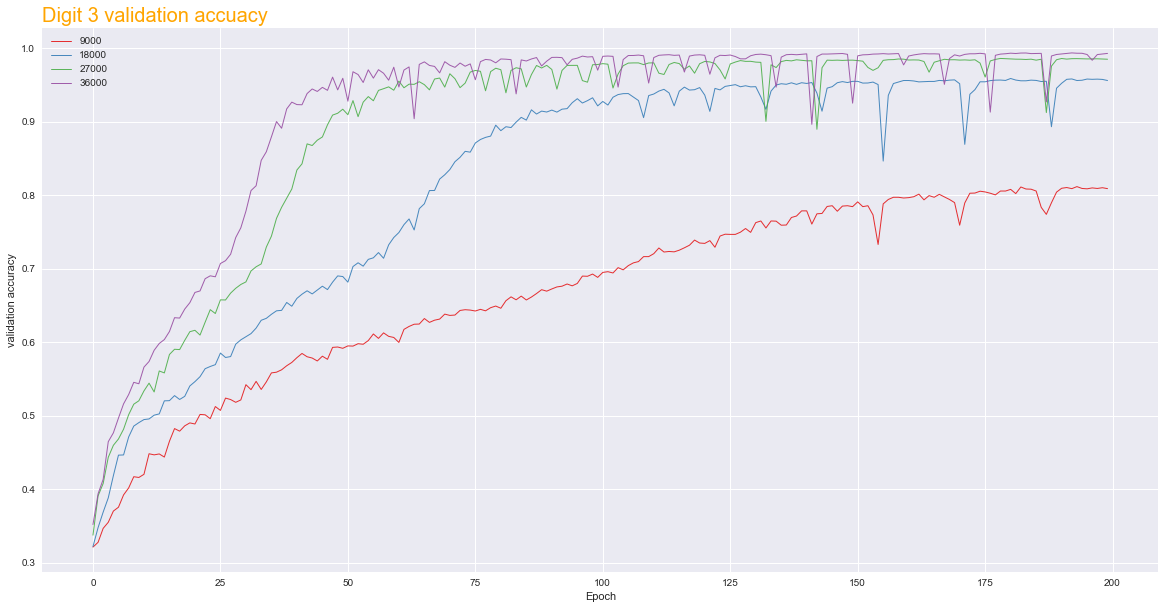

In [48]:
plt.figure(figsize=(20,10))

value = 'val_acc'
palette = plt.get_cmap('Set1')
plt.plot(d3s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d3s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d3s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d3s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 3 validation accuacy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("validation accuracy")
plt.show()

## Validation Loss

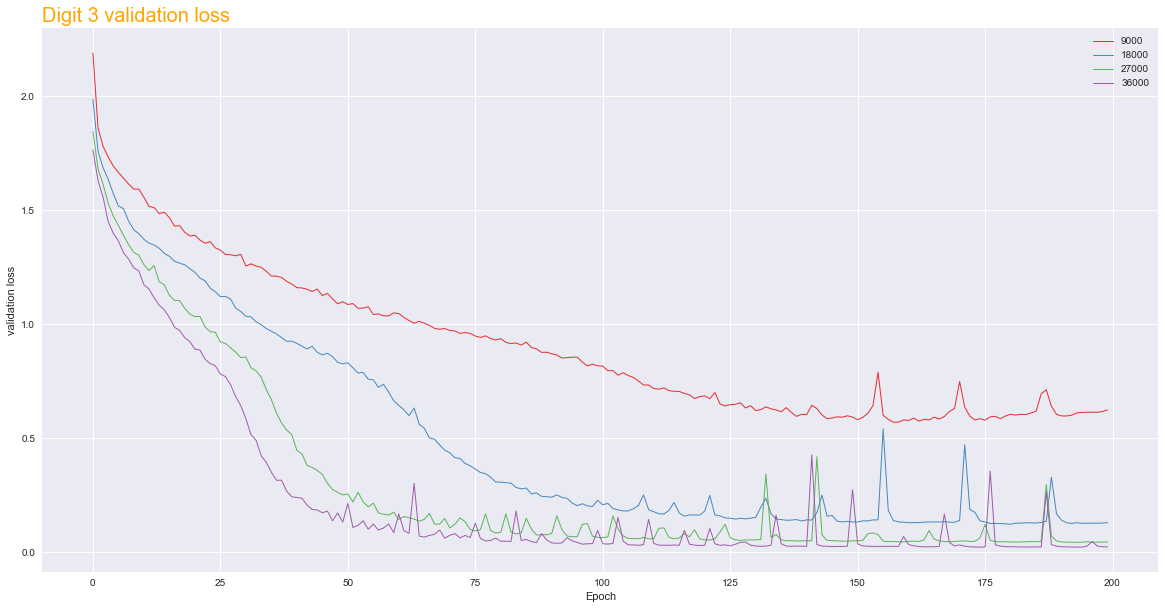

In [51]:
plt.figure(figsize=(20,10))

value = 'val_loss'
palette = plt.get_cmap('Set1')
plt.plot(d3s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d3s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d3s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d3s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 3 validation loss", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("validation loss")
plt.show()

## Training Accuracy

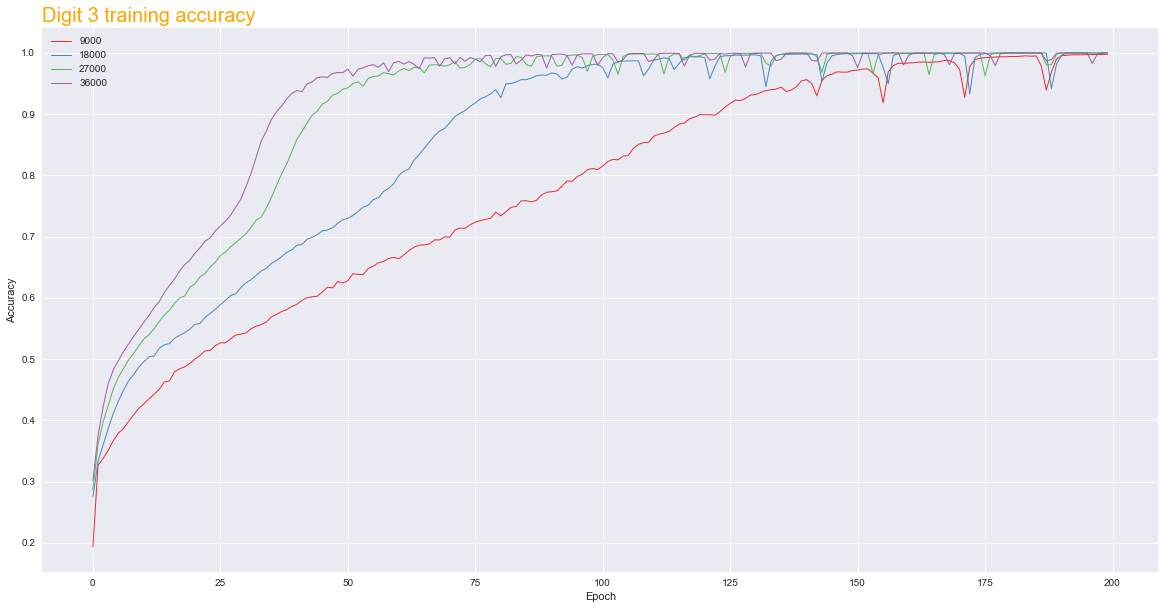

In [54]:
plt.figure(figsize=(20,10))

value = 'acc'
palette = plt.get_cmap('Set1')
plt.plot(d3s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d3s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d3s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d3s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 3 training accuracy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Training Loss

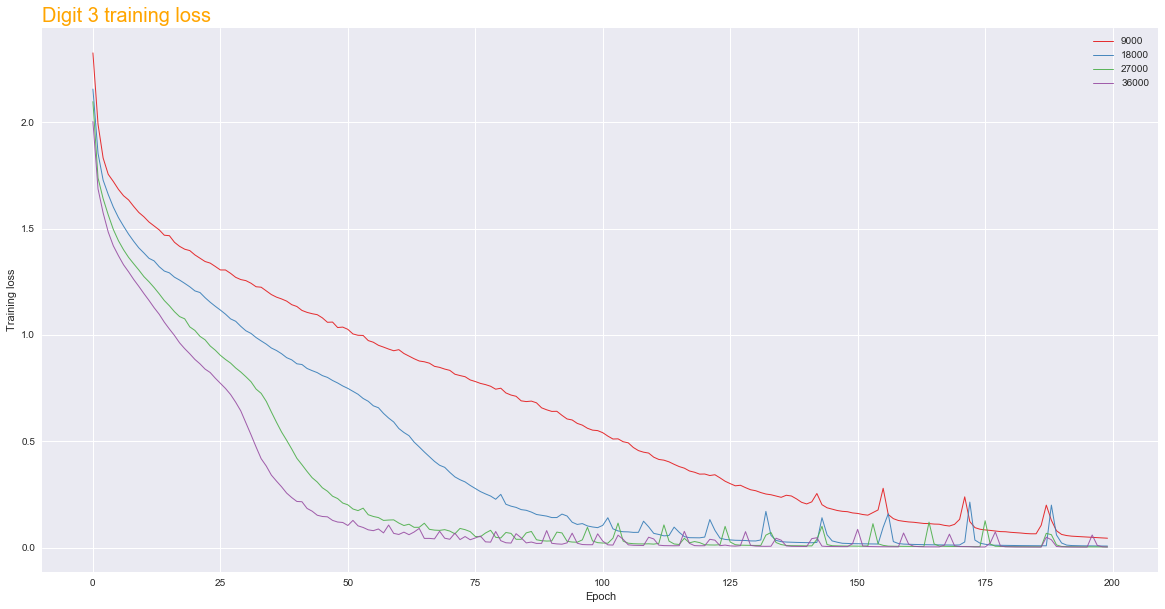

In [66]:
plt.figure(figsize=(20,10))

value = 'loss'
palette = plt.get_cmap('Set1')
plt.plot(d3s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d3s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d3s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d3s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 3 training loss", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

## TESTING ACCURACY

0    0.41536
1    0.85010
2    0.94280
3    0.97402
Name: test_acc, dtype: float64


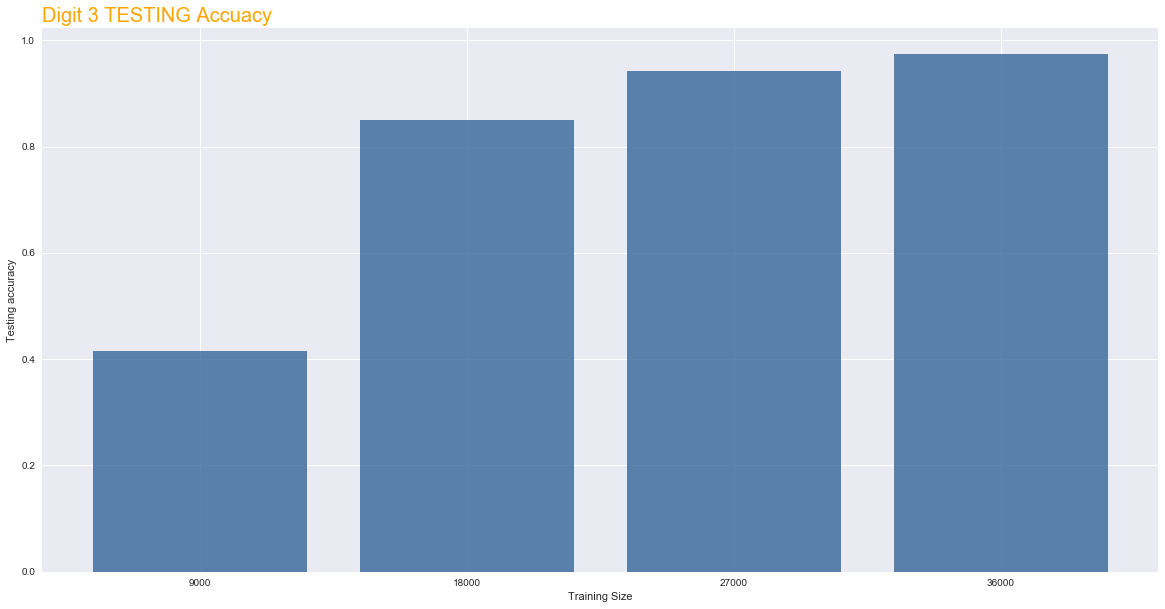

In [64]:
d3test_acc = pd.read_csv('./log/d3/test_d3_acc.csv')

print(d3test_acc['test_acc'])

plt.figure(figsize=(20,10))
bars = [9000,18000,27000,36000]

y_pos = np.arange(len(bars))
plt.bar(y_pos, d3test_acc['test_acc'], color=(0.2, 0.4, 0.6, 0.8))
plt.xticks(y_pos, bars)

plt.title("Digit 3 TESTING Accuacy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Training Size")
plt.ylabel("Testing accuracy")
plt.show()

## 

## DIGIT 4

In [68]:
# Read Data
d4s9 = pd.read_csv('./log/d4/s9.csv')
d4s18 = pd.read_csv('./log/d4/s18.csv')
d4s27 = pd.read_csv('./log/d4/s27.csv')
d4s36 = pd.read_csv('./log/d4/s36.csv')

## Digit 4 Validation Accuracy

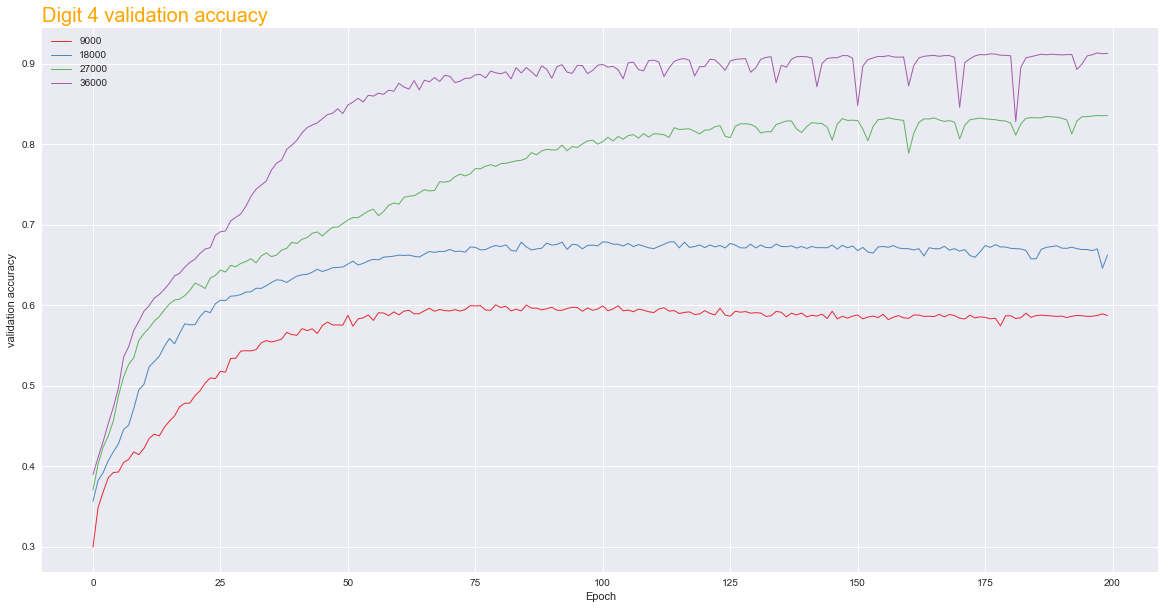

In [69]:
plt.figure(figsize=(20,10))

value = 'val_acc'
palette = plt.get_cmap('Set1')
plt.plot(d4s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d4s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d4s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d4s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 4 validation accuacy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("validation accuracy")
plt.show()

## Digit 4 Validation Loss

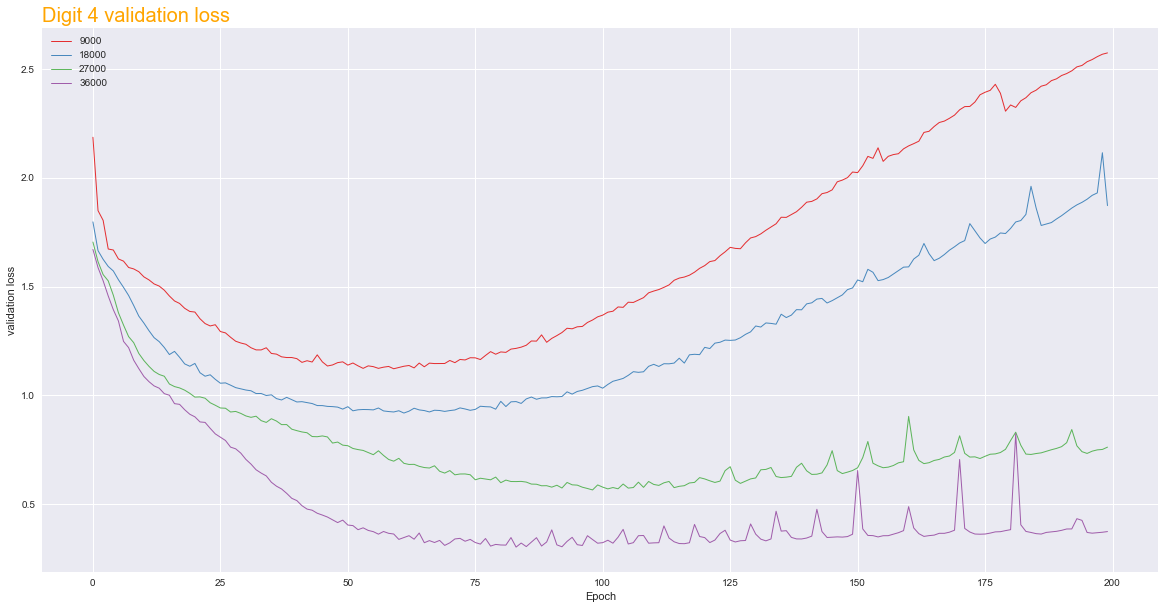

In [72]:
plt.figure(figsize=(20,10))

value = 'val_loss'
palette = plt.get_cmap('Set1')
plt.plot(d4s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d4s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d4s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d4s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 4 validation loss", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("validation loss")
plt.show()

## Digit 4 Training Accuracy

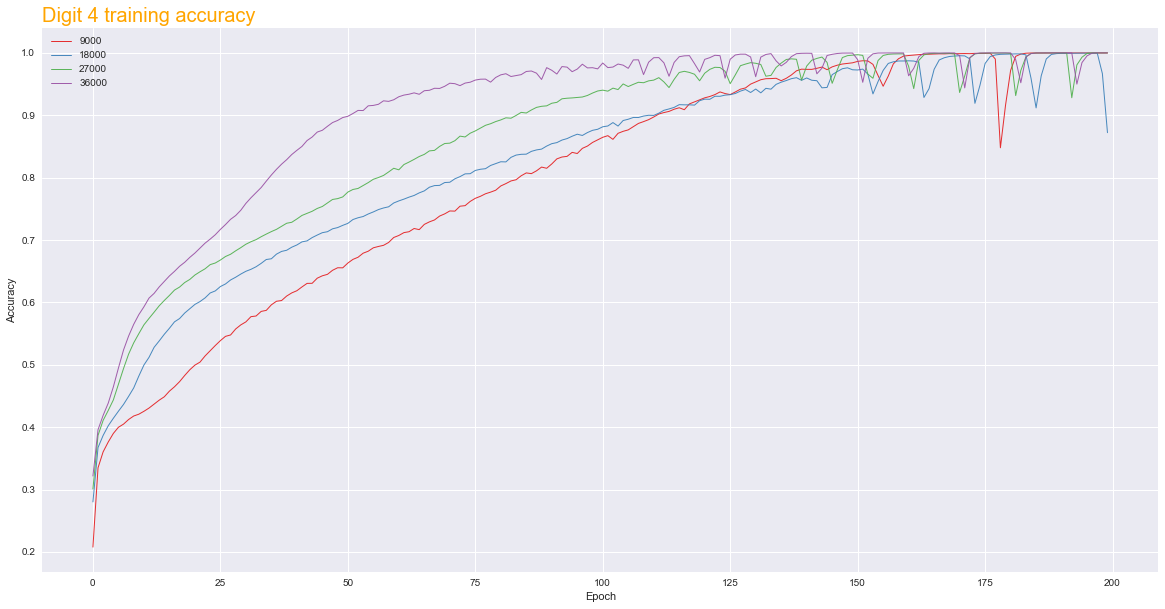

In [73]:
plt.figure(figsize=(20,10))

value = 'acc'
palette = plt.get_cmap('Set1')
plt.plot(d4s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d4s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d4s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d4s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 4 training accuracy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

## Digit 4 Training Loss

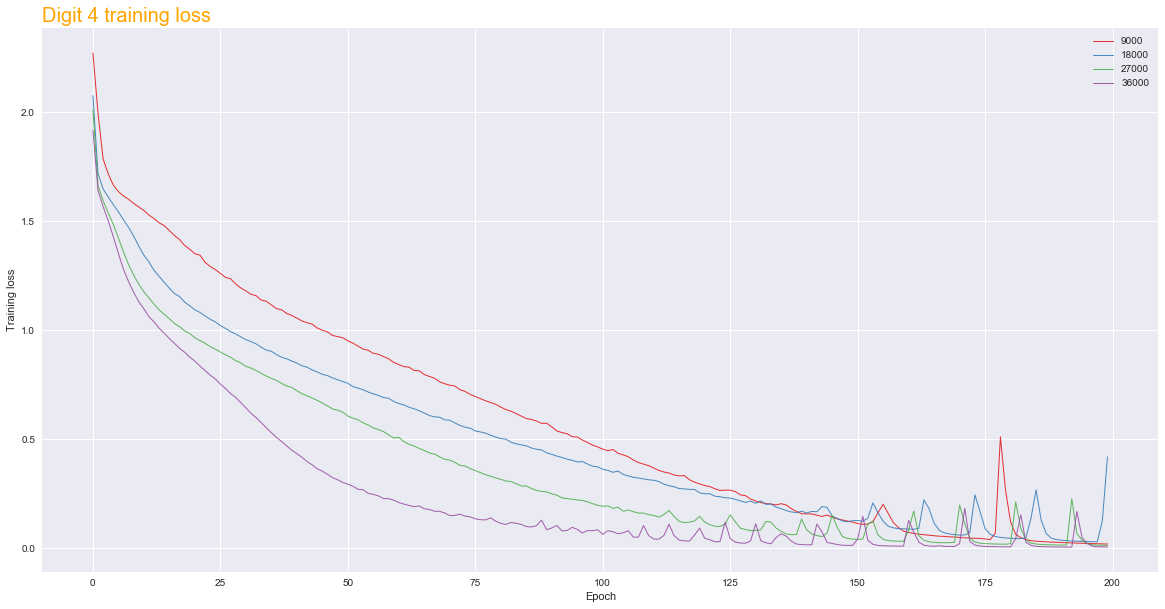

In [74]:
plt.figure(figsize=(20,10))

value = 'loss'
palette = plt.get_cmap('Set1')
plt.plot(d4s9[value], marker='', color=palette(0), linewidth=1, alpha=0.9, label='9000')
plt.plot(d4s18[value], marker='', color=palette(1), linewidth=1, alpha=0.9, label='18000')
plt.plot(d4s27[value], marker='', color=palette(2), linewidth=1, alpha=0.9, label='27000')
plt.plot(d4s36[value], marker='', color=palette(3), linewidth=1, alpha=0.9, label='36000')

plt.legend()

plt.title("Digit 4 training loss", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

## Digit 4 Testing Accuracy

0    0.03108
1    0.09666
2    0.45794
3    0.69044
Name: test_acc, dtype: float64


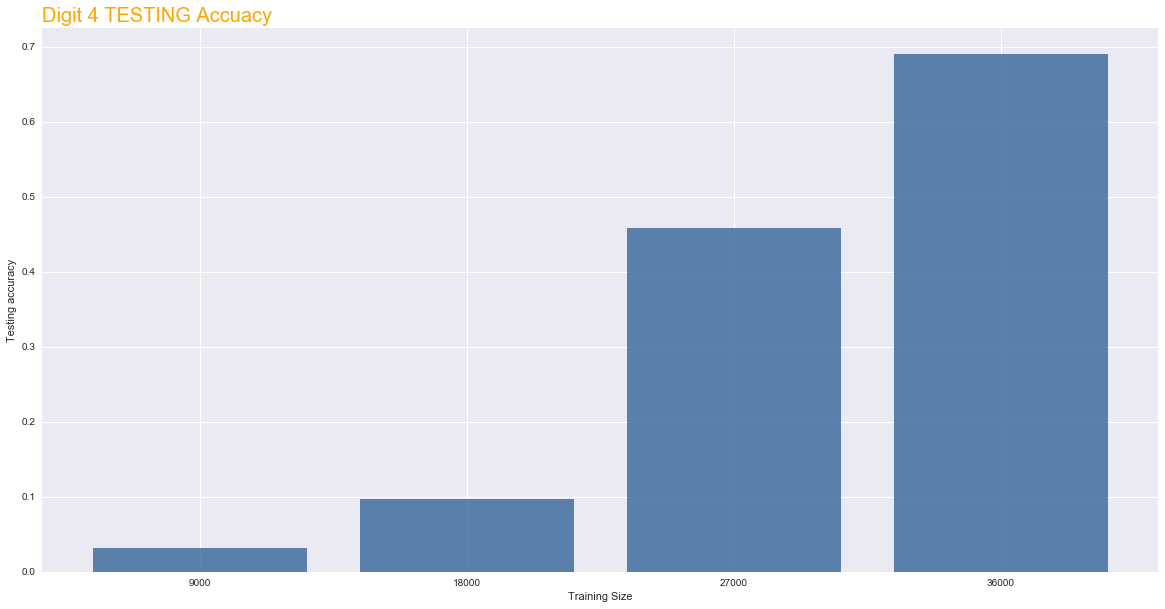

In [76]:
d4test_acc = pd.read_csv('./log/d4/test_d4_acc.csv')

print(d4test_acc['test_acc'])

plt.figure(figsize=(20,10))
bars = [9000,18000,27000,36000]

y_pos = np.arange(len(bars))
plt.bar(y_pos, d4test_acc['test_acc'], color=(0.2, 0.4, 0.6, 0.8))
plt.xticks(y_pos, bars)

plt.title("Digit 4 TESTING Accuacy", loc='left', fontsize=20, fontweight=0, color='orange')
plt.xlabel("Training Size")
plt.ylabel("Testing accuracy")
plt.show()